# Data z reálné jízdy (RSX-UM7)
> Zkoumání pro korelaci s realitou

### 📙 Importy

In [1]:
import pandas as pd
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
import ruptures as rpt
import importlib
from csv2geojson import prep
import json
from fastdtw import fastdtw
from dbrail2geojson import get_rail
from scipy.signal import savgol_filter
import numpy as np
from ipyleaflet import Map, basemaps, Marker, Polyline, basemap_to_tiles

pd.options.mode.chained_assignment = None

### 🌐 Globální nastavení a proměnné

In [2]:
PREP_GEOJSONS=False

processed_sections=[]

### 📈 Vizualizační funkce

In [3]:
def render_plot(title, x, ys, labels, linestyles=None, width=20, show_hline=False, legend_loc="upper left"):
    if linestyles is None:
        linestyles = ["solid"]*len(ys)
    plt.figure().set_figwidth(width)
    for i,y in enumerate(ys):
        plt.plot(x, y, linestyle=linestyles[i])
    plt.title(title)
    if len(labels) > 0:
        plt.legend(labels, loc=legend_loc)
    if show_hline:
        plt.axhline(y=0, xmin=0.0, xmax=1.0, color="red", linestyle="--", lw=1)
    plt.show()

### ⬇️ Načtení souboru se surovými daty

In [4]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_06-26-06.csv") # Korekce pro začátek jízdy
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

df2 = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_09-04-10.csv") # Korekce pro začátek jízdy
# df2["accel_proc_y"] *= -1 # Korekce pro jízdní směr

# geojson = make_geojson(df["gps_latitude"], df["gps_longitude"])
# with open("/tmp/test.geojson", "w") as f:
#     f.write(geojson)

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')
Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


### 🔎 Náhled na akceleraci a rychlost v celém souboru

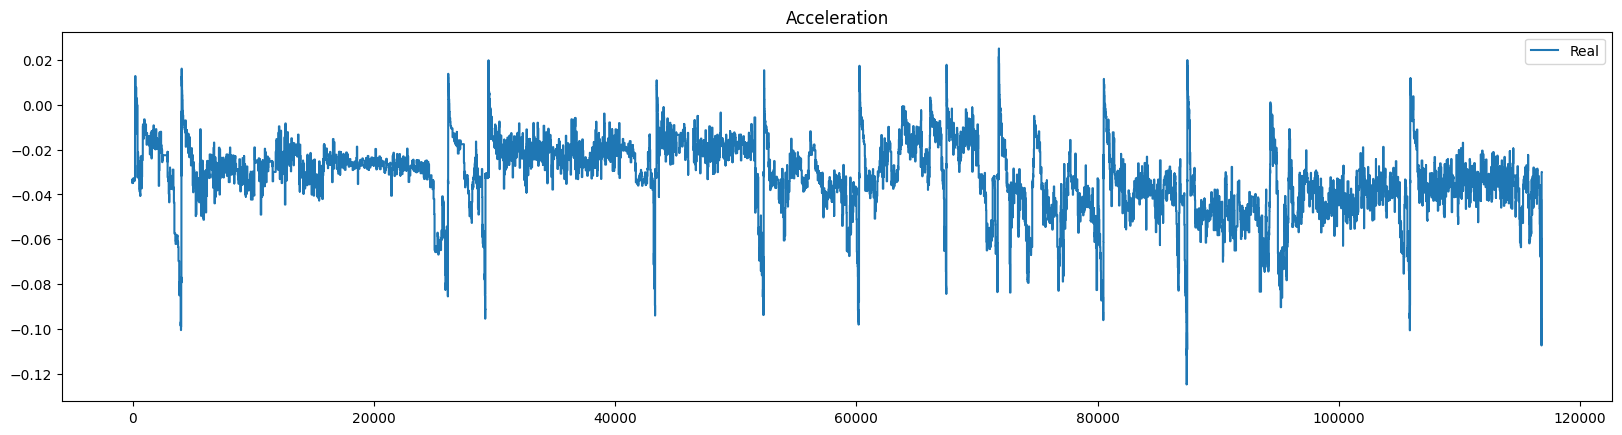

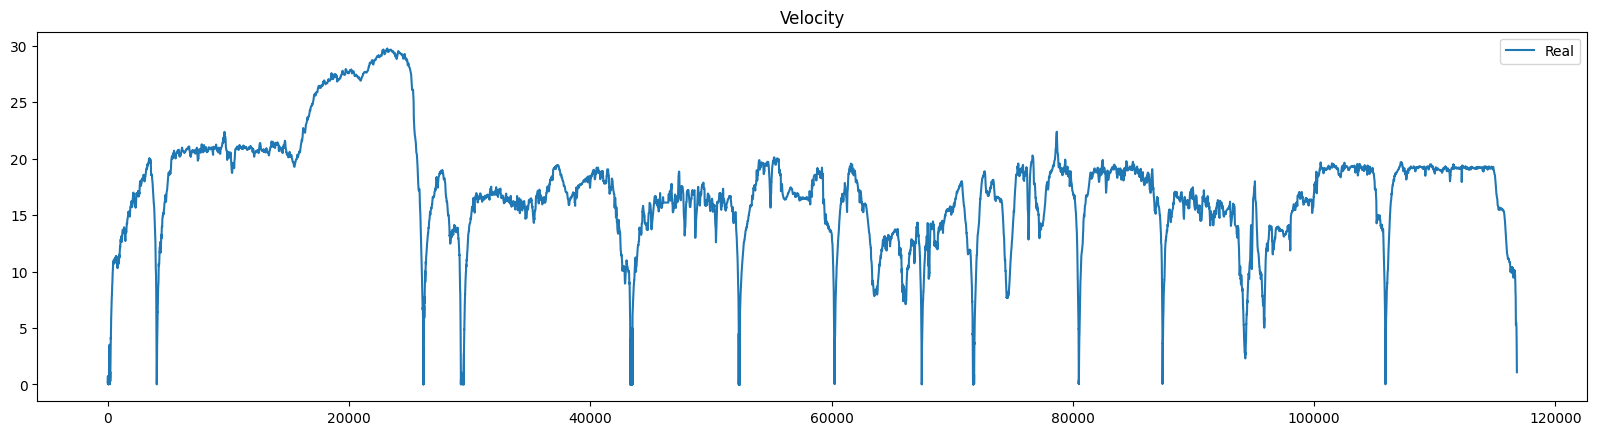

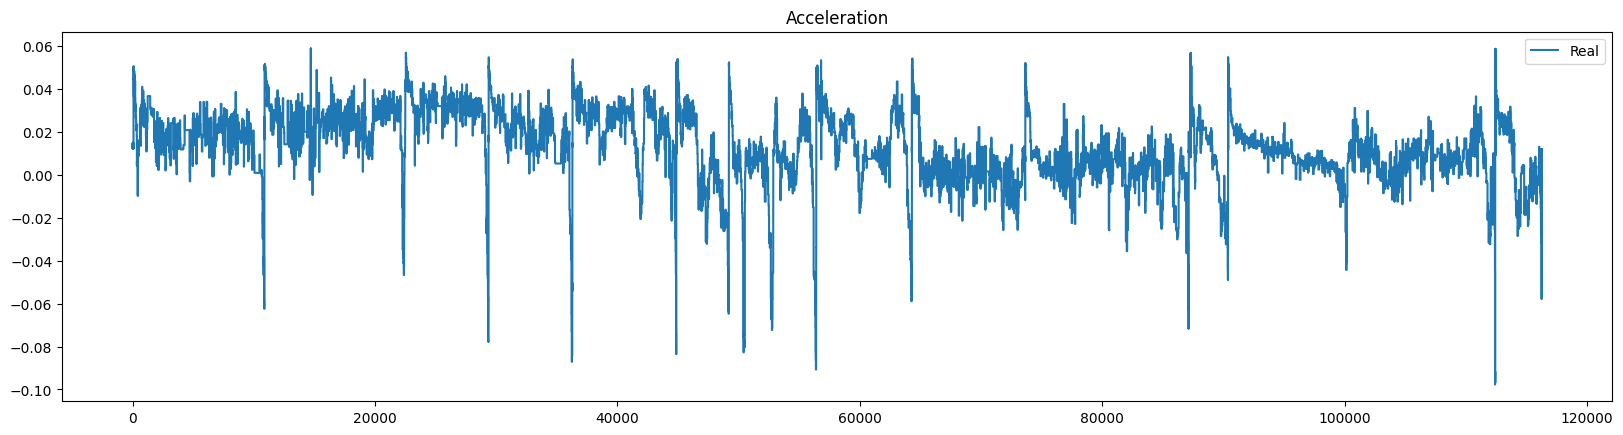

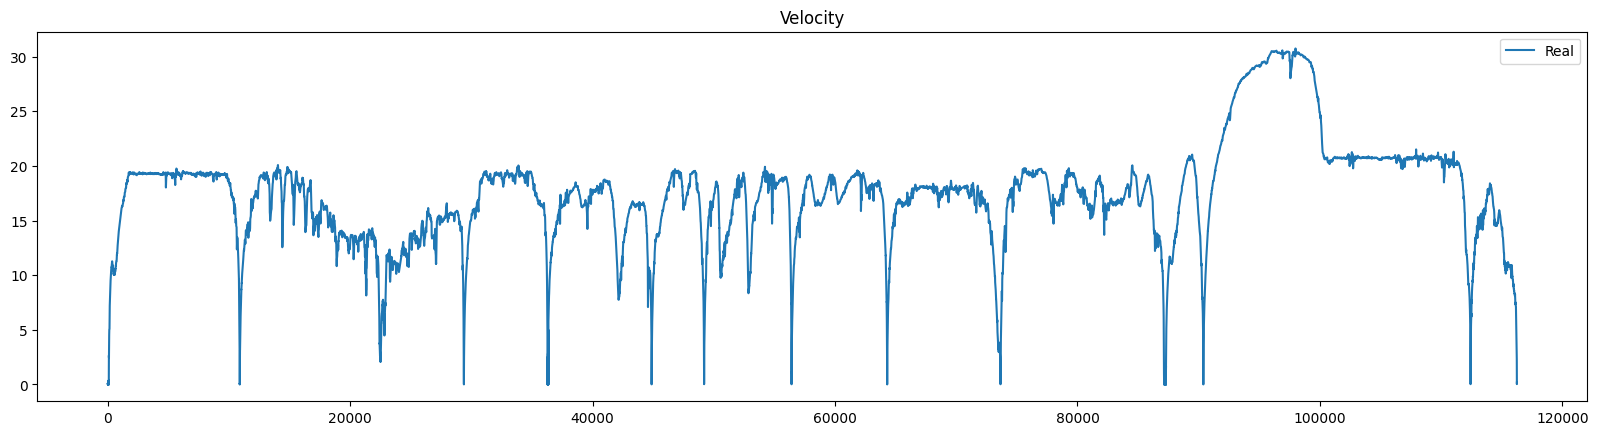

In [5]:
plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df2["cumulative_distance_m"], df2["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df2["cumulative_distance_m"], df2["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

### 🛠️ Funkce pro zpracování

In [6]:
def map_velocity(df_measured, first_offset, velocity_fp, reverse=False):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    first_dist = df_measured["cumulative_distance_m"].iloc[0]
    if not reverse:
        for tv in track_velocity:
            start_in_m = tv["start"]*1000
            df_measured.loc[first_offset*1000 - (df_measured["cumulative_distance_m"]-first_dist) <= start_in_m, "track_velocity"] = tv["value"]
    else:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            df_measured.loc[first_offset*1000 + (df_measured["cumulative_distance_m"]-first_dist) >= start_in_m, "track_velocity"] = tv["value"]

    df_measured["track_velocity_m_s"] = df_measured["track_velocity"]/3.6

def infer_velocity(df_measured, penalty):
    # Getting velocity segments
    algo = rpt.Pelt(model="rbf").fit(df_measured["gps_speed"].values)
    result = algo.predict(pen=penalty)

    max_velocities = []
    prev_end = 0
    for i,r in enumerate(result):
        segment = df_measured["gps_speed"][prev_end:r]
        if len(df_measured["gps_speed"][result[i-1]:r]) < 100 and i != len(result)-1:
            continue
        prev_end = r
        max_velocities += [max(segment)] * len(segment)

    df_measured["track_velocity_m_s"] = max_velocities

In [7]:
def run_simulation(df_measured, geojson_path: str, compensate=True):
    # Calculated data
    c = tconsumption.Consumption()
    c.variable_params.update({
        'Recuperation coefficient': 0.6998270177197322,
        'Curve A': 226.0739452231682,
        'Curve B': 55.026751900632405,
        'Running a': 0.706437197926143,
        'Running b': 0.01899266921470387,
        'Running c': 0.008283331094691721,
        'Comfortable acceleration': 0.41725031534778388,
        'Elevation smoothing': 100,
        'Curve smoothing': 10
        # compensation polynomial has a default
    })
    if not compensate:
        c.variable_params["Compensation polynomial"] = None
    c.load_from_file(geojson_path)
    c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"])
    # print("unique velocities in km/h", set([x*3.6 for x in df_measured["track_velocity_m_s"]]))

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 31490 + 33000

    # Running the simulation
    c.run()

    return c

In [8]:
def compare_data(df_measured, geojson_path: str):
    c = run_simulation(df_measured, geojson_path, False)
    cc = run_simulation(df_measured, geojson_path, True)

    # Plotting
    # render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    limited_len = len(c.series["dist_values"])
    # limited_len = 1566
    render_plot(
        "Velocity",
        c.series["dist_values"][:limited_len],
        [c.series["velocity_values"][:limited_len], cc.series["velocity_values"], df_measured["gps_speed"][:limited_len], c.max_velocities_in_mps[:limited_len]],
        ["Simulation", "Simulation (compensated)", "Real", "Limit"],
        ["solid", "solid", "solid", "dashed"],
        legend_loc="lower center"
    )

    # Velocity deltas
    velocity_deltas = []
    # Get deltas
    for i in range(len(c.series["velocity_values"])):
        delta = c.series["velocity_values"][i] - df_measured["gps_speed"].iloc[i]
        velocity_deltas.append(delta)

    render_plot(
        "Velocity delta",
        c.series["dist_values"],
        [velocity_deltas],
        ["Delta"],
        ["solid"]
    )

    dtw = fastdtw(c.series["velocity_values"], df_measured["gps_speed"])[0]
    print("DTW:", dtw)

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"][:100],
    #     [c.series["acceleration_values"][:100]],
    #     ["Simulation (slice)"]
    # )

    # GPS info
    m = Map(
        basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
        center=((df_measured.iloc[0]['gps_latitude']+df_measured.iloc[-1]['gps_latitude'])/2, (df_measured.iloc[0]['gps_longitude']+df_measured.iloc[-1]['gps_longitude'])/2),
        zoom=12
    )
    line = Polyline(
        locations=df_measured[["gps_latitude", "gps_longitude"]].values.tolist(),
        color="green",
        fill=False
    )
    m.add_layer(line)
    return m

### 🛤️ Zpracované úseky

#### 🤖 Automatické rozdělení na úseky

In [9]:
def get_station_ranges(df, station_names):
    df_auto = df.copy()
    df_auto.loc[df_auto["gps_speed"] < 1, "train_stopped"] = True
    df_auto.loc[df_auto["gps_speed"] >= 1, "train_stopped"] = False

    # Extract raw ranges
    df_auto["consec_group"] = (df_auto["train_stopped"] != df_auto["train_stopped"].shift(1)).cumsum()
    count = df_auto[["train_stopped", "consec_group"]].value_counts()
    count.sort_index(level=1, inplace=True)
    consec_values = [(x[0], y) for x, y in count.items()]

    # Process start-stop ranges
    new_consec = []
    to_next = None
    for g in consec_values:
        if g[0] or not g[0] and g[1] >= 200:
            if len(new_consec) > 0 and new_consec[-1][0] == g[0]:
                new_consec[-1] = (new_consec[-1][0], new_consec[-1][1]+g[1])
            else:
                new_consec.append(g)
            if to_next is not None:
                new_consec[-1] = (new_consec[-1][0], new_consec[-1][1]+to_next)
                to_next = None
        else:
            if len(new_consec) > 0:
                new_consec[-1] = (new_consec[-1][0], new_consec[-1][1]+g[1])
            else:
                to_next = g[1]

    # Find station_ranges
    station_ranges = []
    running_count = 0
    current_start = None
    current_end = None
    station_idx = 0
    for g in new_consec:
        running_count += g[1]
        if g[0] and current_start is None:
            current_start = running_count-1
        if not g[0] and current_end is None:
            current_end = running_count-1
            station_ranges.append({
                "station_start": station_names[station_idx],
                "start": current_start,
                "station_end": station_names[station_idx+1],
                "end": current_end
            })
            station_idx += 1
            current_start, current_end = None, None

    # plot_range = (0, len(df_auto["gps_speed"]))
    # # plot_range = (1000, 4000)
    # render_plot(
    #     "Velocity",
    #     df_auto["cumulative_distance_m"][plot_range[0]:plot_range[1]],
    #     [df_auto["gps_speed"][plot_range[0]:plot_range[1]], df_auto["train_stopped"][plot_range[0]:plot_range[1]]],
    #     ["Velocity"],
    #     ["solid", "solid"],
    #     legend_loc="upper left"
    # )

    return station_ranges

In [10]:
def compare_station_ranges(df, station_ranges):
    m = Map(
        basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
        center=((df.iloc[0]['gps_latitude']+df.iloc[-1]['gps_latitude'])/2, (df.iloc[0]['gps_longitude']+df.iloc[-1]['gps_longitude'])/2),
        zoom=12
    )

    importlib.reload(tconsumption)

    for sr in station_ranges:
        loc = (df.iloc[sr["start"]]["gps_latitude"], df.iloc[sr["start"]]["gps_longitude"])

        # GPS info
        marker = Marker(location=loc, draggable=False)
        m.add_layer(marker)

        print(sr)

        df_slice = df.loc[sr["start"]:sr["end"]] # Rozsah bodů mezi stanicemi
        infer_velocity(df_slice, 10)

        output_geojson = f"../testing-data/um7/um7capture_auto_{sr['station_start'].replace(' ', '_')}-{sr['station_end'].replace(' ', '_')}.geojson"
        if PREP_GEOJSONS:
            prep({
                # "input": "NOT NEEDED",
                "output": output_geojson,
                "host": "localhost",
                "dbname": "railway_mapdb",
                "dbuser": "postgres",
                "dbpass": "mysecretpassword",
                "dbtable": "train_testing_data"
            }, df=df_slice)


        processed_sections.append({"df": df_slice, "geojson": output_geojson})
        compare_data(
            df_slice,
            output_geojson
        )

    return m

#### 🚂 Cesta tam (komplet)

12
{'station_start': 'Opava východ', 'start': 348, 'station_end': 'Opava západ', 'end': 989}


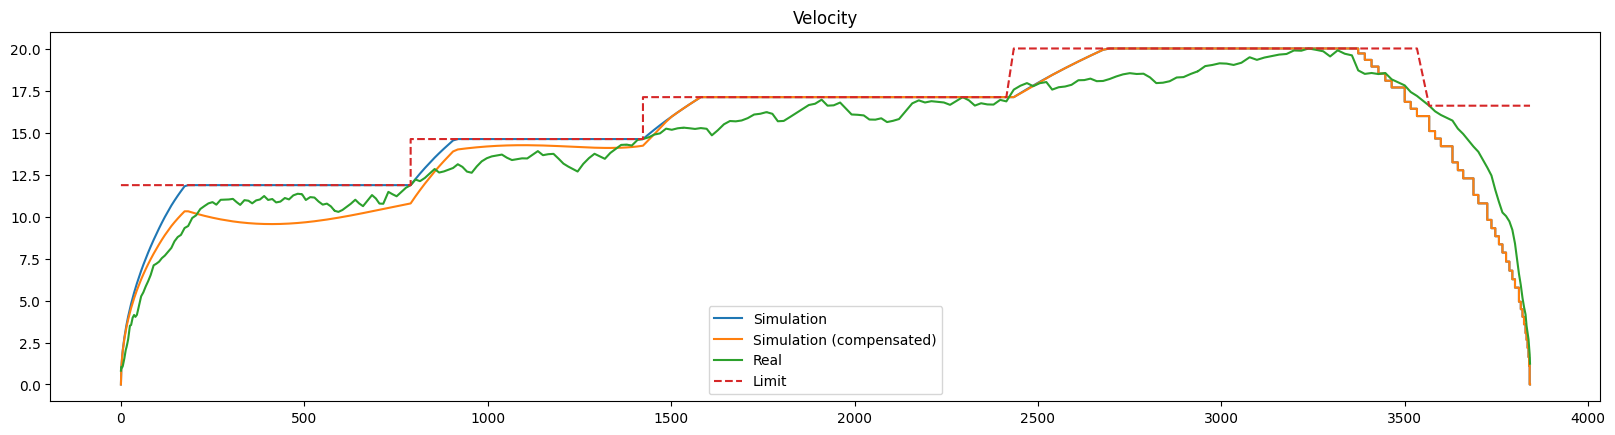

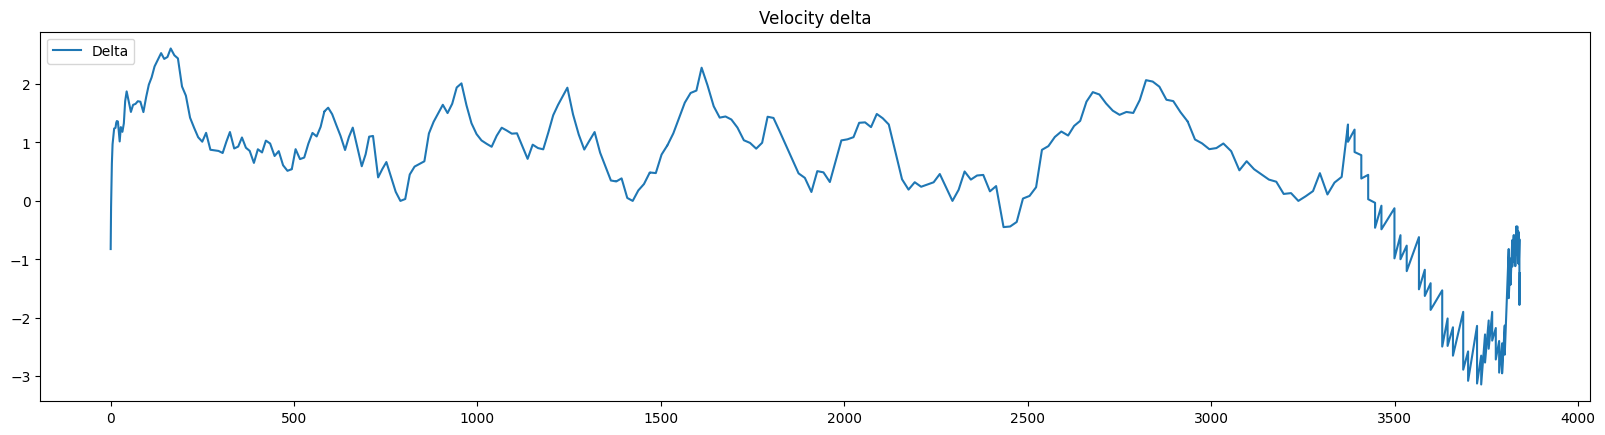

DTW: 153.40764464800577
{'station_start': 'Opava západ', 'start': 1092, 'station_end': 'Krnov-Cvilín', 'end': 3521}


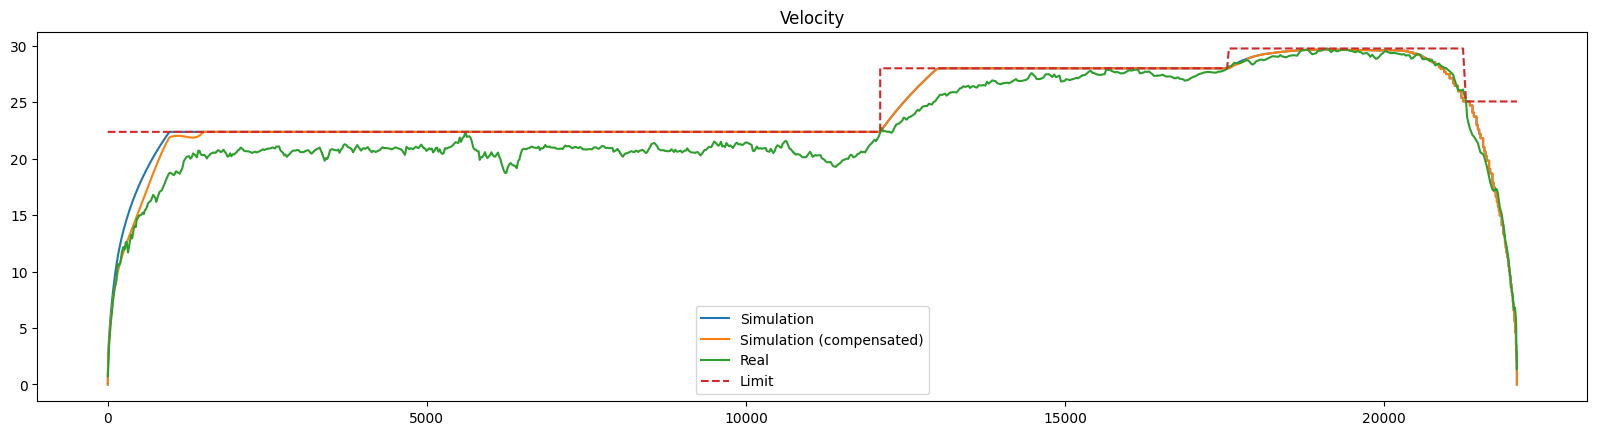

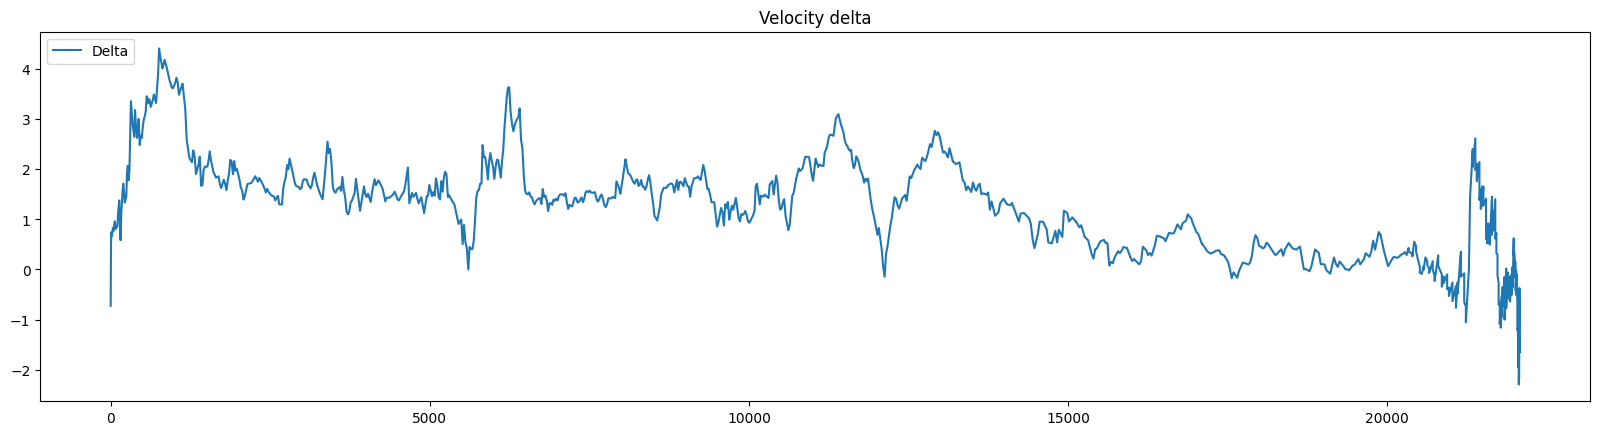

DTW: 1081.3821749766457
{'station_start': 'Krnov-Cvilín', 'start': 3704, 'station_end': 'Krnov', 'end': 4248}


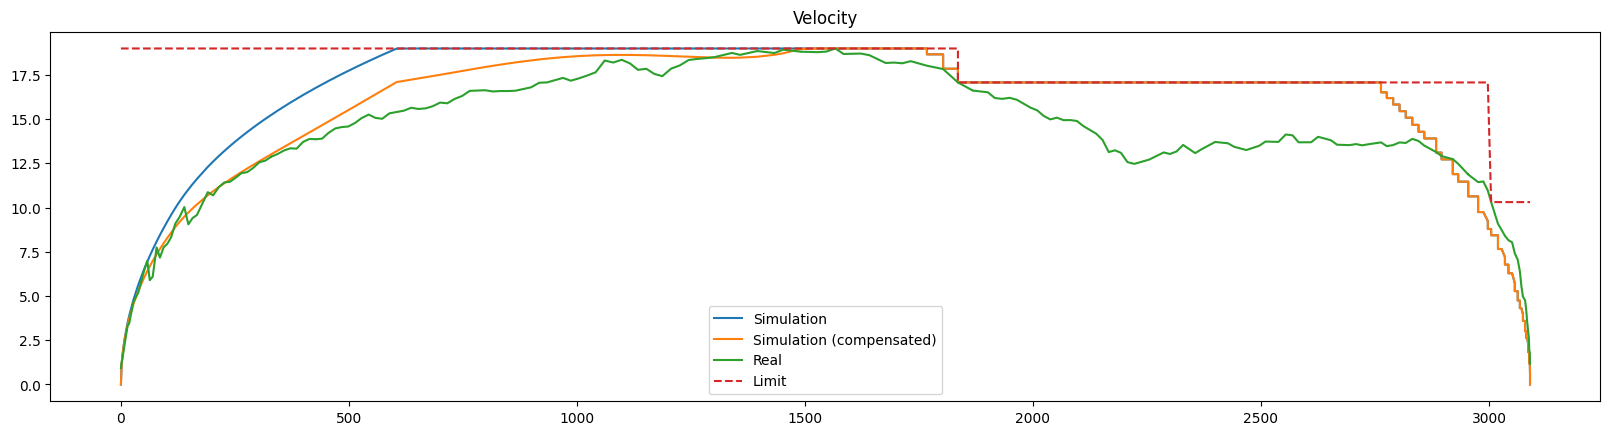

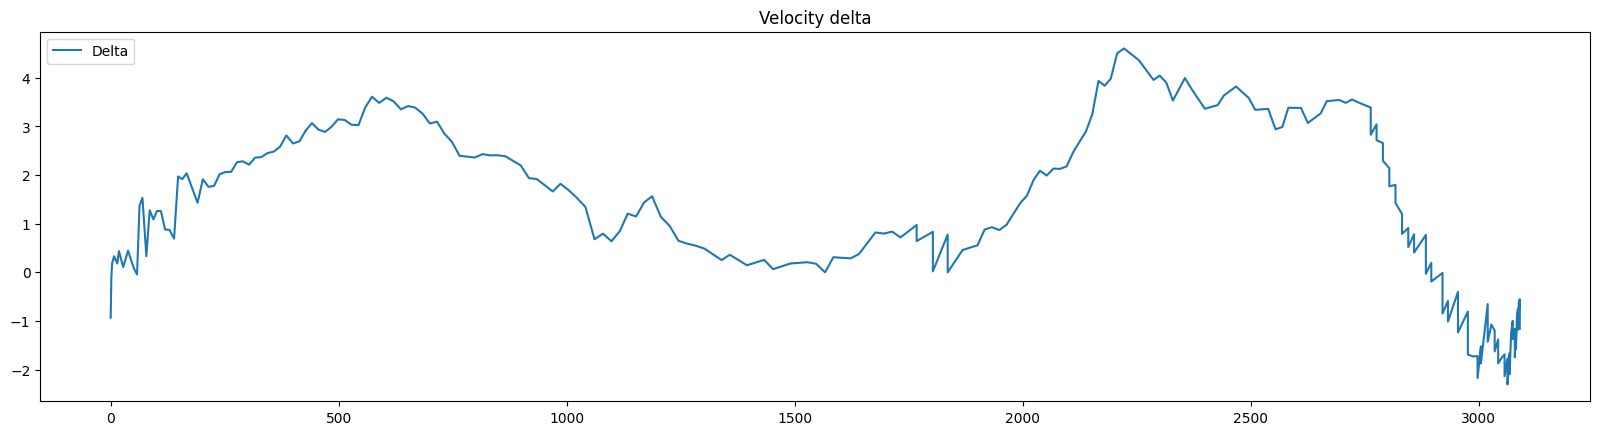

DTW: 129.74660604646579
{'station_start': 'Krnov', 'start': 5595, 'station_end': 'Milotice n.Opavou', 'end': 7766}


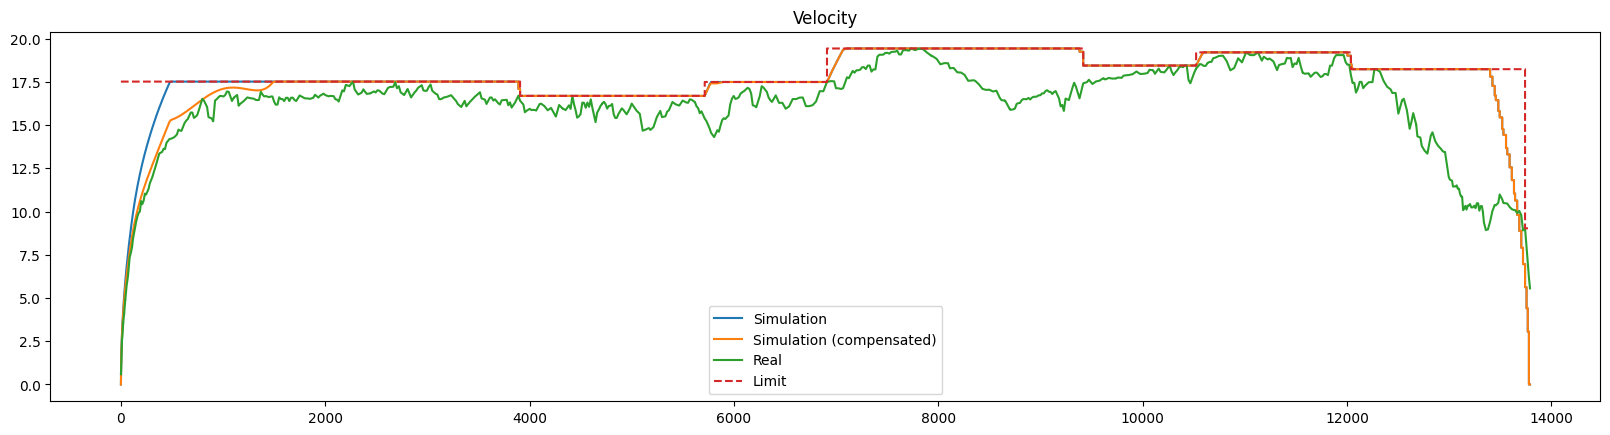

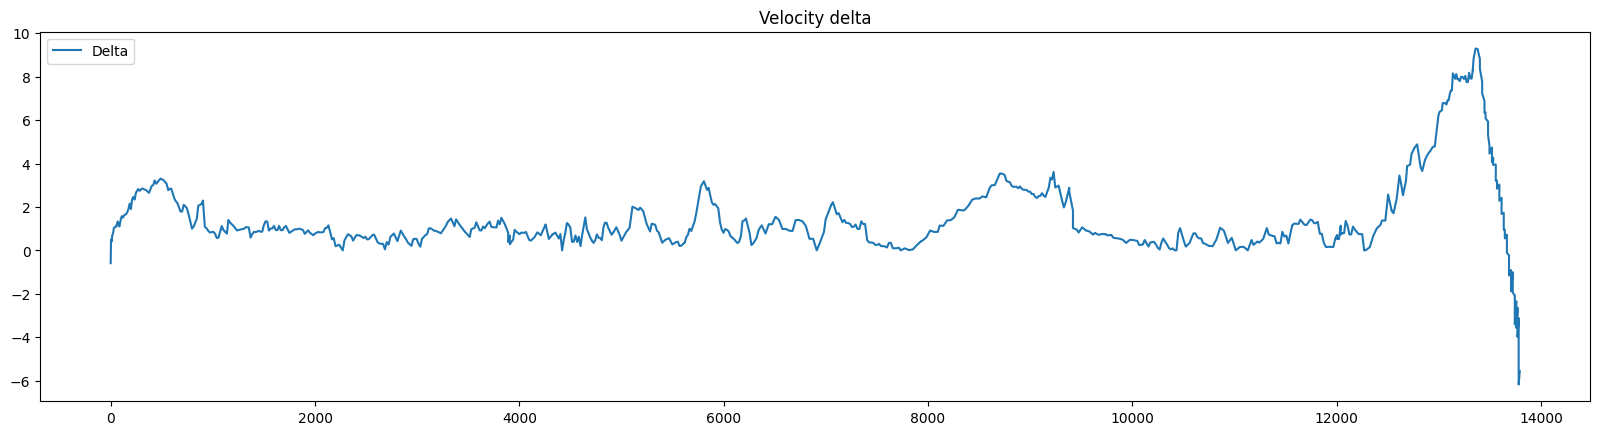

DTW: 1249.4799805930909
{'station_start': 'Milotice n.Opavou', 'start': 8336, 'station_end': 'Bruntál', 'end': 9786}


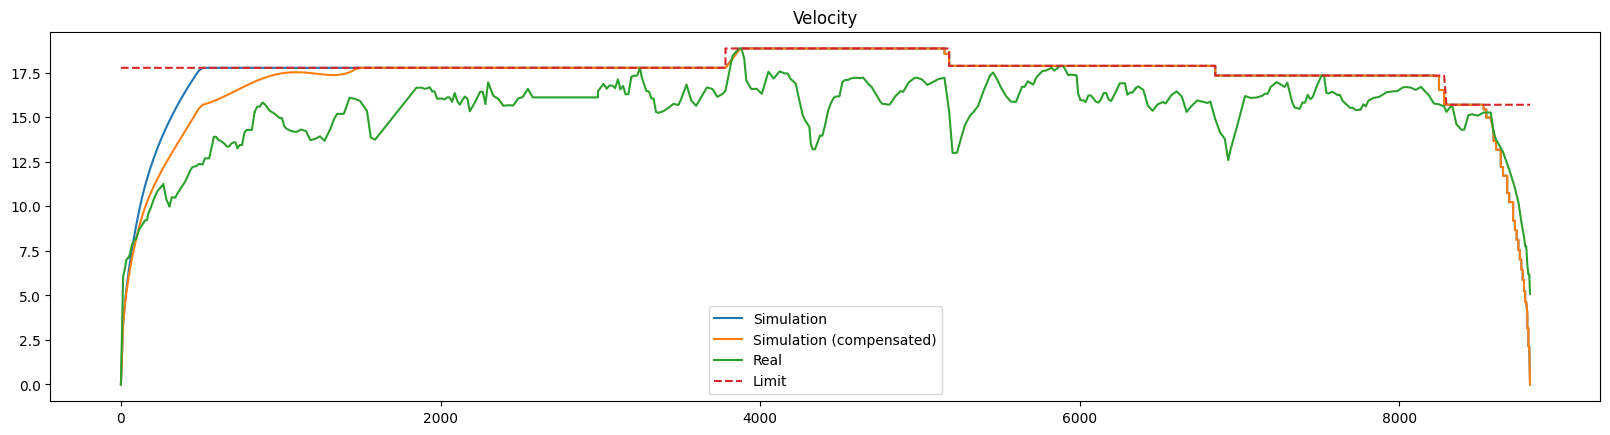

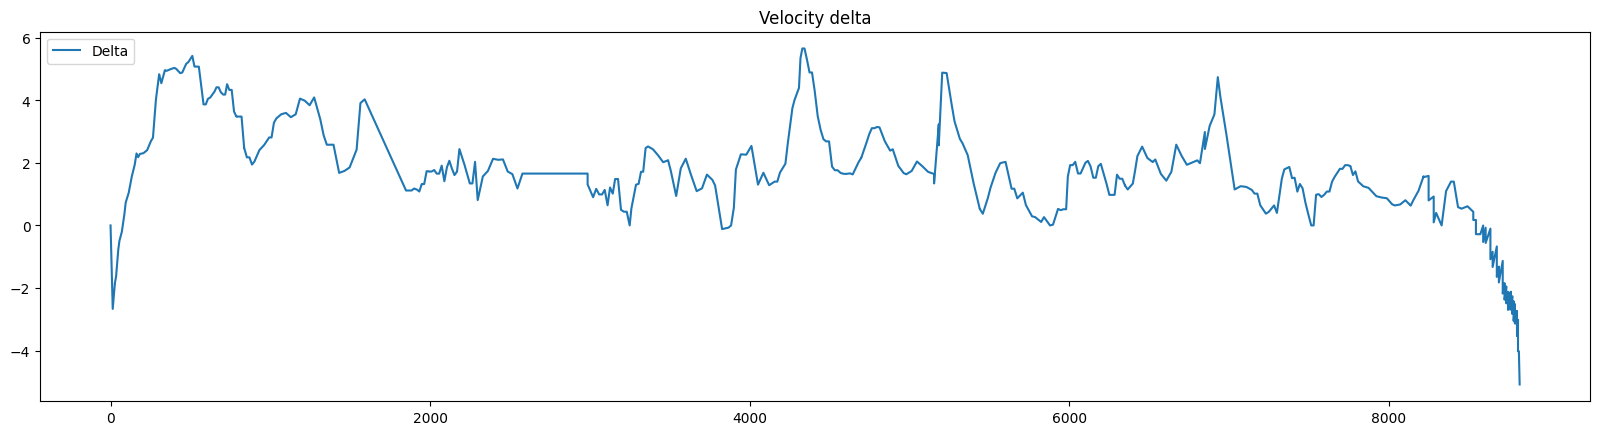

DTW: 1356.5343180139314
{'station_start': 'Bruntál', 'start': 10142, 'station_end': 'Valšov', 'end': 11371}


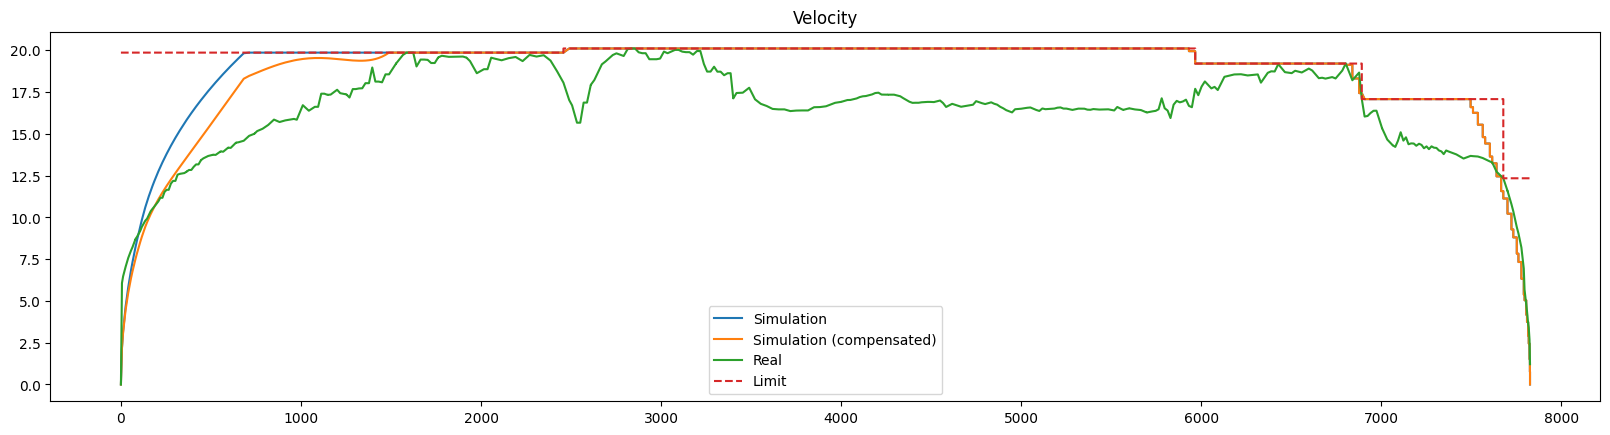

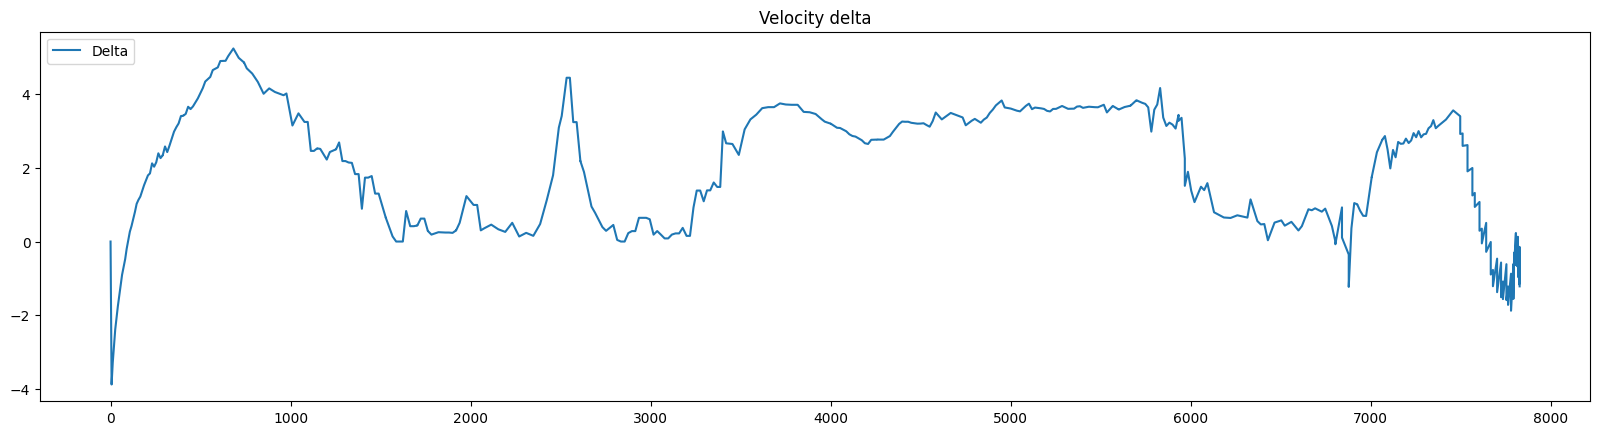

DTW: 595.8734288301783
{'station_start': 'Valšov', 'start': 11481, 'station_end': 'Lomnice u Rýmařova', 'end': 12849}


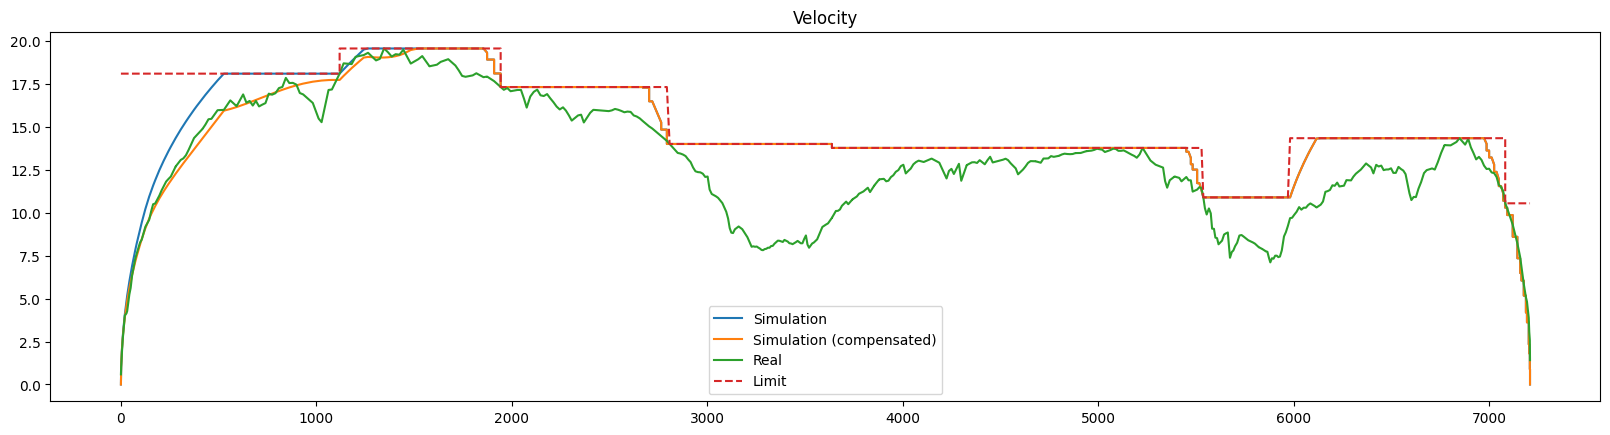

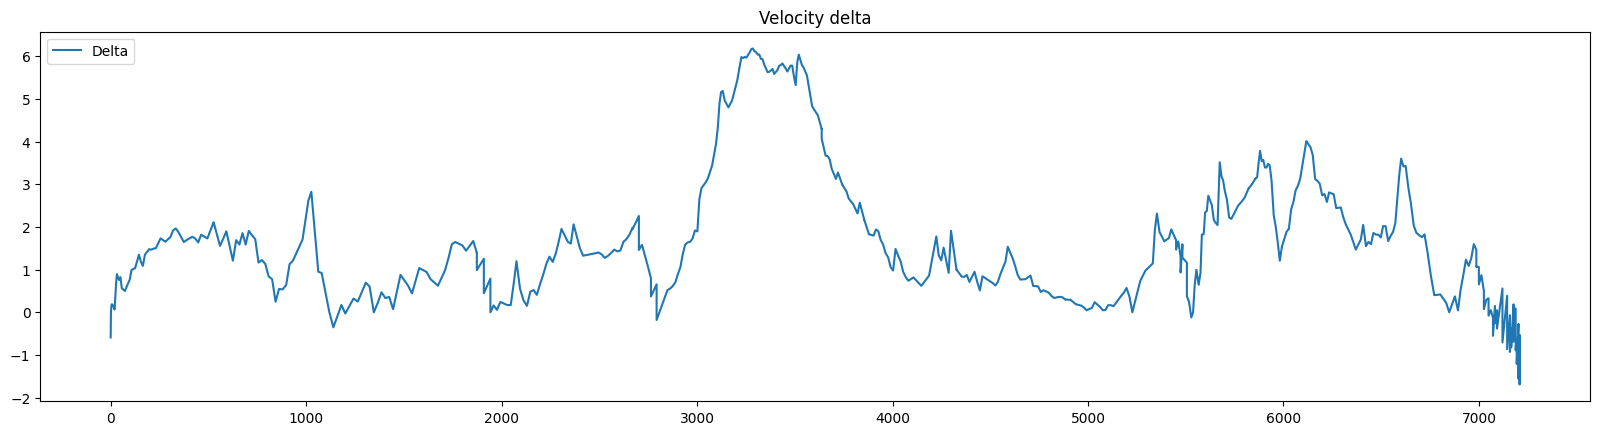

DTW: 1718.1904494245837
{'station_start': 'Lomnice u Rýmařova', 'start': 12922, 'station_end': 'Dětřichov n.Bystřicí', 'end': 13695}


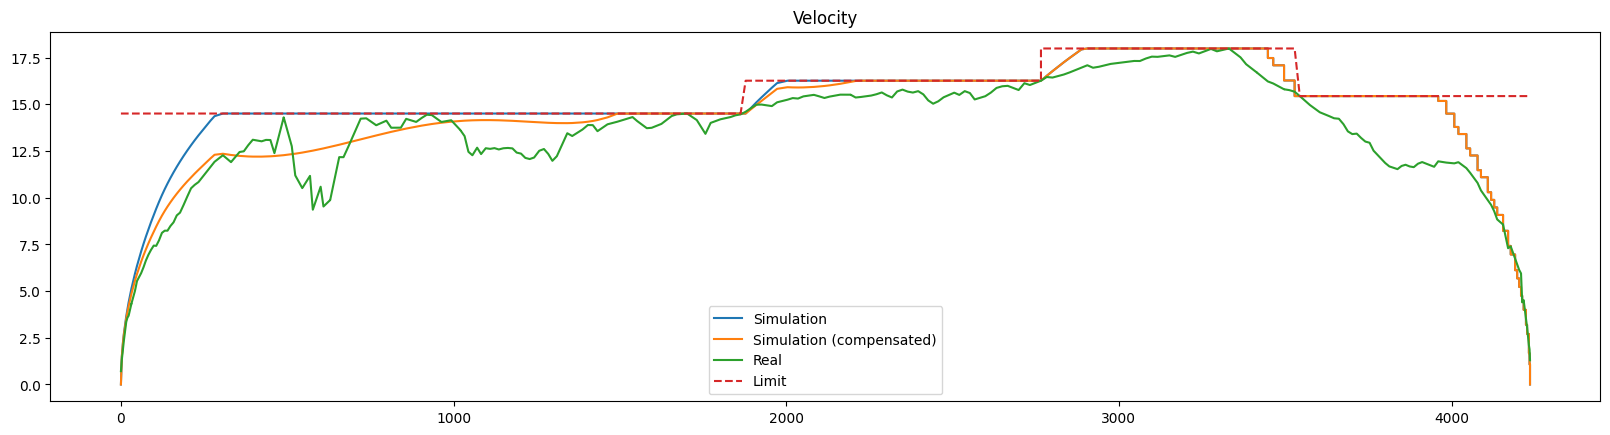

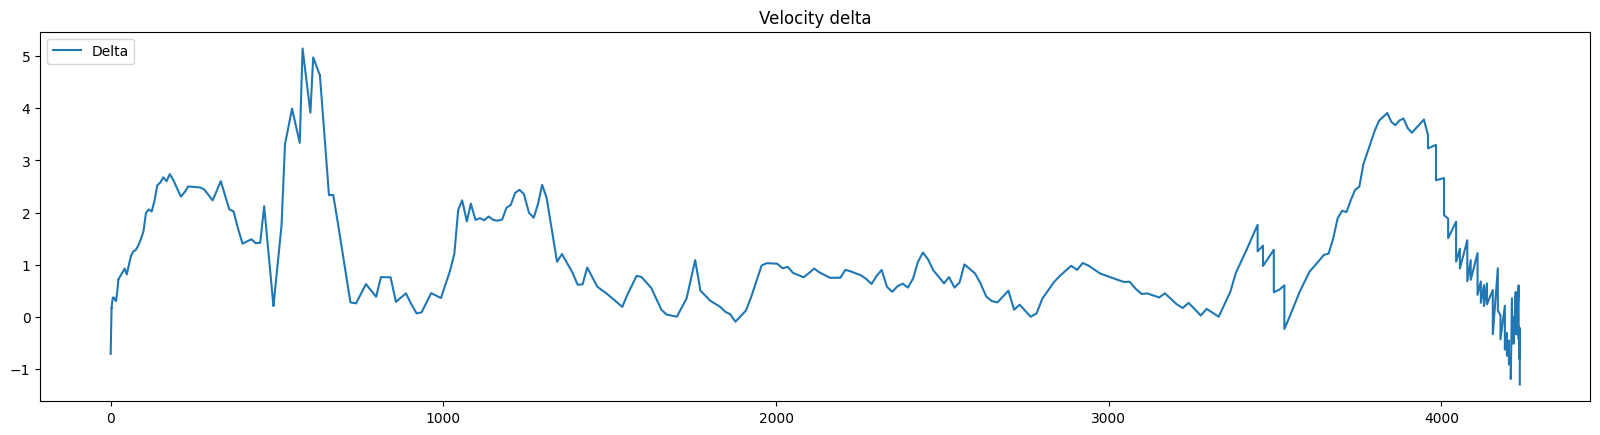

DTW: 277.87662863690105
{'station_start': 'Dětřichov n.Bystřicí', 'start': 14381, 'station_end': 'Moravský Beroun', 'end': 15716}


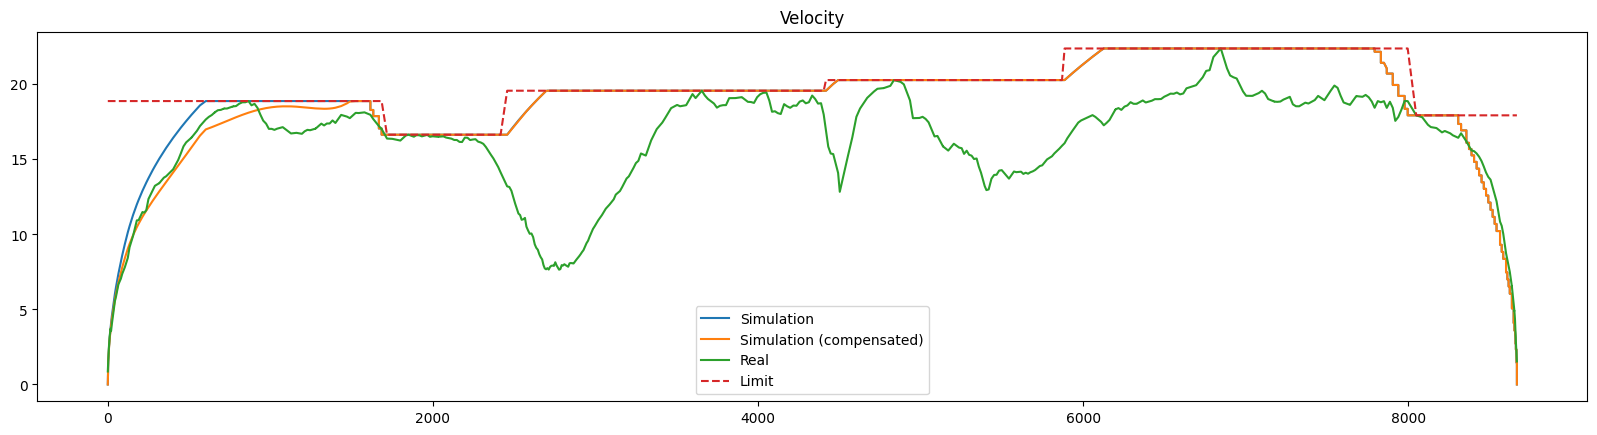

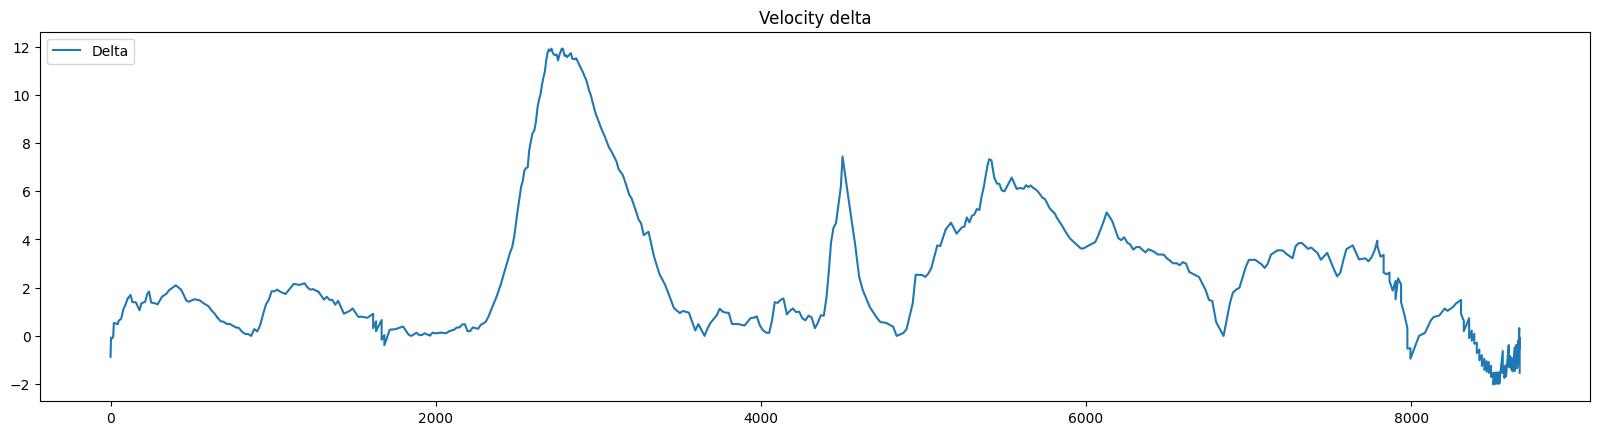

DTW: 2194.488436076872
{'station_start': 'Moravský Beroun', 'start': 15812, 'station_end': 'Domašov n.Bystřicí', 'end': 16800}


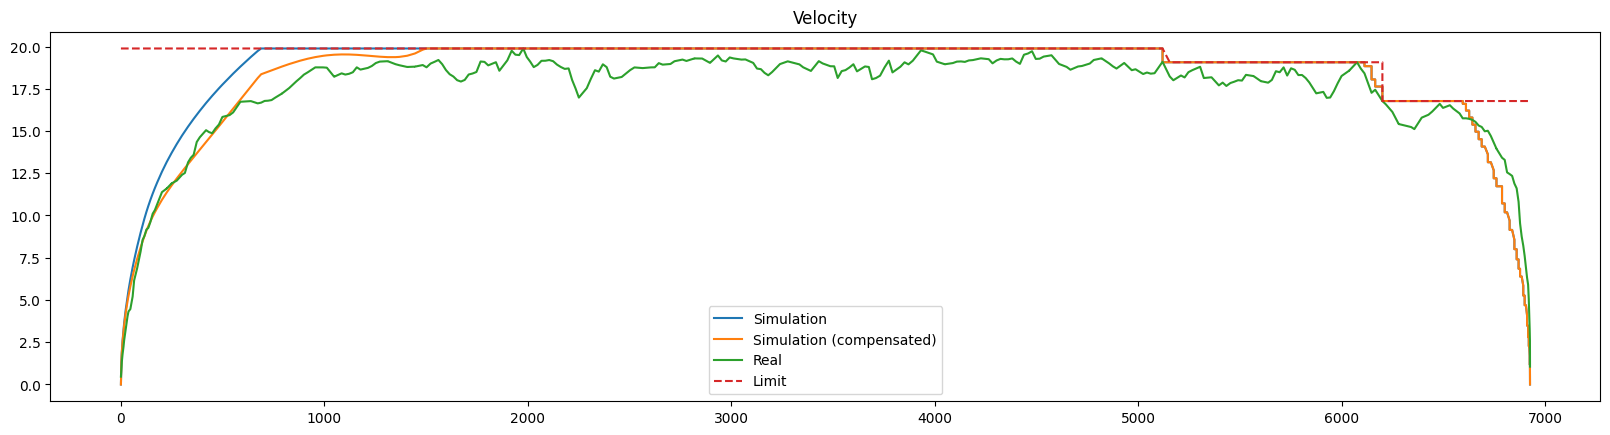

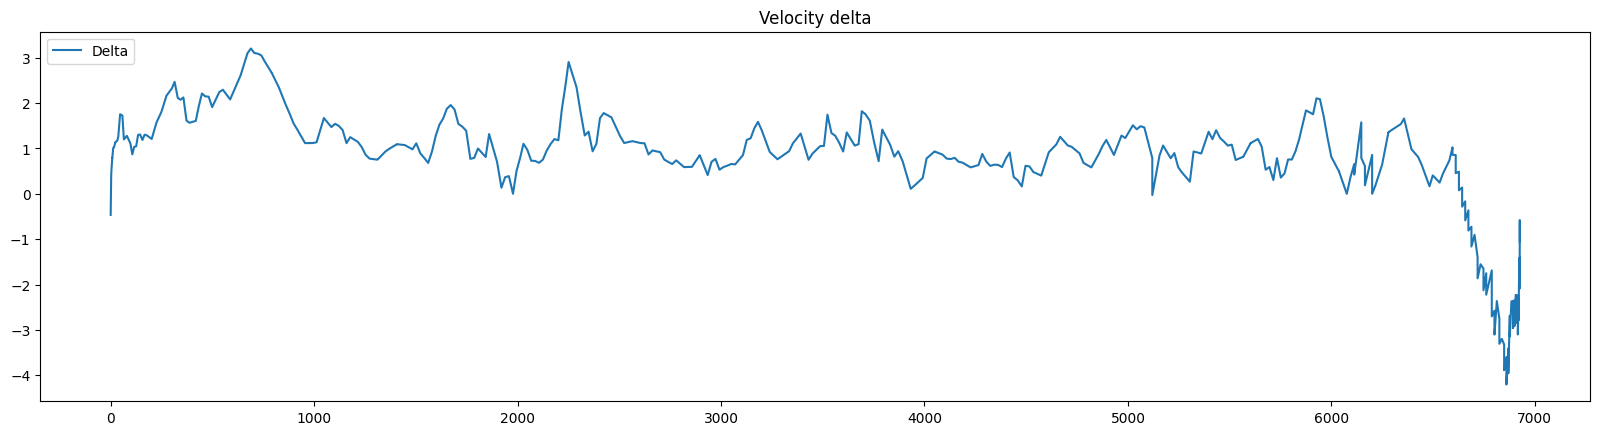

DTW: 490.04267974134484
{'station_start': 'Domašov n.Bystřicí', 'start': 16895, 'station_end': 'Hlubočky-Mar.Údolí', 'end': 19915}


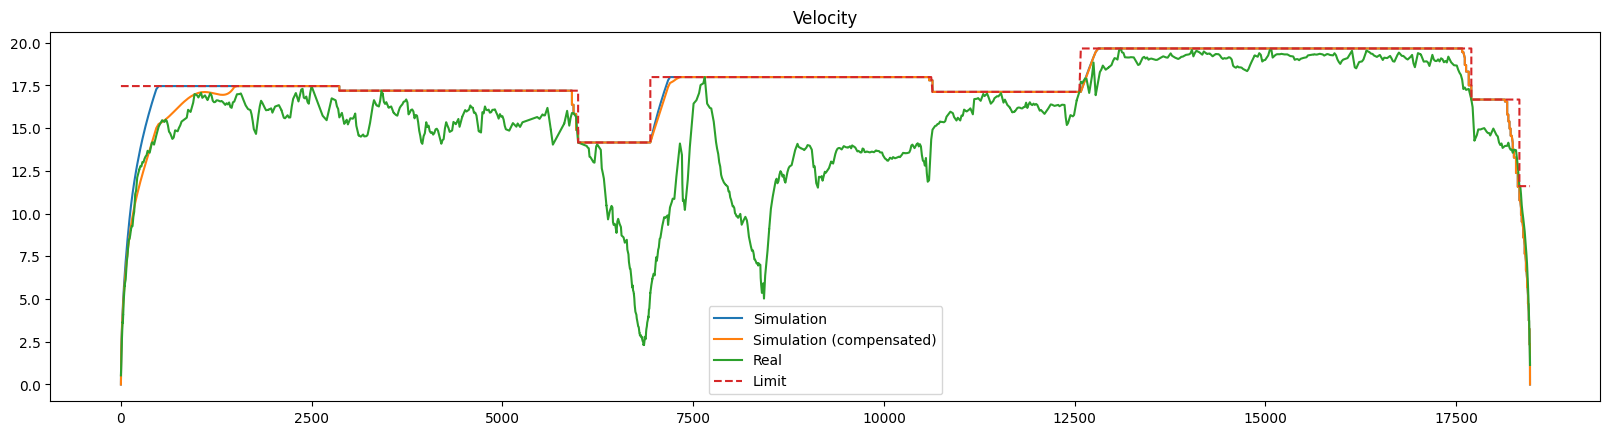

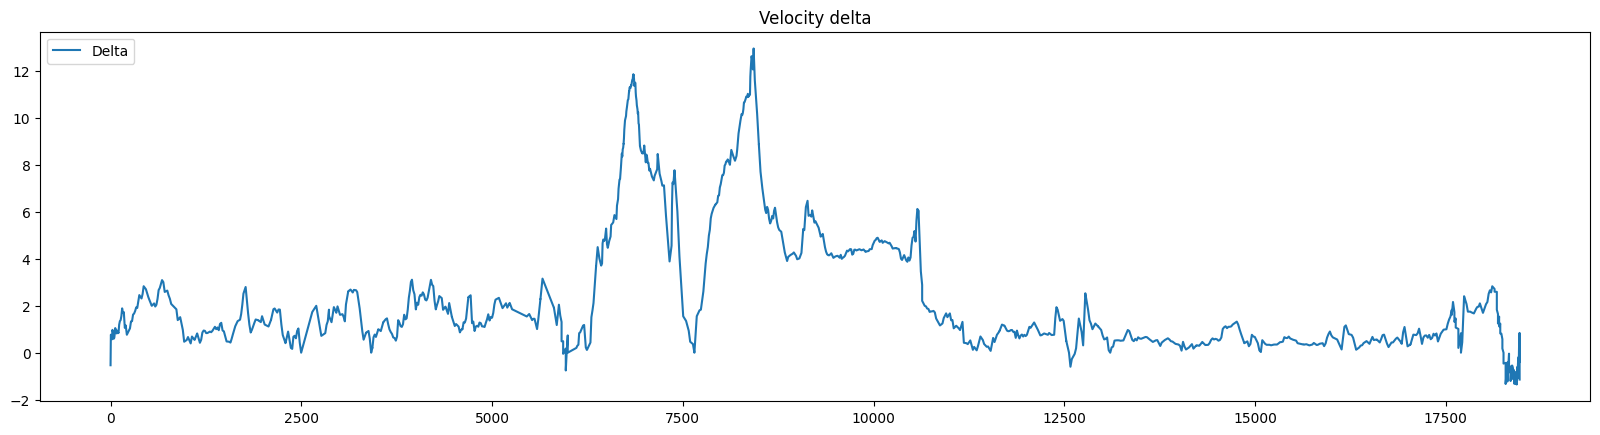

DTW: 5378.299265213612
{'station_start': 'Hlubočky-Mar.Údolí', 'start': 20018, 'station_end': 'Olomouc hl.n.', 'end': 21587}


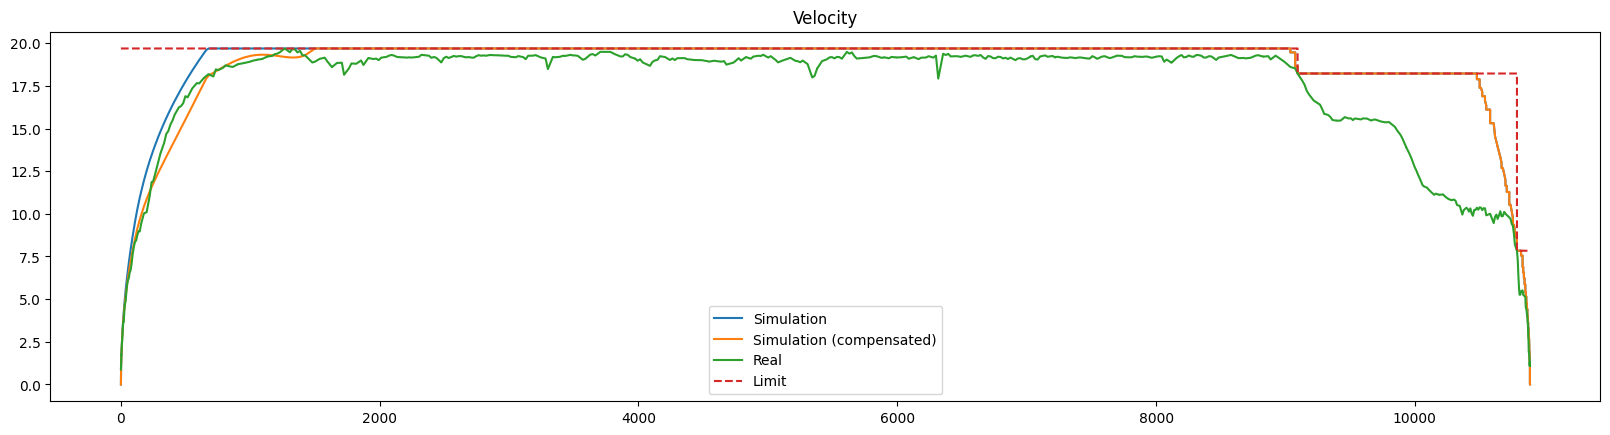

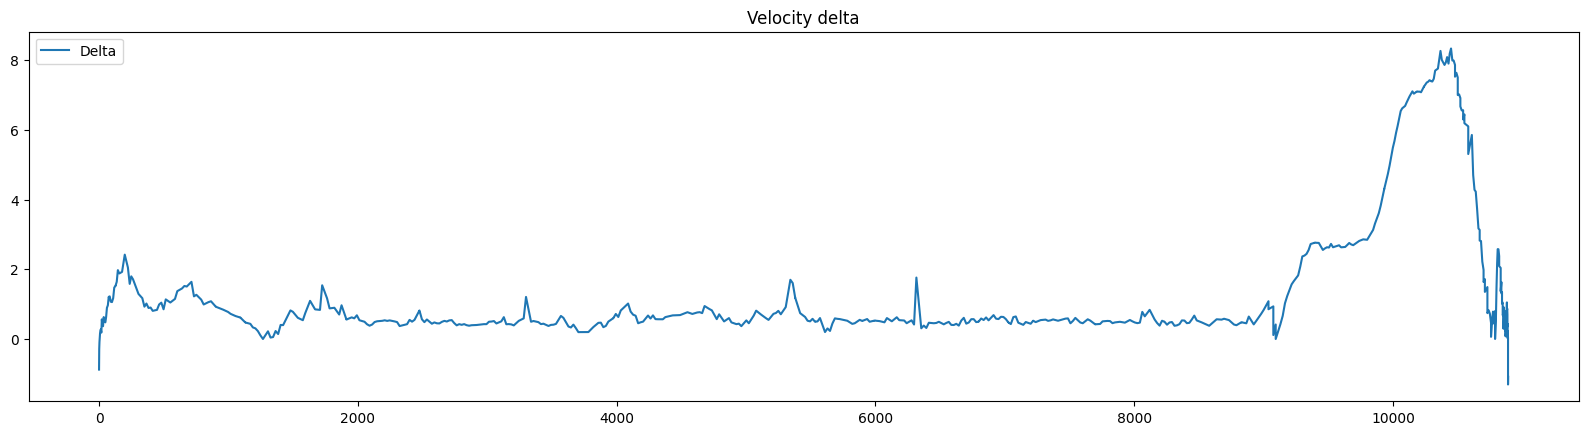

DTW: 591.2526226943585


Map(center=[49.76276779174805, 17.59460163116455], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [11]:
station_ranges = get_station_ranges(df, [
    "Opava východ",
    "Opava západ",
    "Krnov-Cvilín",
    "Krnov",
    "Milotice n.Opavou",
    "Bruntál",
    "Valšov",
    "Lomnice u Rýmařova",
    "Dětřichov n.Bystřicí",
    "Moravský Beroun",
    "Domašov n.Bystřicí",
    "Hlubočky-Mar.Údolí",
    "Olomouc hl.n."
])
print(len(station_ranges))

compare_station_ranges(df, station_ranges)

#### 🚂 Cesta zpět (komplet)

12
{'station_start': 'Olomouc hl.n.', 'start': 1129, 'station_end': 'Hlubočky-Mar.Údolí', 'end': 2578}


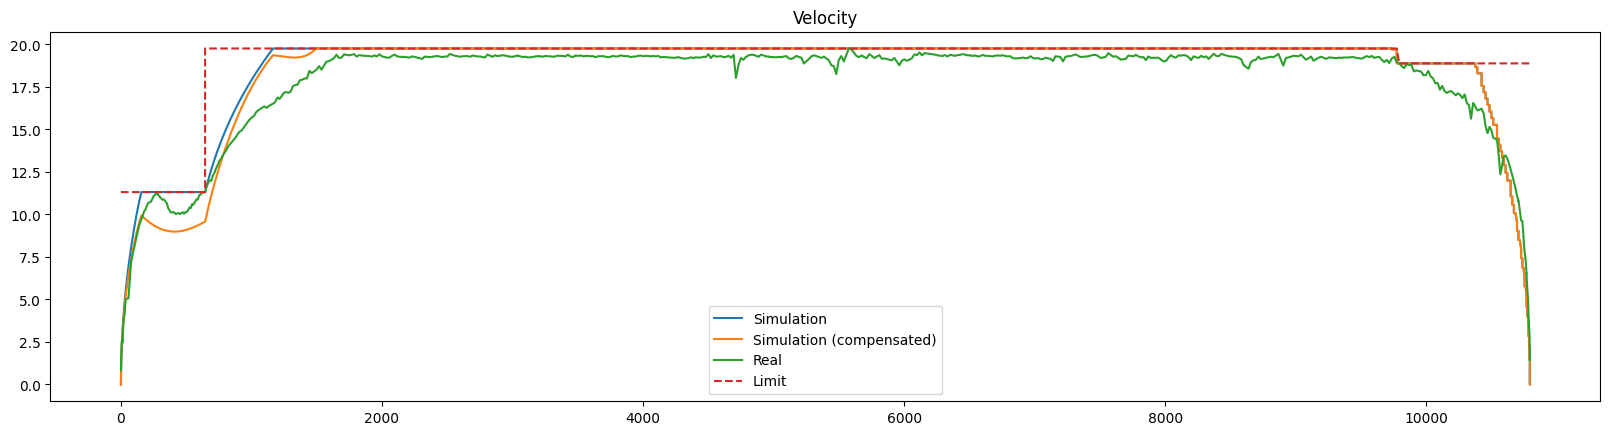

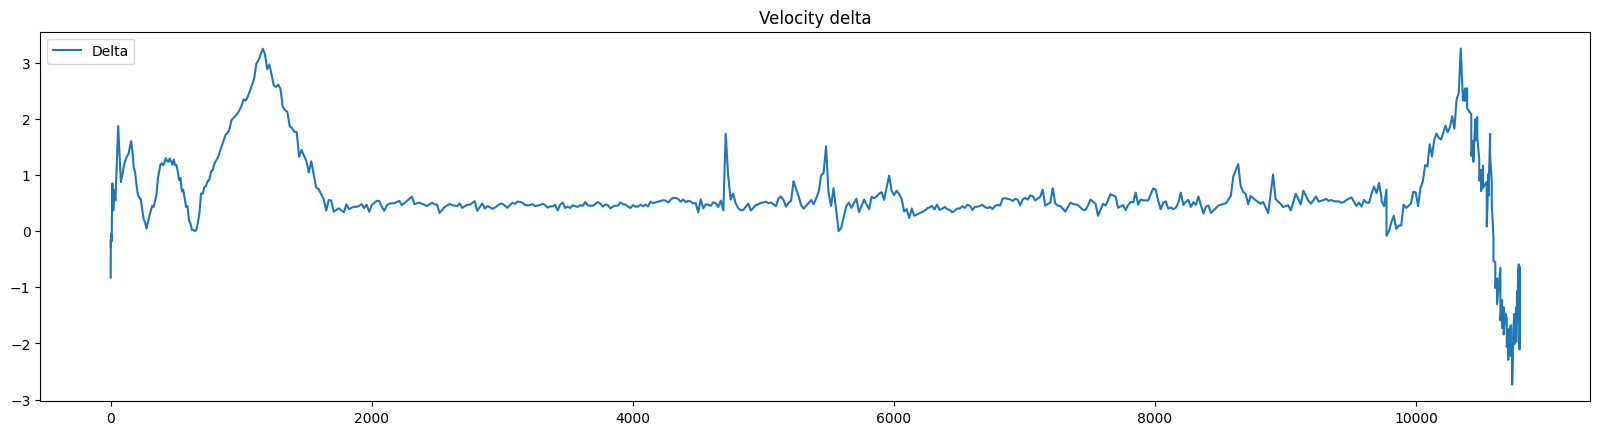

DTW: 576.0687453450394
{'station_start': 'Hlubočky-Mar.Údolí', 'start': 2685, 'station_end': 'Domašov n.Bystřicí', 'end': 5716}


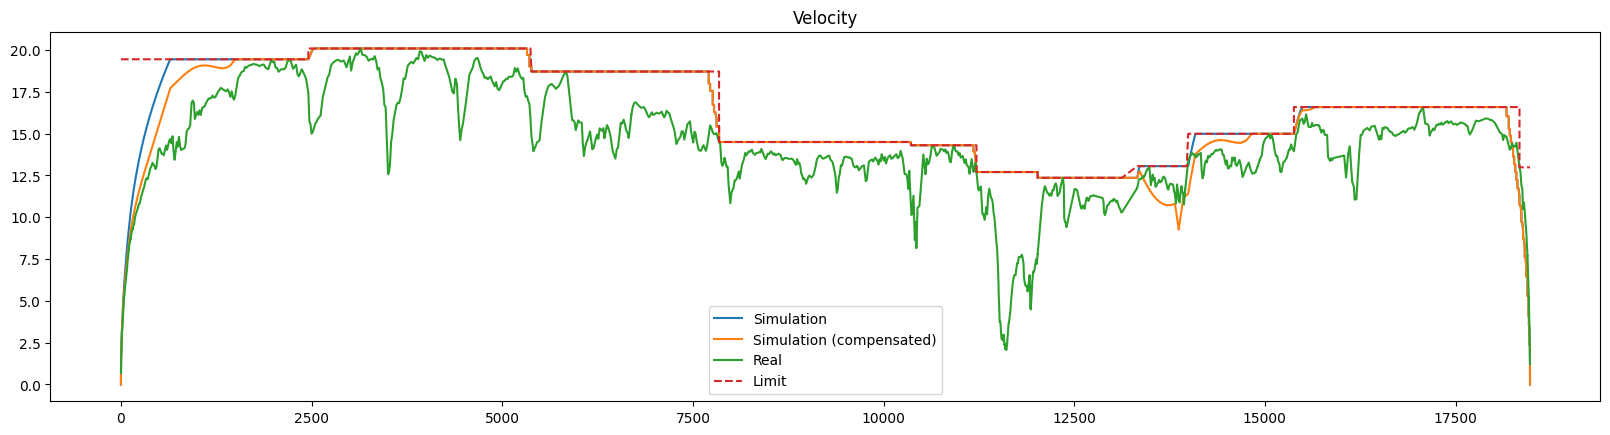

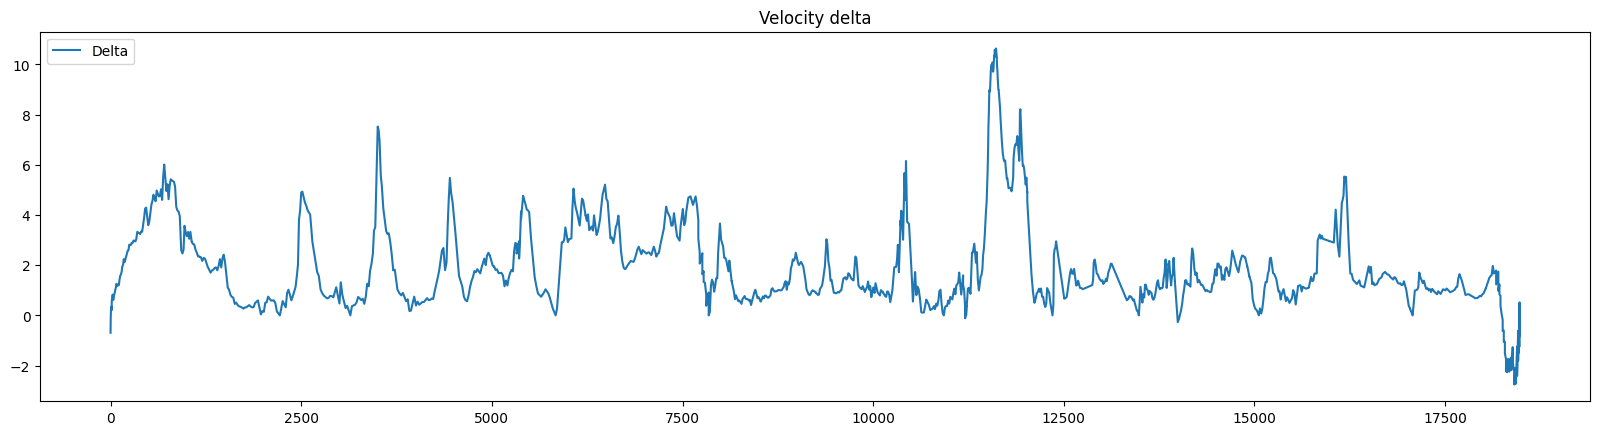

DTW: 3689.603139383626
{'station_start': 'Domašov n.Bystřicí', 'start': 5830, 'station_end': 'Moravský Beroun', 'end': 6795}


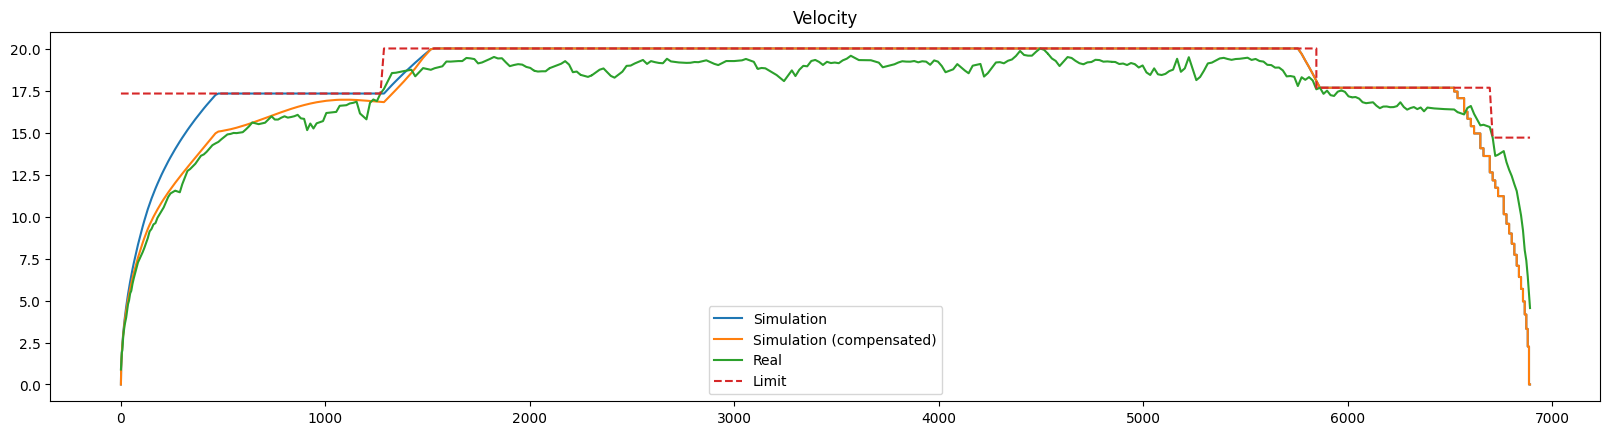

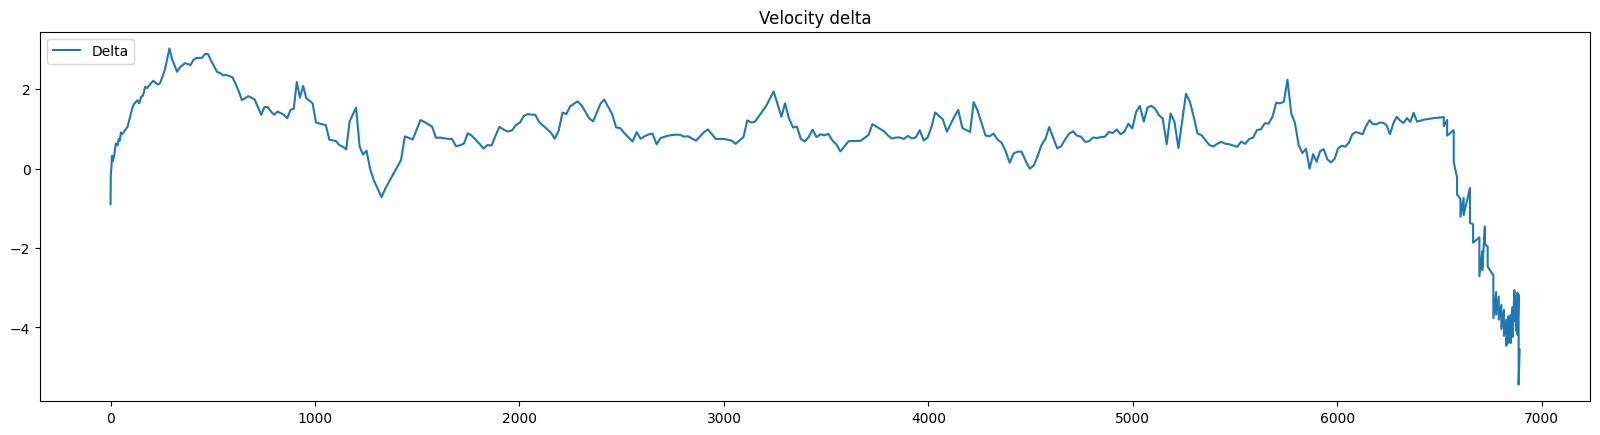

DTW: 344.45550475577244
{'station_start': 'Moravský Beroun', 'start': 6956, 'station_end': 'Dětřichov n.Bystřicí', 'end': 8429}


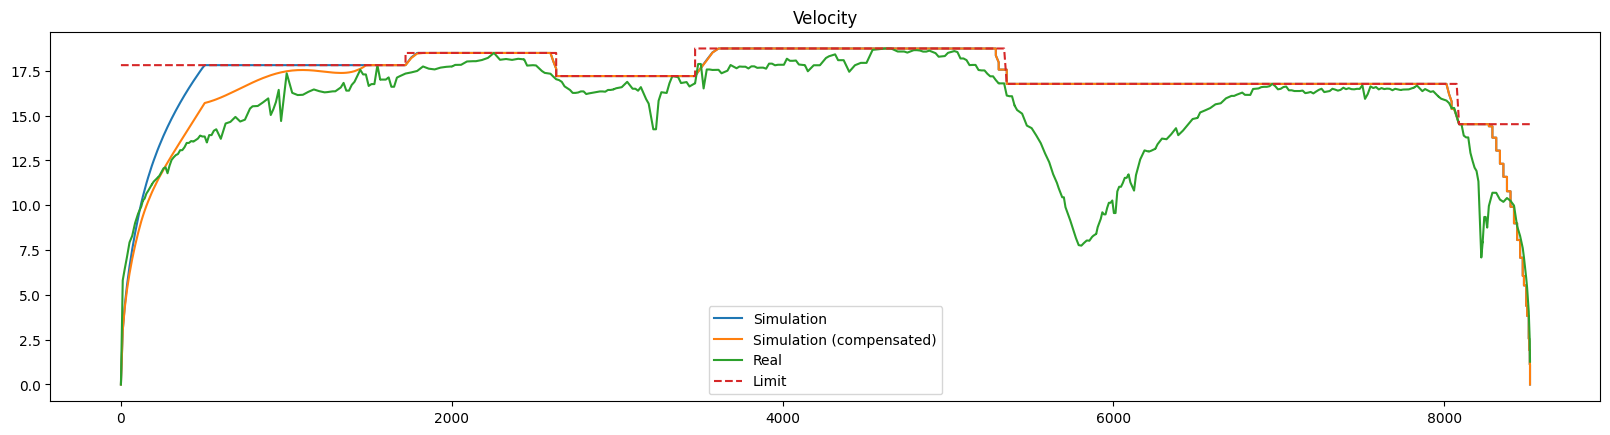

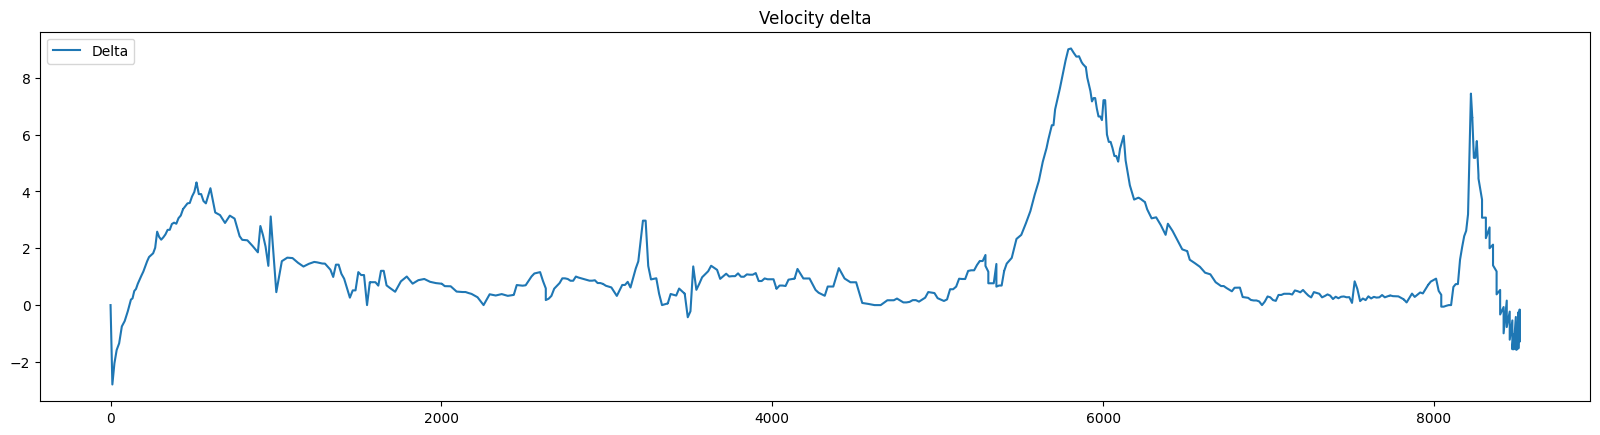

DTW: 1717.2855713608003
{'station_start': 'Dětřichov n.Bystřicí', 'start': 8506, 'station_end': 'Lomnice u Rýmařova', 'end': 9192}


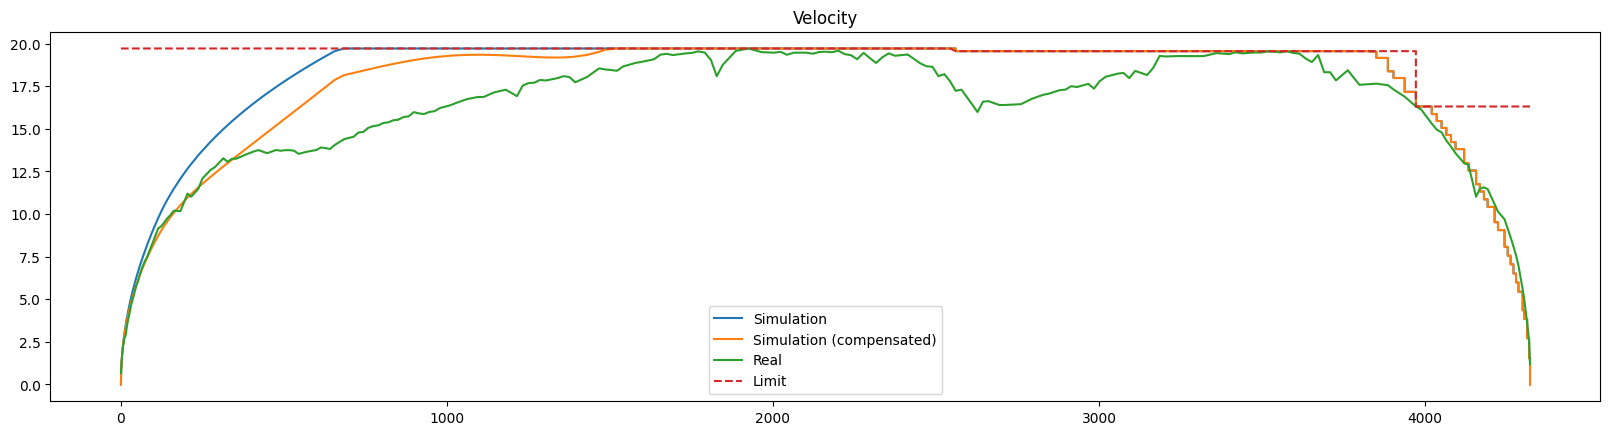

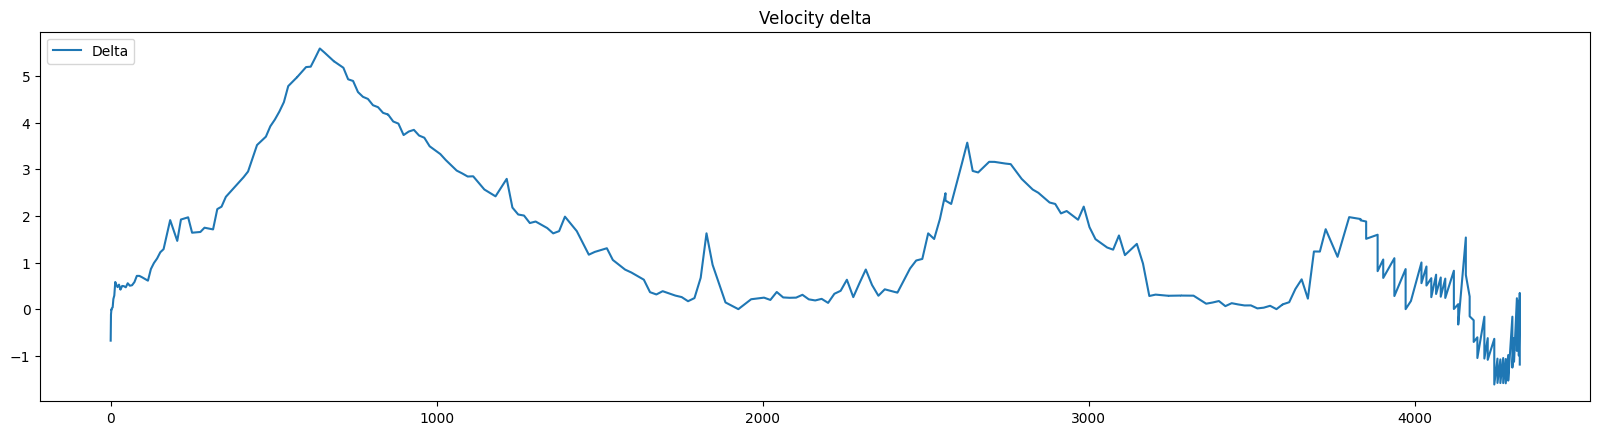

DTW: 340.9564951327678
{'station_start': 'Lomnice u Rýmařova', 'start': 9258, 'station_end': 'Valšov', 'end': 10392}


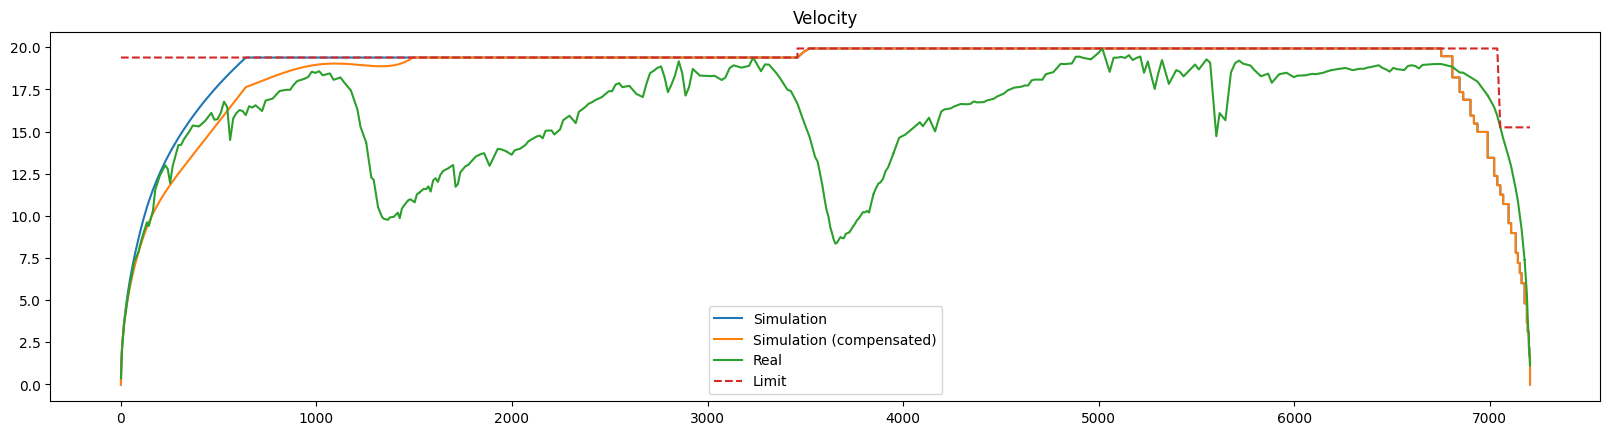

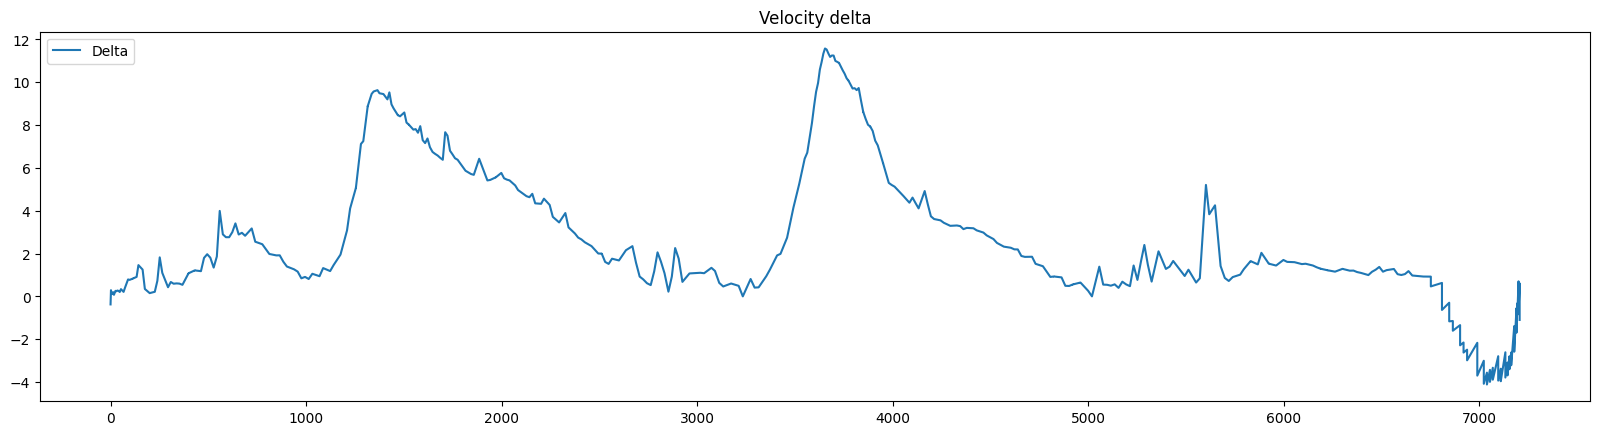

DTW: 1972.9173740448443
{'station_start': 'Valšov', 'start': 10474, 'station_end': 'Bruntál', 'end': 11614}


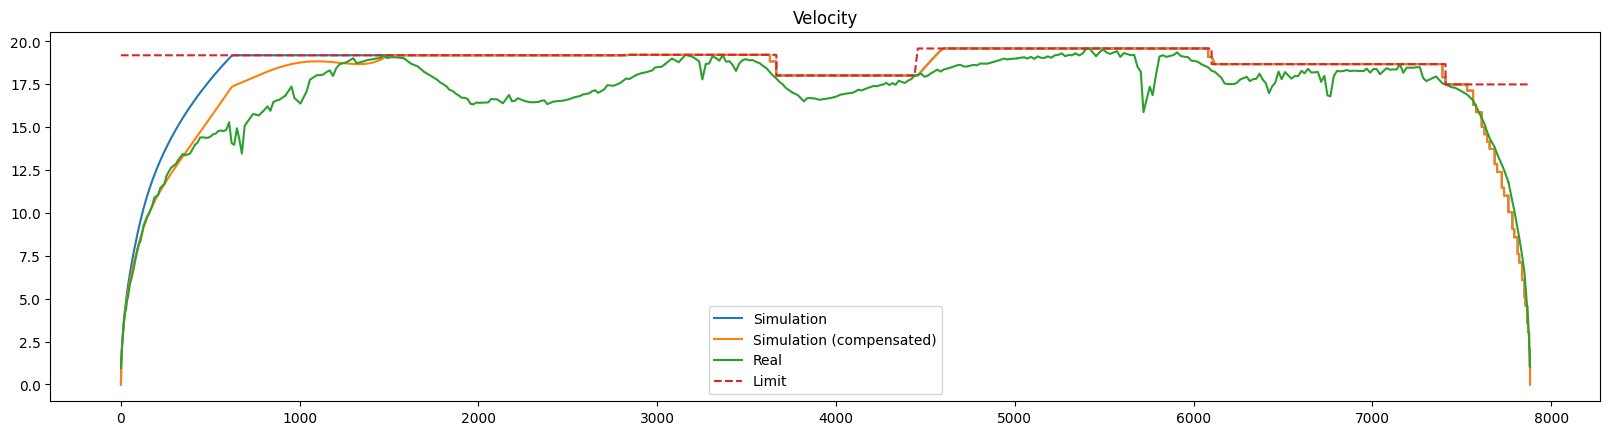

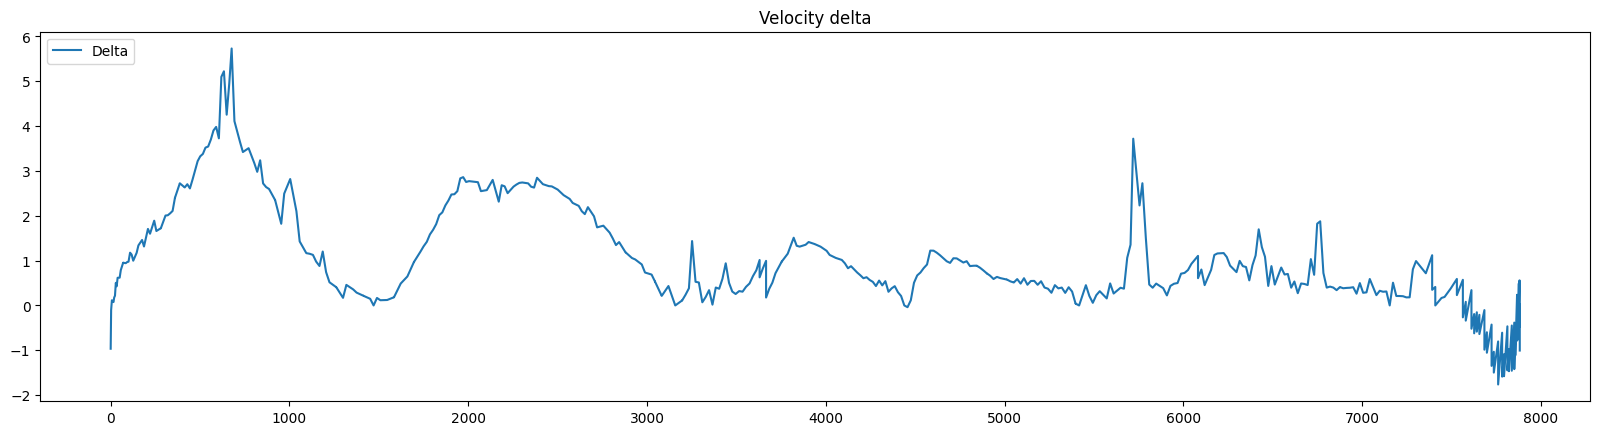

DTW: 698.7024560770516
{'station_start': 'Bruntál', 'start': 11788, 'station_end': 'Milotice n.Opavou', 'end': 13312}


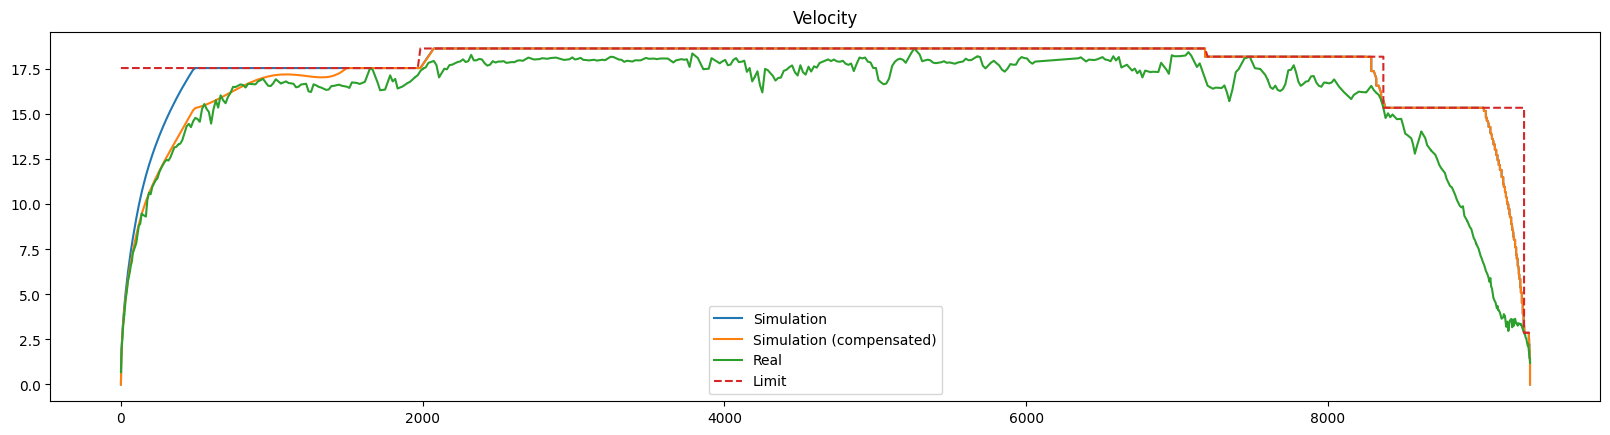

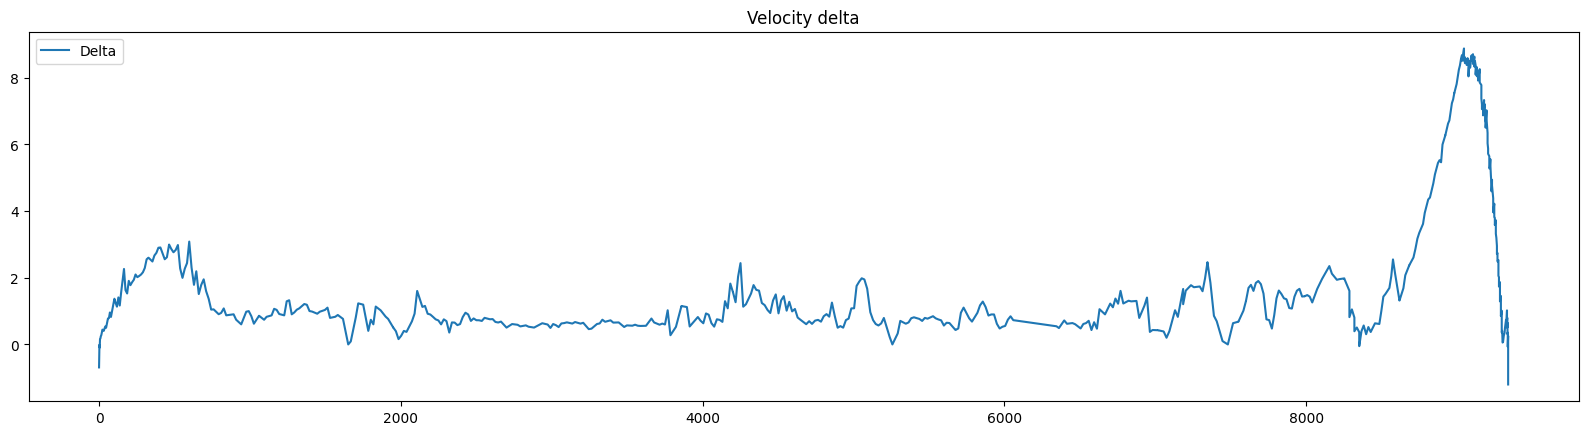

DTW: 648.9957539412802
{'station_start': 'Milotice n.Opavou', 'start': 13403, 'station_end': 'Krnov', 'end': 15313}


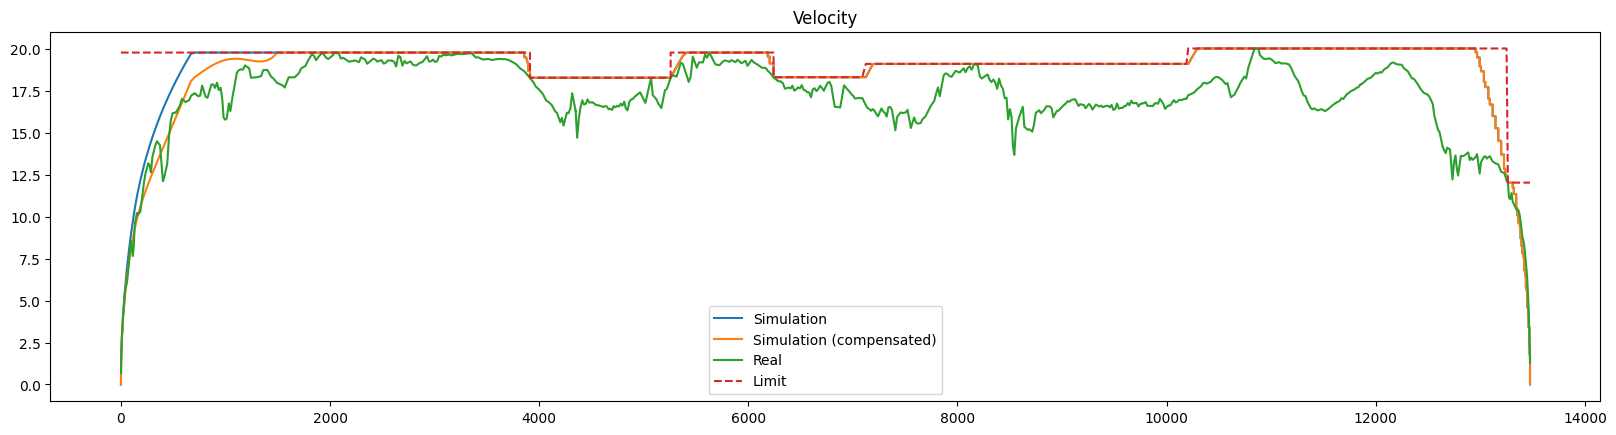

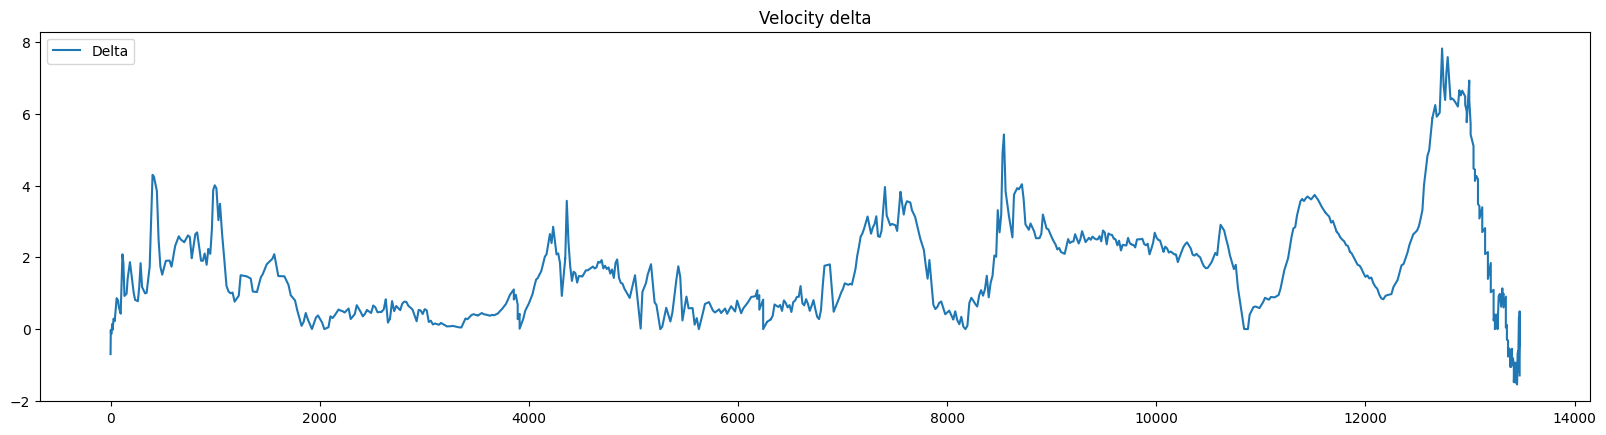

DTW: 1557.4327994354105
{'station_start': 'Krnov', 'start': 17439, 'station_end': 'Krnov-Cvilín', 'end': 17962}


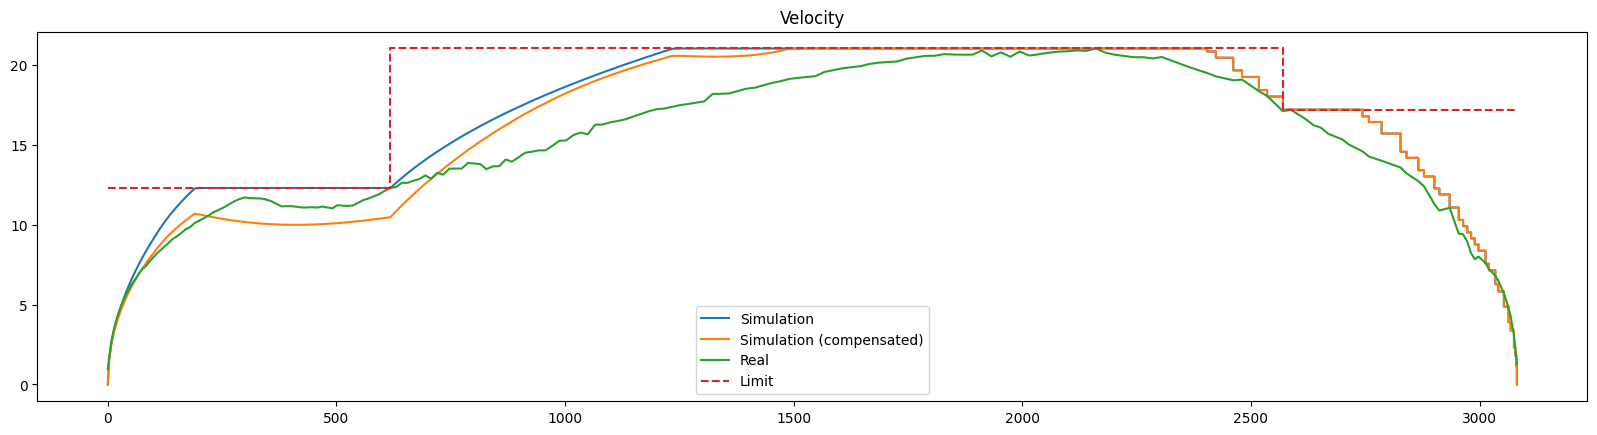

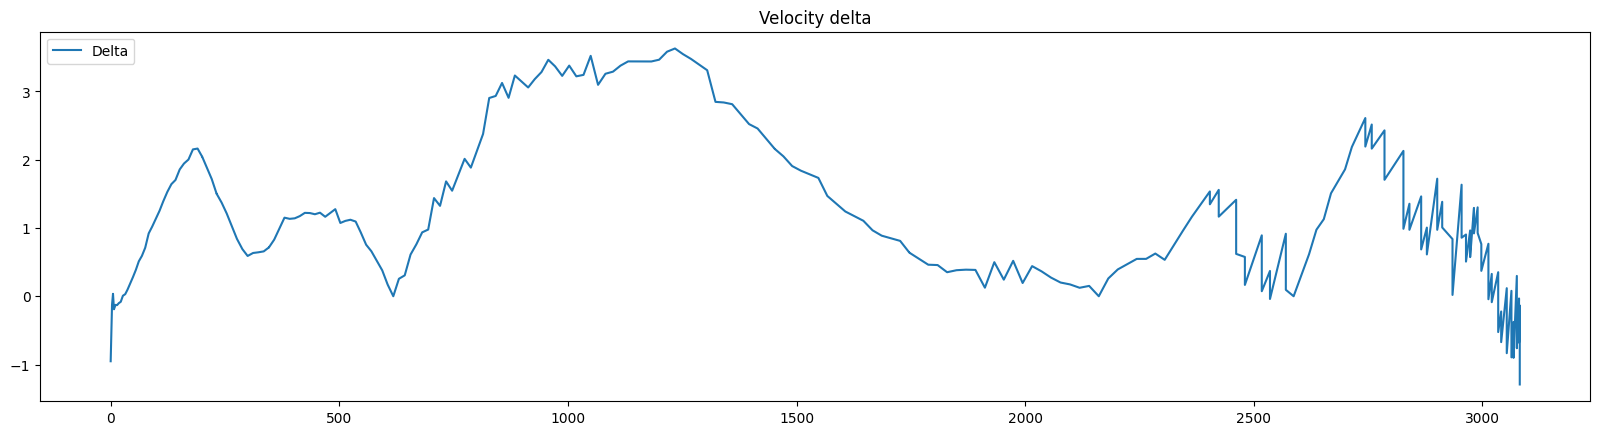

DTW: 73.42805703156561
{'station_start': 'Krnov-Cvilín', 'start': 18070, 'station_end': 'Opava západ', 'end': 20510}


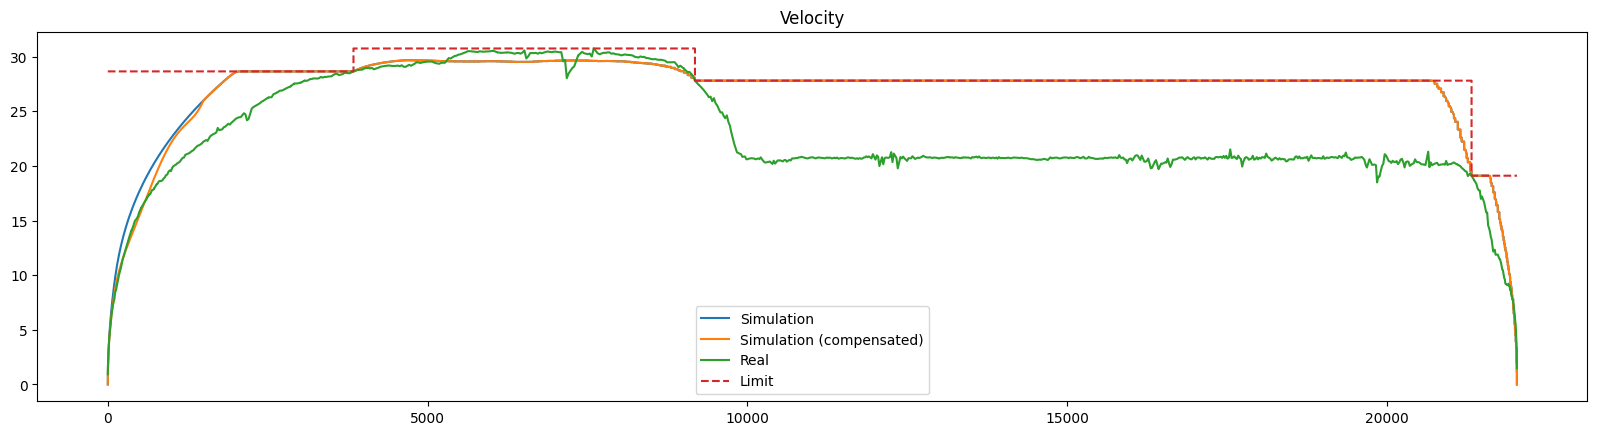

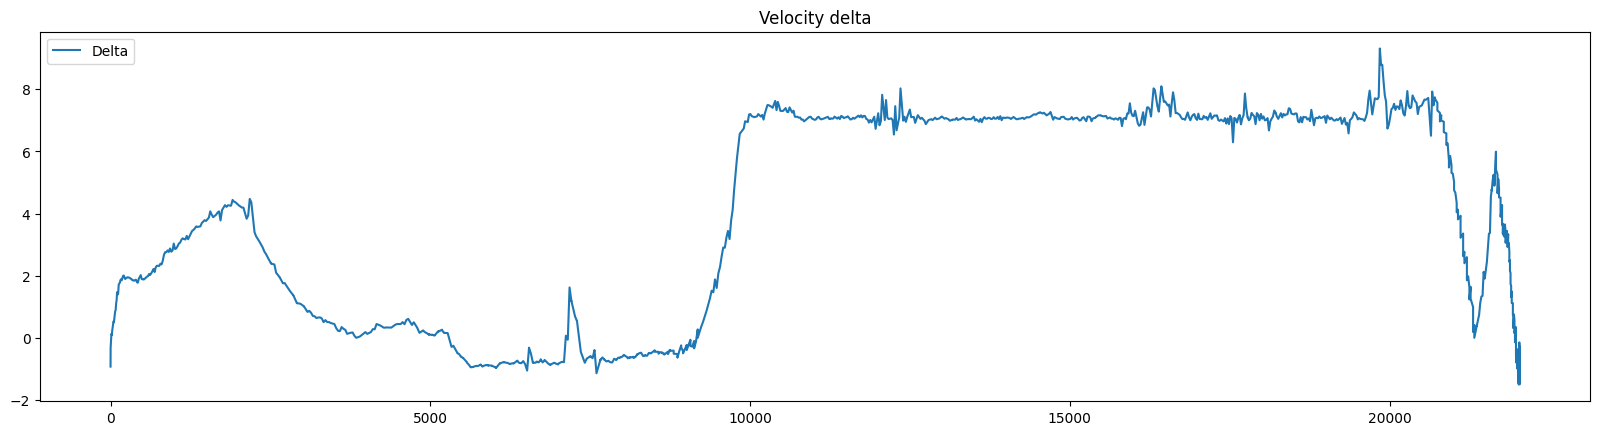

DTW: 1987.2015645330232
{'station_start': 'Opava západ', 'start': 20607, 'station_end': 'Opava východ', 'end': 21325}


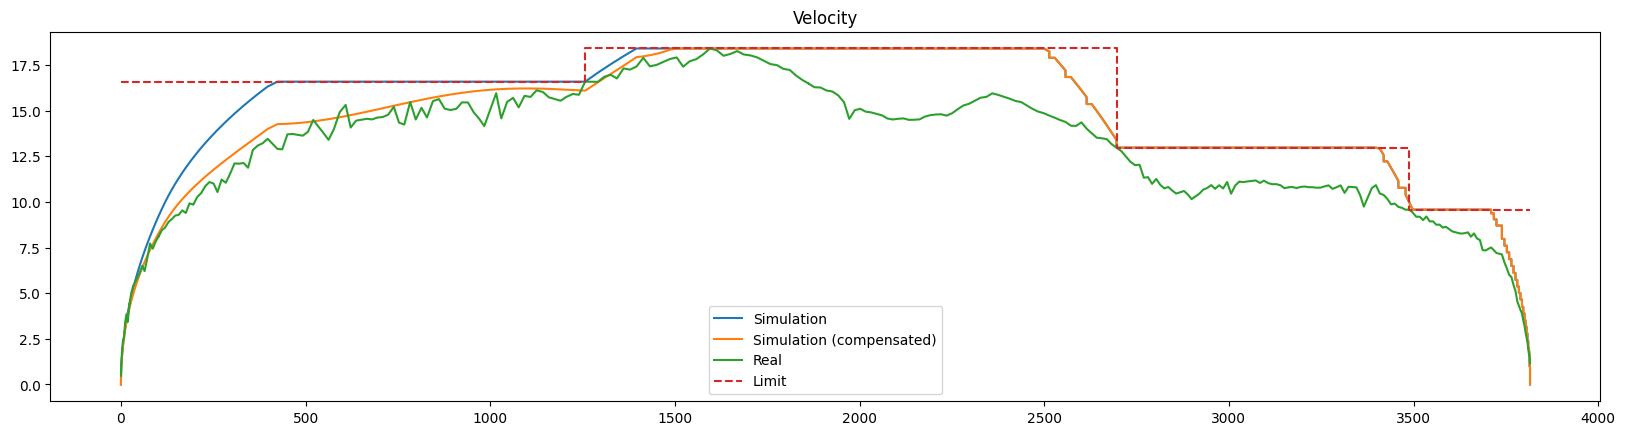

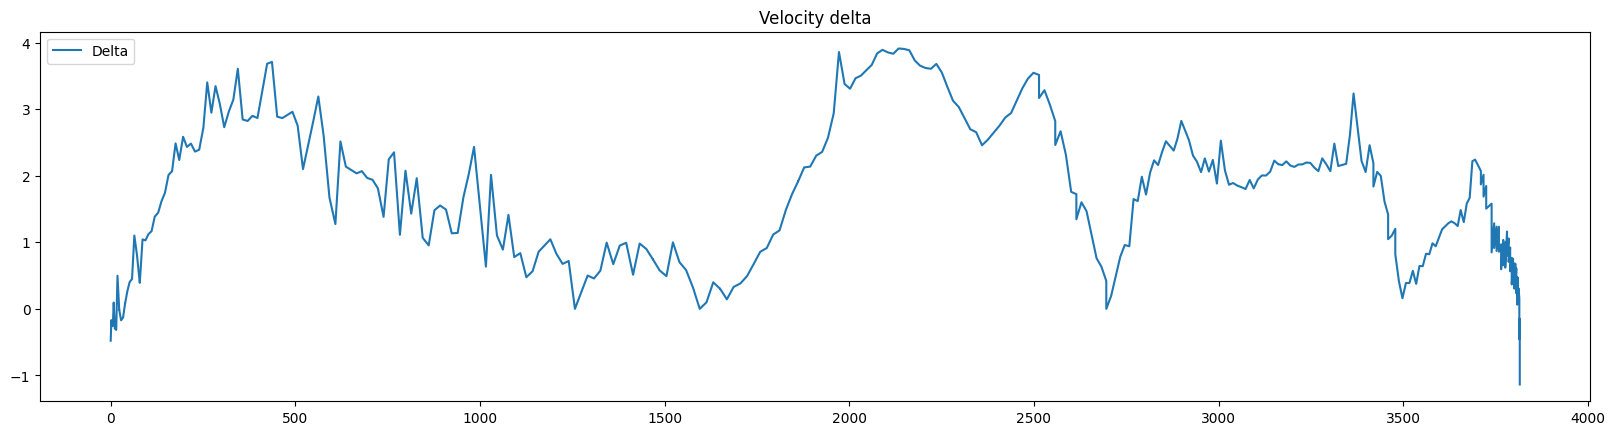

DTW: 142.61583714216533


Map(center=[49.763023376464844, 17.59451961517334], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [12]:
station_ranges = get_station_ranges(df2, [
    "Opava východ",
    "Opava západ",
    "Krnov-Cvilín",
    "Krnov",
    "Milotice n.Opavou",
    "Bruntál",
    "Valšov",
    "Lomnice u Rýmařova",
    "Dětřichov n.Bystřicí",
    "Moravský Beroun",
    "Domašov n.Bystřicí",
    "Hlubočky-Mar.Údolí",
    "Olomouc hl.n."
][::-1])
print(len(station_ranges))

compare_station_ranges(df2, station_ranges)

#### Opava západ ➡️ Krnov-Cvilín

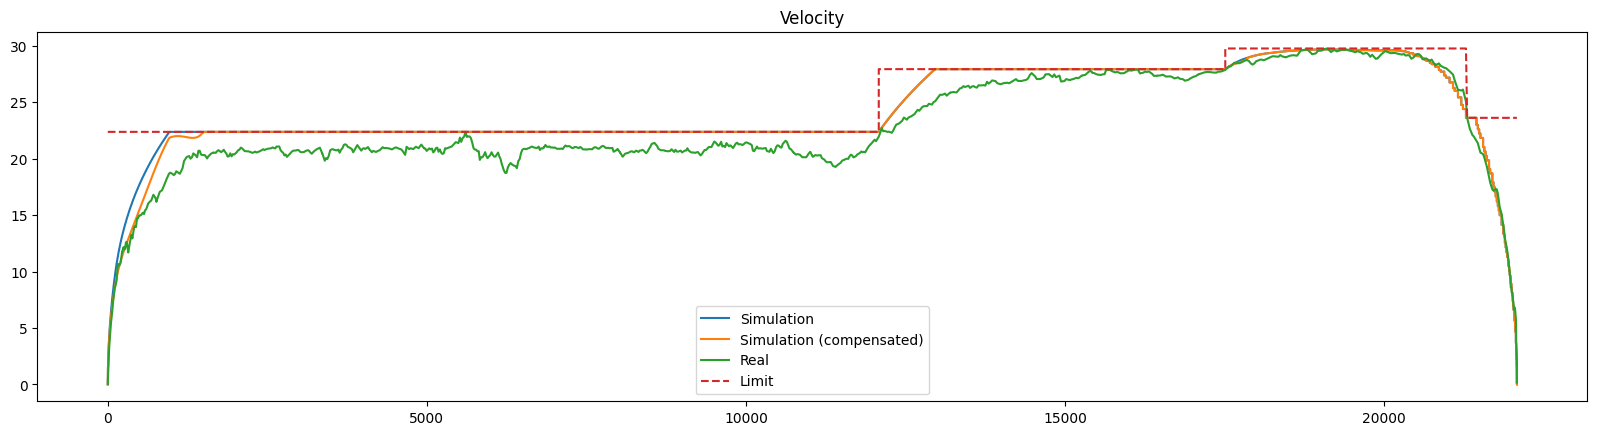

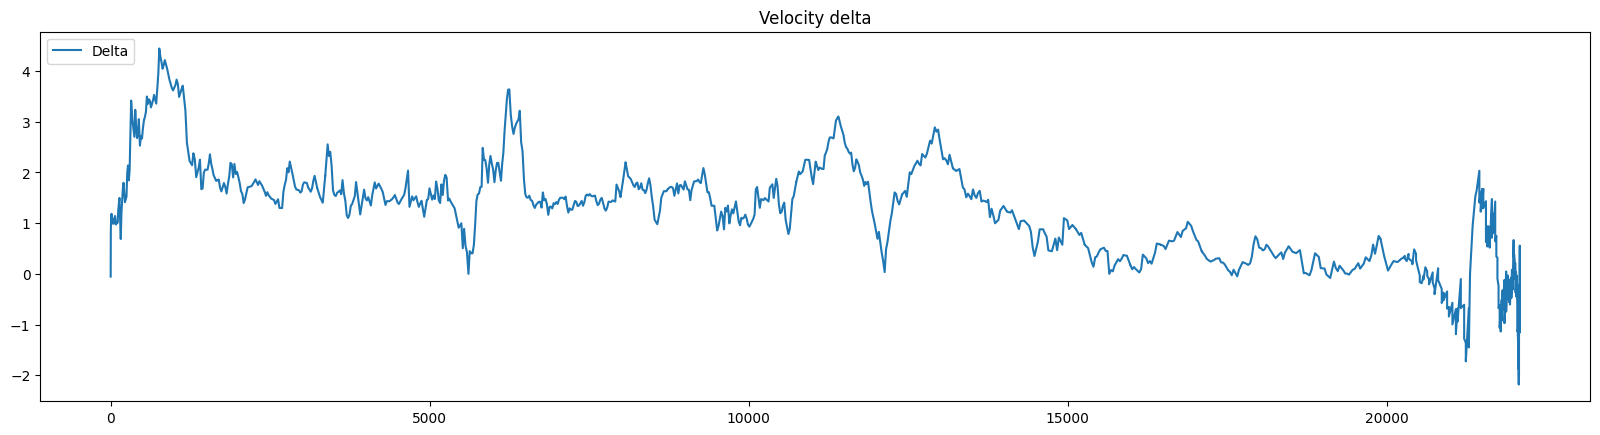

DTW: 1543.6783980248993


Map(center=[50.016578674316406, 17.80017852783203], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [13]:
df_slice = df.loc[1080:3530] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 112.329, "../testing-data/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Krnov-Cvilín ➡️ Krnov

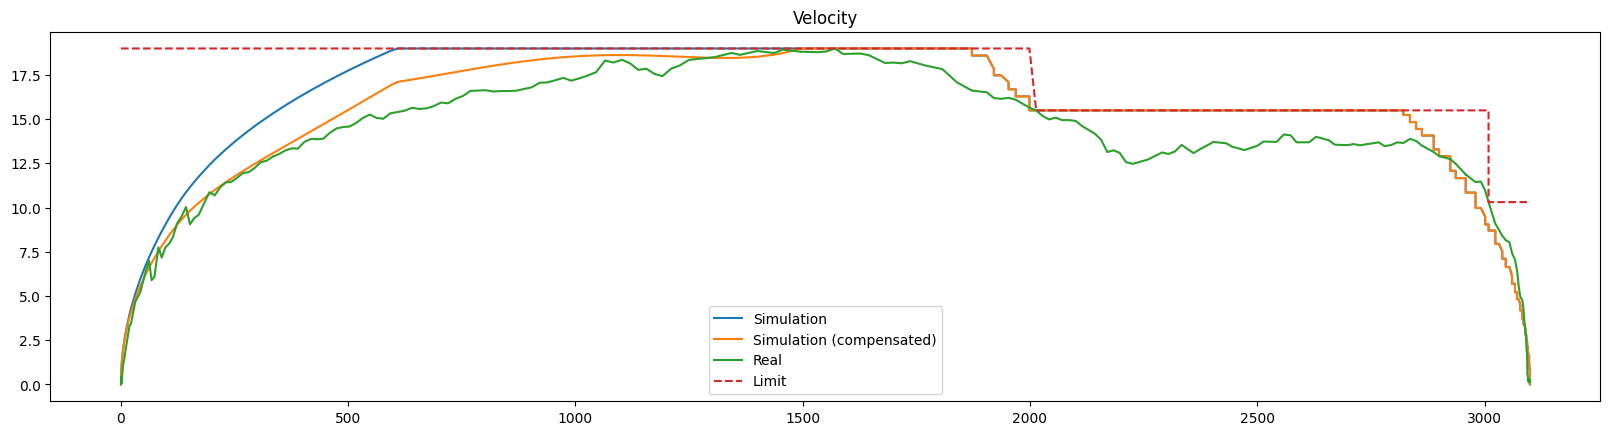

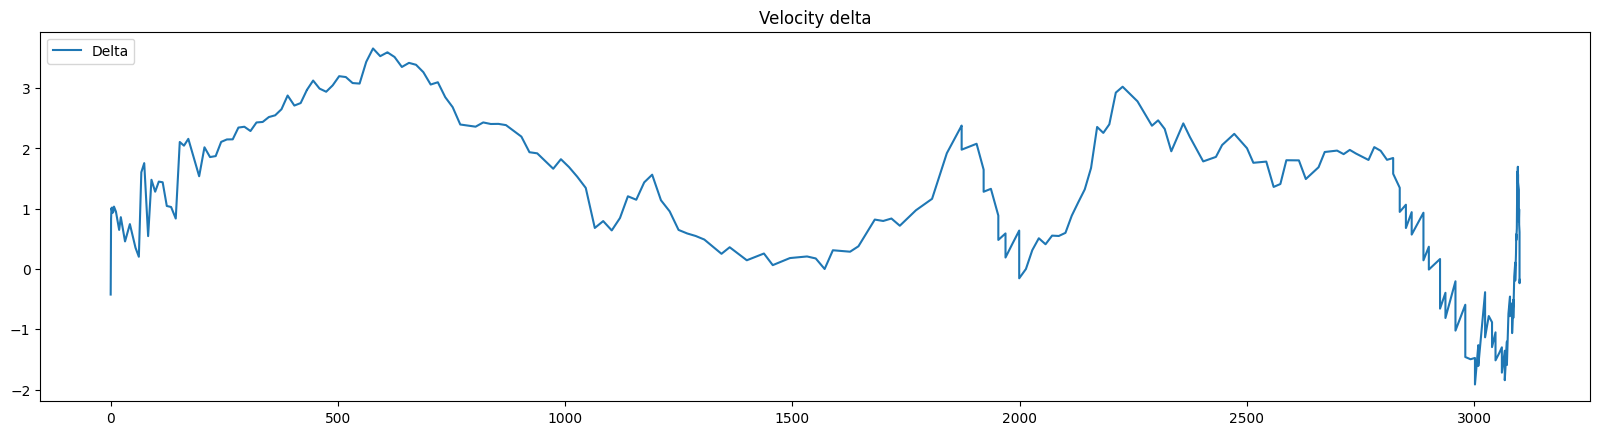

DTW: 130.97233723528032


Map(center=[50.09158134460449, 17.697911262512207], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [14]:
df_slice = df.loc[3680:4280] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 90.213, "../testing-data/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Krnov ➡️ Milotice n.Opavou

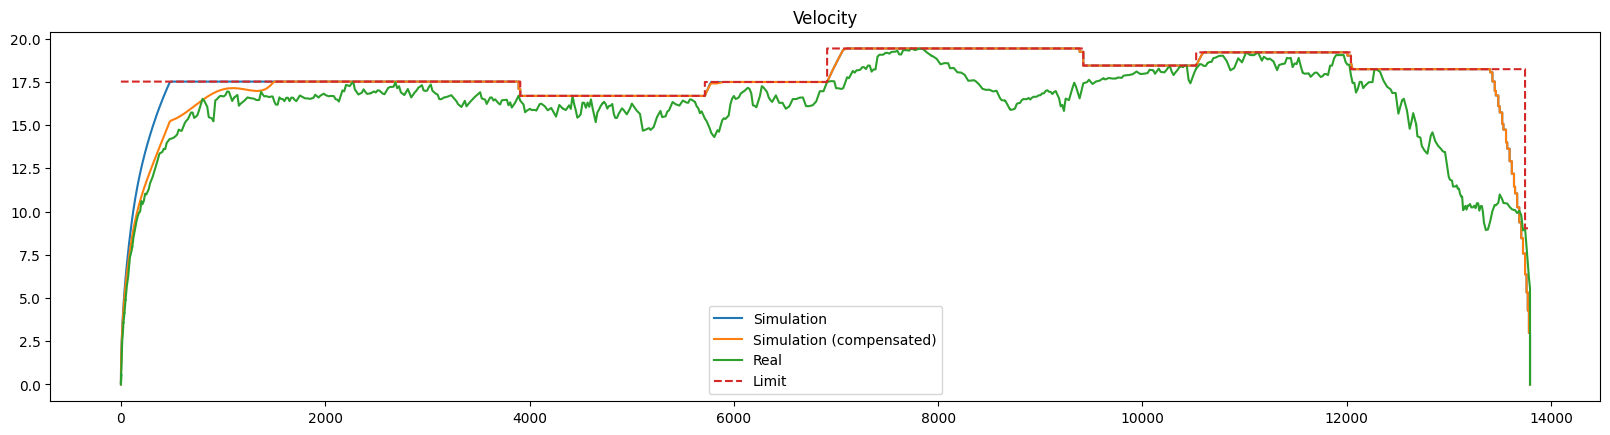

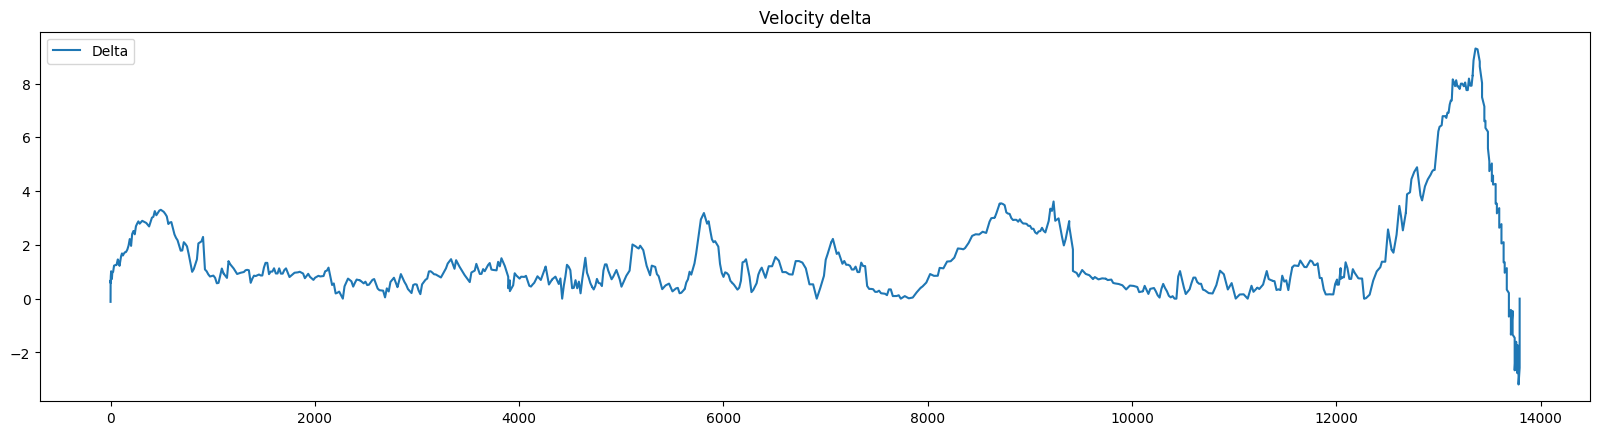

DTW: 1324.0352418746536


Map(center=[50.0518741607666, 17.620561599731445], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [15]:
df_slice = df.loc[5570:7770] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 87.056, "../testing-data/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-milotice.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí

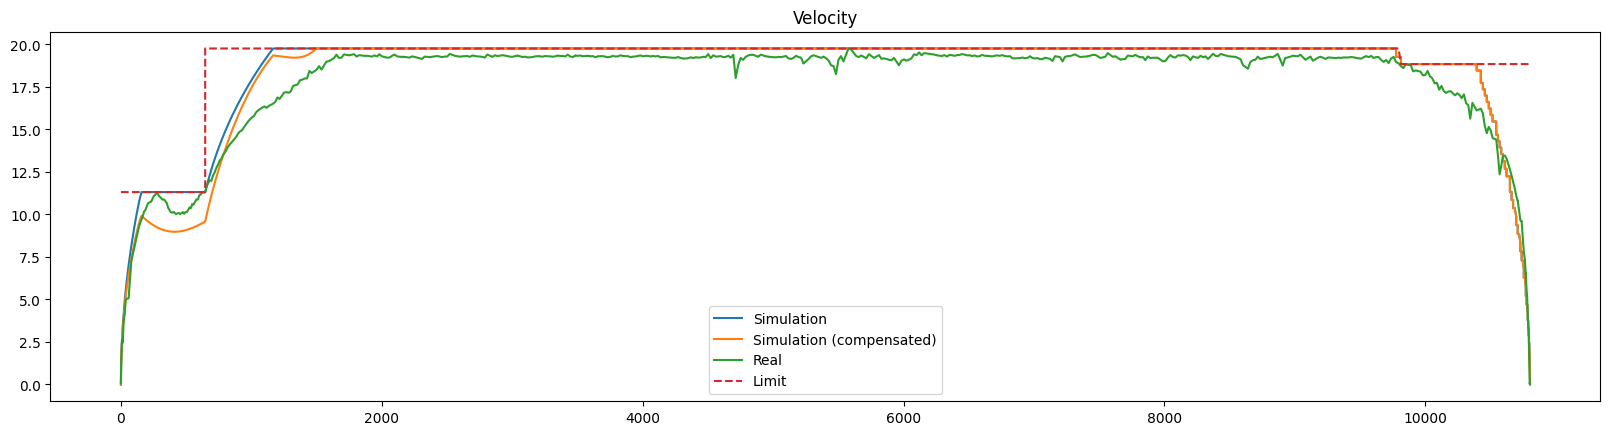

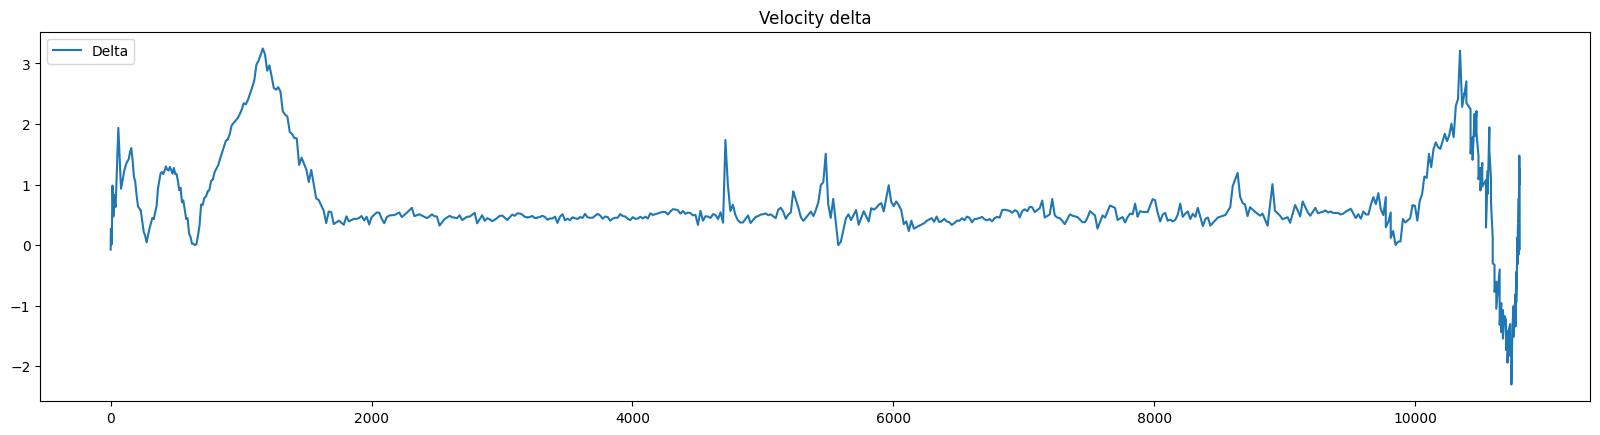

DTW: 557.5809262780336


Map(center=[49.602705001831055, 17.336840629577637], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [16]:
df_slice = df2.loc[1120:2600] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 0.440, "../testing-data/velocity-data/310-pj.json", True)
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_09-04-10_olomouc-hlubocky.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí

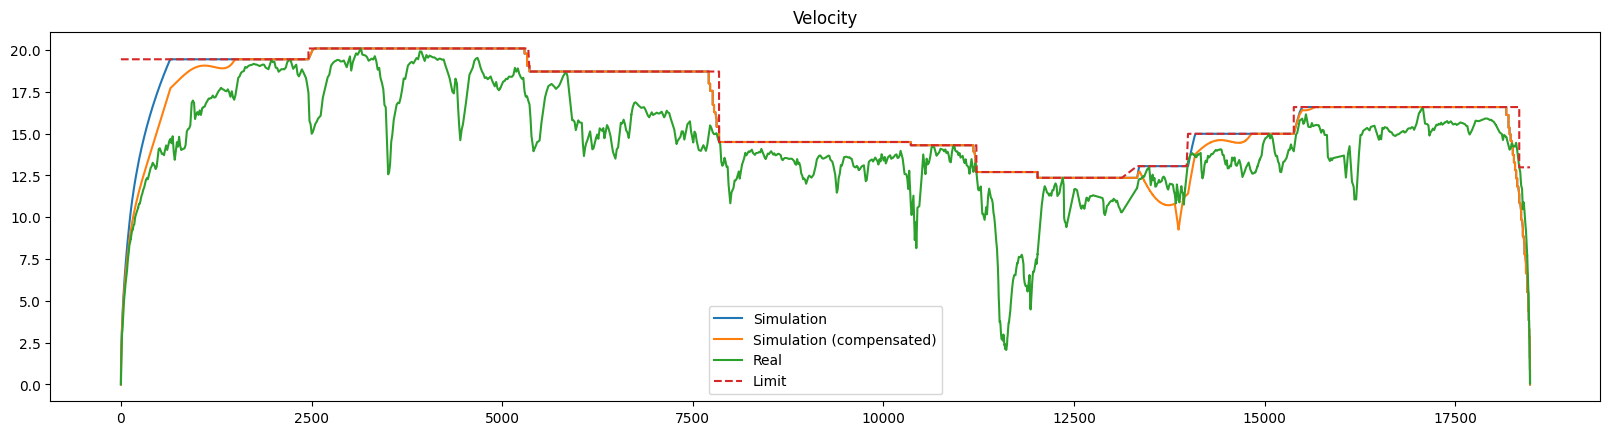

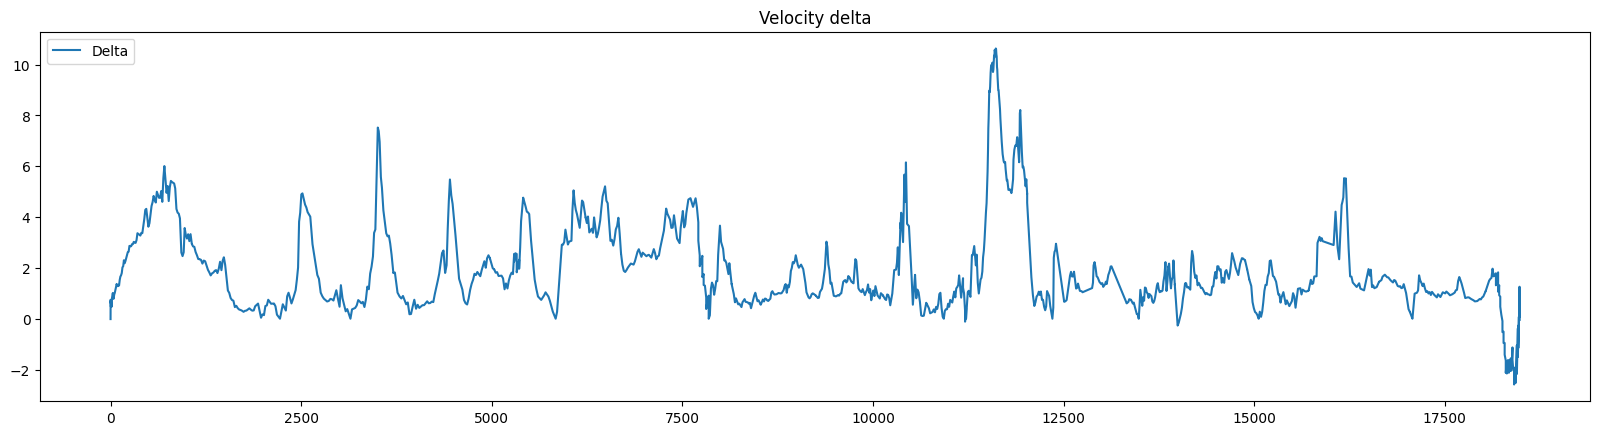

DTW: 3899.3150369360224


Map(center=[49.67659950256348, 17.419564247131348], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [17]:
df_slice = df2.loc[2670:5730] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 10.846, "../testing-data/velocity-data/310-pj.json", True)
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_09-04-10_hlubocky-domasov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Milotice n.Opavou ➡️ Bruntál (☠️ noisy data)

In [18]:
# df_slice = df.loc[8335:9787] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 73.260, "../testing-data/velocity-data/310-pj.json")

In [19]:
# output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_milotice-bruntal.geojson"
# if PREP_GEOJSONS:
#     prep({
#         # "input": "NOT NEEDED",
#         "output": output_geojson,
#         "host": "localhost",
#         "dbname": "railway_mapdb",
#         "dbuser": "postgres",
#         "dbpass": "mysecretpassword",
#         "dbtable": "train_testing_data"
#     }, df=df_slice)

In [20]:
# importlib.reload(tconsumption)

# processed_sections.append({"df": df_slice, "geojson": output_geojson})
# compare_data(
#     df_slice,
#     output_geojson
# )

#### Bruntál ➡️ Valšov (☠️ noisy data)

In [21]:
# df_slice = df.loc[10100:10300] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 56.370, "../testing-data/velocity-data/310-pj.json")

In [22]:
# output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_bruntal-valsov.geojson"
# if PREP_GEOJSONS:
#     prep({
#         # "input": "NOT NEEDED",
#         "output": output_geojson,
#         "host": "localhost",
#         "dbname": "railway_mapdb",
#         "dbuser": "postgres",
#         "dbpass": "mysecretpassword",
#         "dbtable": "train_testing_data"
#     }, df=df_slice)

In [23]:
# importlib.reload(tconsumption)

# processed_sections.append({"df": df_slice, "geojson": output_geojson})
# compare_data(
#     df_slice,
#     output_geojson
# )

### 📱 Data z telefonu

In [24]:
# Find two stations (ramp up and ramp down)
df_phone_loc = pd.read_csv("../testing-data/seidl-telefon/Location.csv", delimiter=",")[220:860]
df_phone_loc.reset_index(inplace=True, drop=True)
start_time = df_phone_loc["time"].iloc[0]
stop_time = df_phone_loc["time"].iloc[-1]

# Find acceleration in the same timeframe
# (sampling rate different - that's is why like this)
df_phone_acc = pd.read_csv("../testing-data/seidl-telefon/Accelerometer.csv", delimiter=",")
df_phone_acc = df_phone_acc[(df_phone_acc["time"] >= start_time) & (df_phone_acc["time"] <= stop_time)]
df_phone_acc.reset_index(inplace=True, drop=True)
df_phone_acc

time  seconds_elapsed         z         y         x
0      1695978715934436000       202.310436 -0.022504  0.057136  0.004057
1      1695978715953393400       202.329393  0.001695  0.057180  0.008538
2      1695978715972351000       202.348351  0.003605  0.048180 -0.007852
3      1695978715991308300       202.367308  0.022114  0.032709  0.027355
4      1695978716010265900       202.386266 -0.015833  0.031453 -0.031993
...                    ...              ...       ...       ...       ...
33626  1695979352841621000       839.217621  0.028306  0.154919  0.006014
33627  1695979352860578300       839.236578  0.001878  0.145120  0.012852
33628  1695979352879535600       839.255536  0.018169  0.189503 -0.011000
33629  1695979352898493000       839.274493  0.015572  0.218727 -0.005773
33630  1695979352917450000       839.293450  0.008195  0.225367  0.018014

[33631 rows x 5 columns]

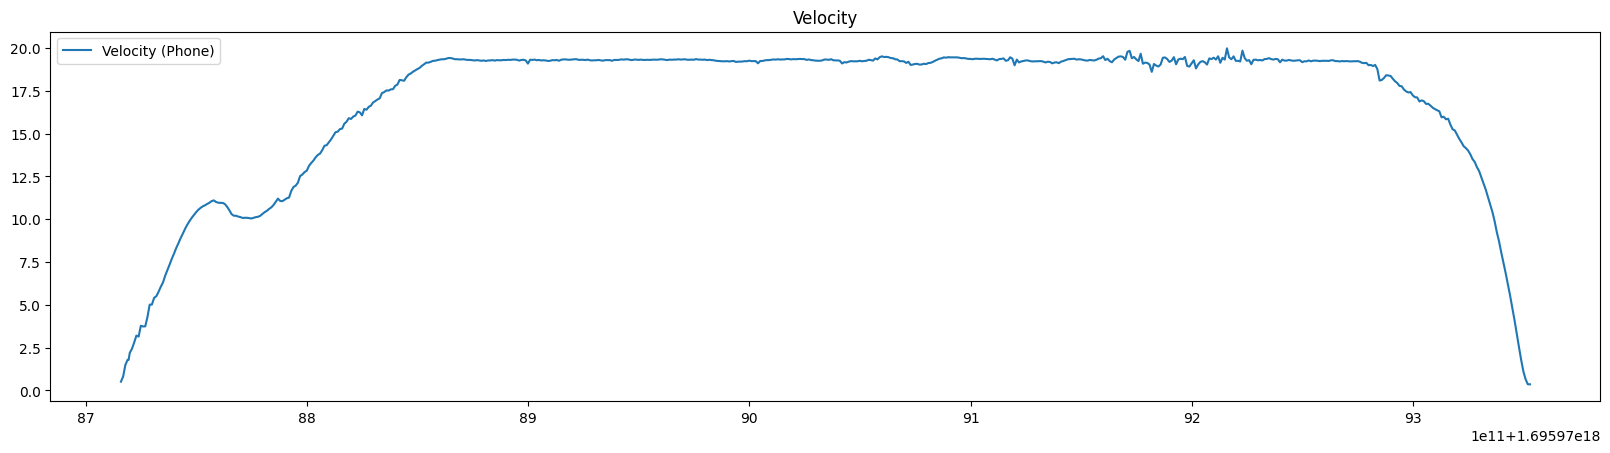

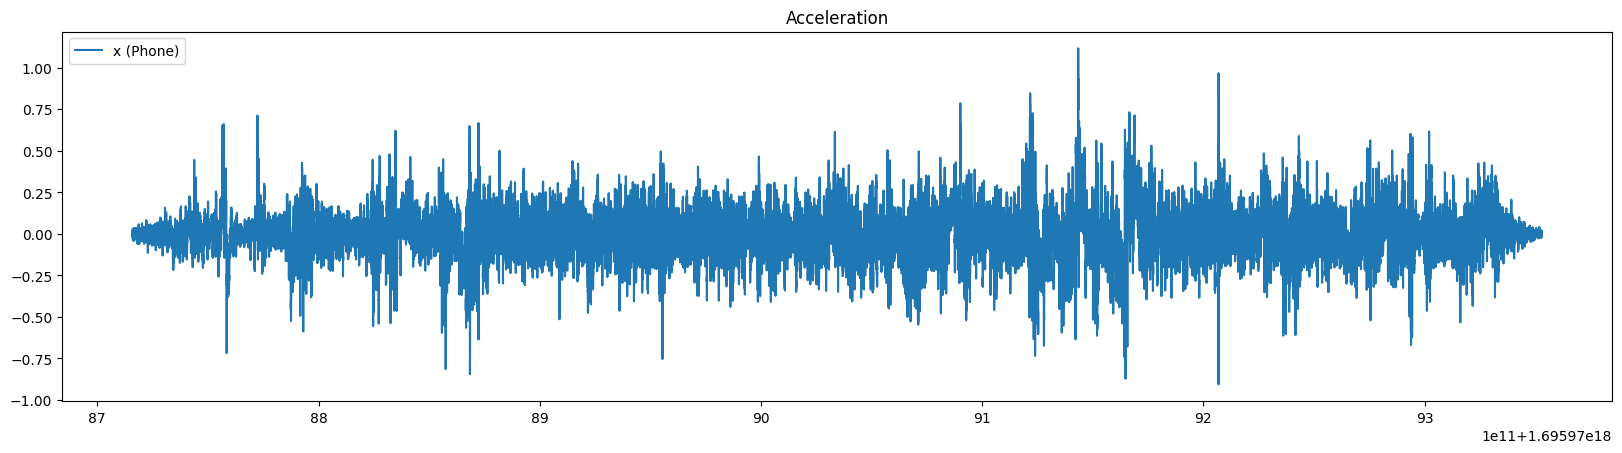

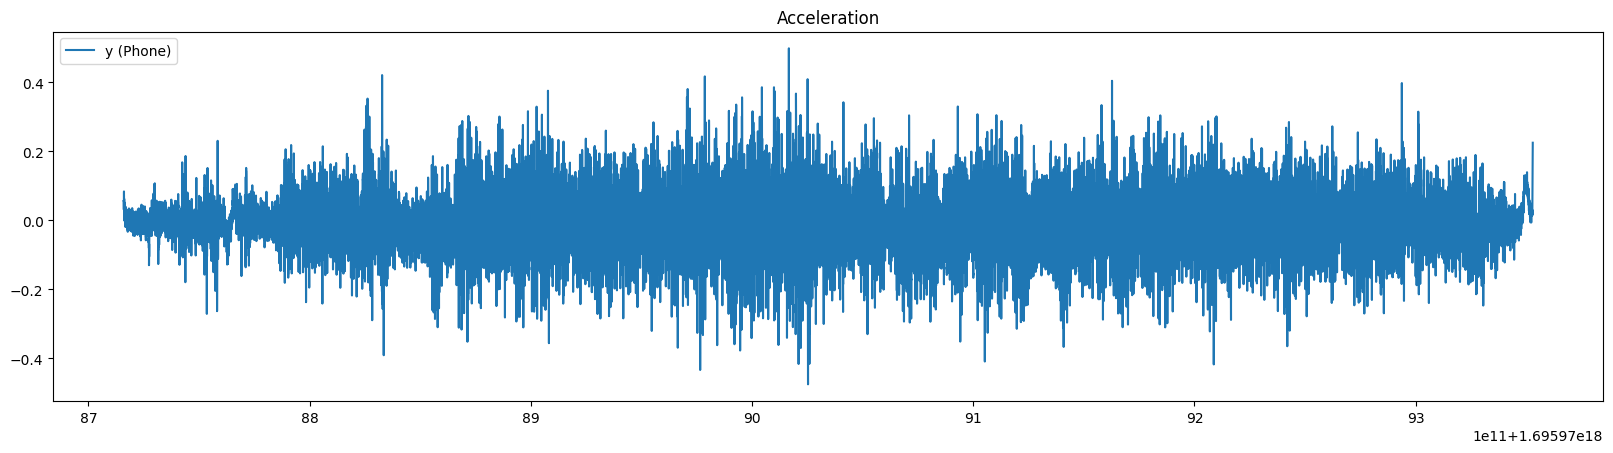

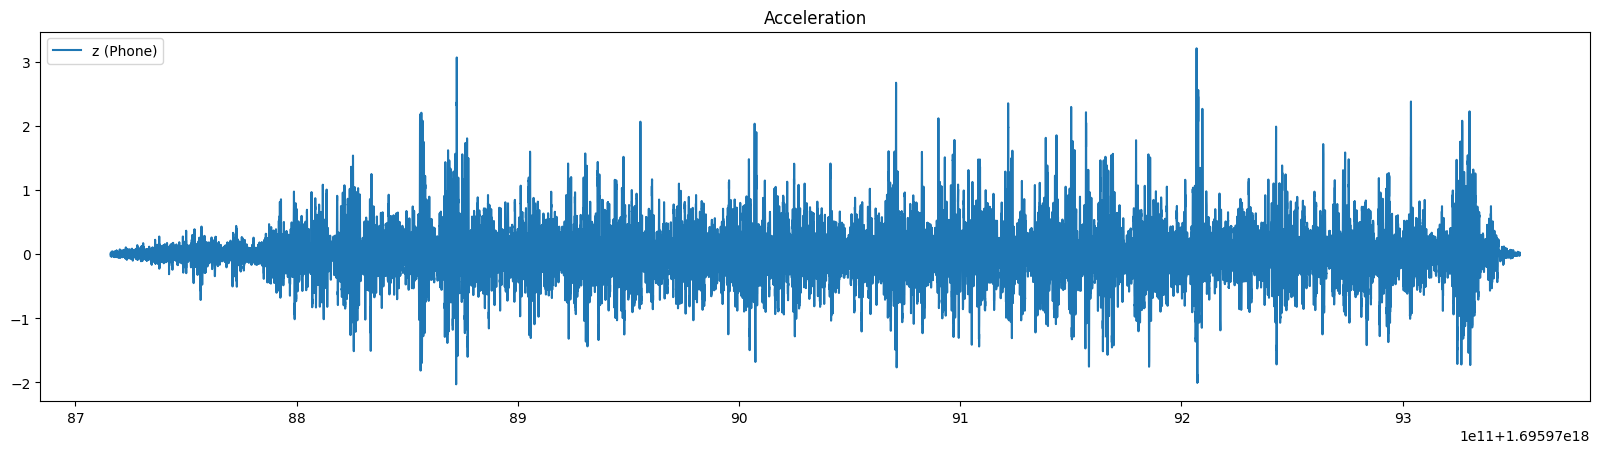

In [25]:
render_plot(
    "Velocity",
    df_phone_loc["time"],
    [df_phone_loc["speed"]],
    ["Velocity (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["x"]],
    ["x (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["y"]],
    ["y (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["z"]],
    ["z (Phone)"]
)

### 🇳🇴 Porovnání s norskou simulací

In [29]:
def map_velocity_2sim(points, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    dist_values = [0]
    for i,p in enumerate(points):
        if i+1 >= len(points):
            continue
        dist = tconsumption.calc_distance_two_points(p, points[i+1])
        dist_values.append(dist+dist_values[-1])

    max_velocities = []

    for d in dist_values:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            if first_offset*1000 - d < start_in_m:
                max_velocities.append(tv["value"])
                break

    return [x/3.6 for x in max_velocities]

def compare_data_2sim(df_sim, geojson_path: str, first_dist_offset, velocity_fp):
    # Calculated data
    c = tconsumption.Consumption()
    c.load_from_file(geojson_path)
    c.variable_params.update({
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98
    })
    c.max_velocities_in_mps = map_velocity_2sim(c.points, first_dist_offset, velocity_fp)

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 0

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    render_plot(
        "Energy",
        c.series["dist_values"],
        [energy_calculated],
        ["JN simulation", "Norwegian simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Norwegian energy",
        df_sim["distance"],
        [df_sim["Battery"]],
        ["Battery"],
        ["solid"]
    )

    # render_plot(
    #     "Norwegian energy",
    #     df_sim["distance"],
    #     [df_sim["Battery"], df_sim["Hydrogen"], df_sim["Diesel"], df_sim["OLE"]],
    #     ["Battery", "Hydrogen", "Diesel", "OLE"],
    #     ["solid"]*4
    # )

    render_plot(
        "Exerted force",
        c.series["dist_values"],
        [c.series["exerted_force_values"]],
        ["JN simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], c.max_velocities_in_mps+[c.max_velocities_in_mps[-1]]],
        ["JN simulation", "Max velocity"],
        ["solid", "dashed"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["JN simulation"],
        ["solid"]
    )

    print(f"JN simulation final energy: {energy_calculated[-1]}")
    print(f"Norwegian simulation final energy: {df_sim['Battery'].iloc[-1]}")

    dtw = fastdtw(energy_calculated, df_sim["Battery"])[0]
    print("DTW:", dtw)

In [30]:
if PREP_GEOJSONS:
    get_rail({
        "output": "../testing-data/norway-sim/opava-olomouc.geojson",
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
    }, 49002, True)

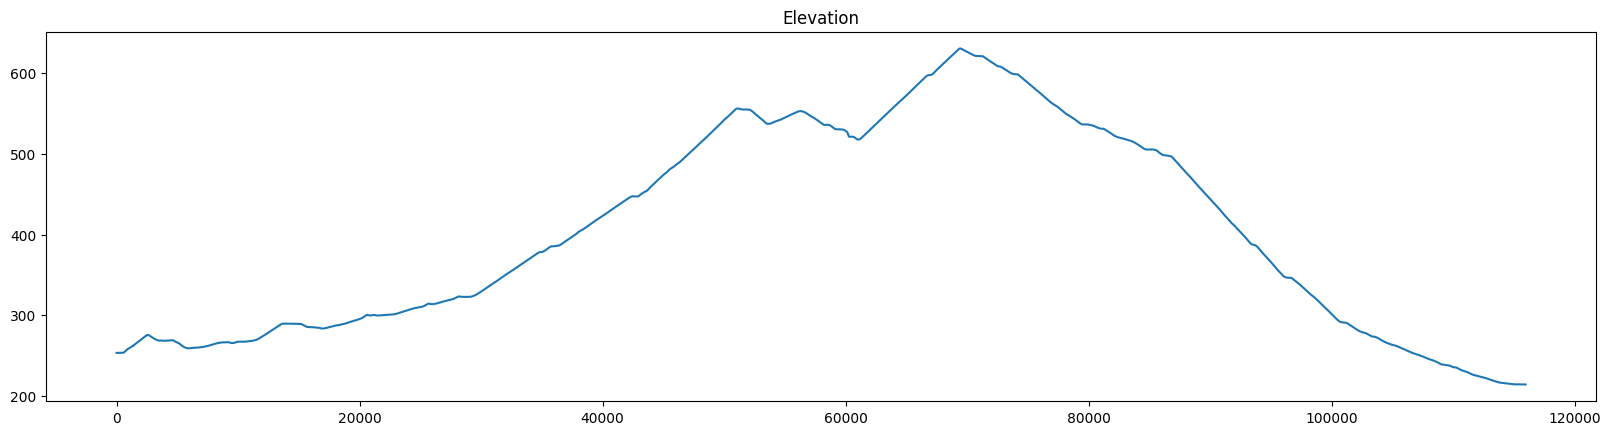

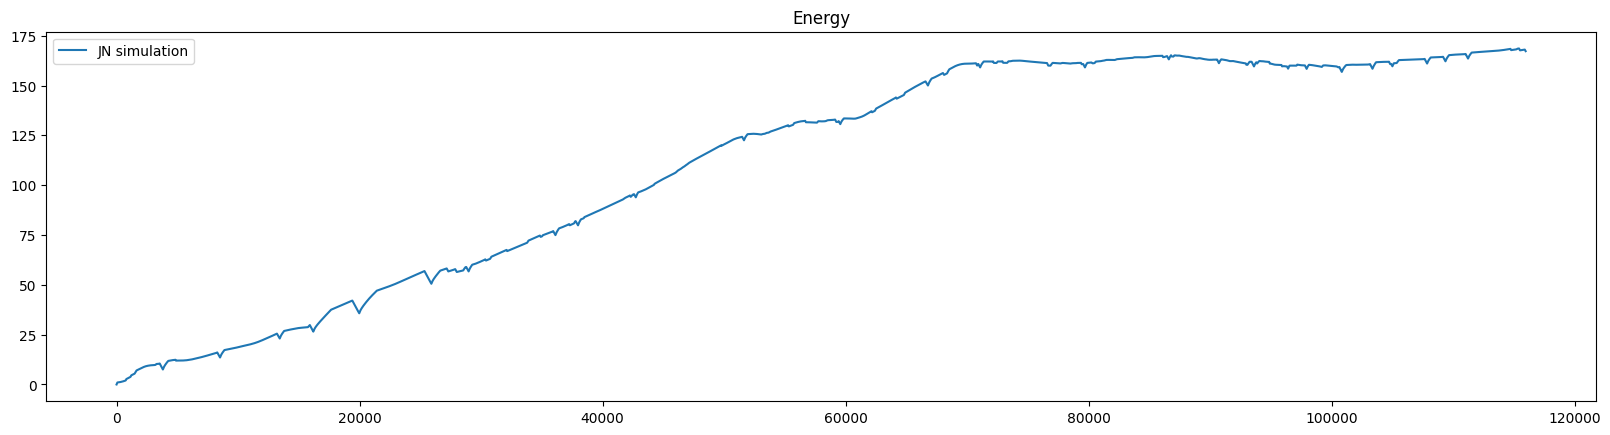

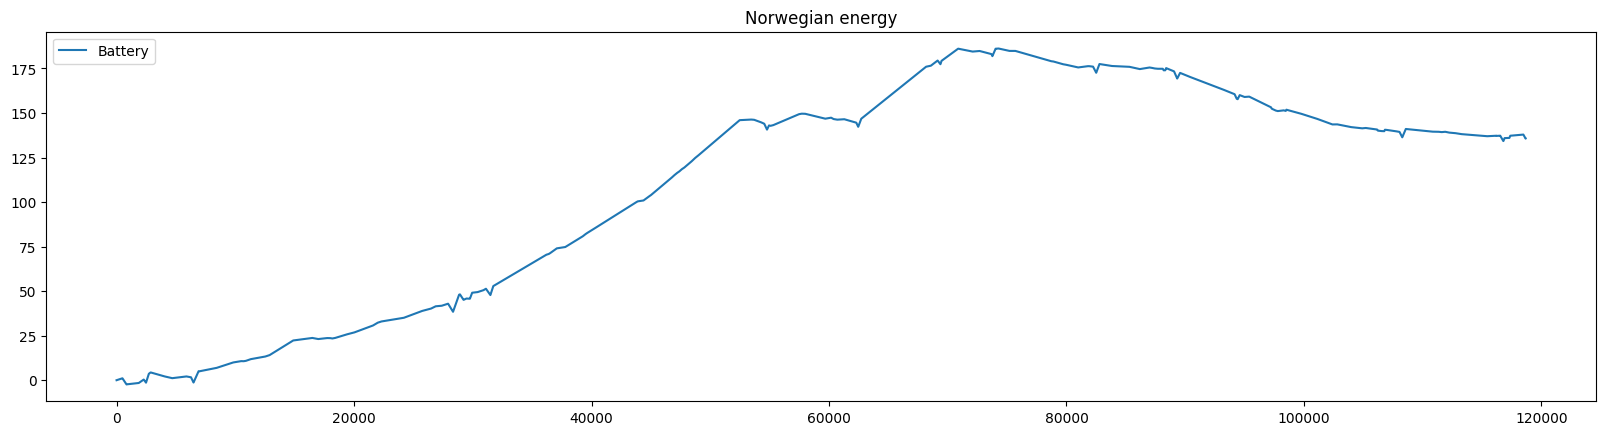

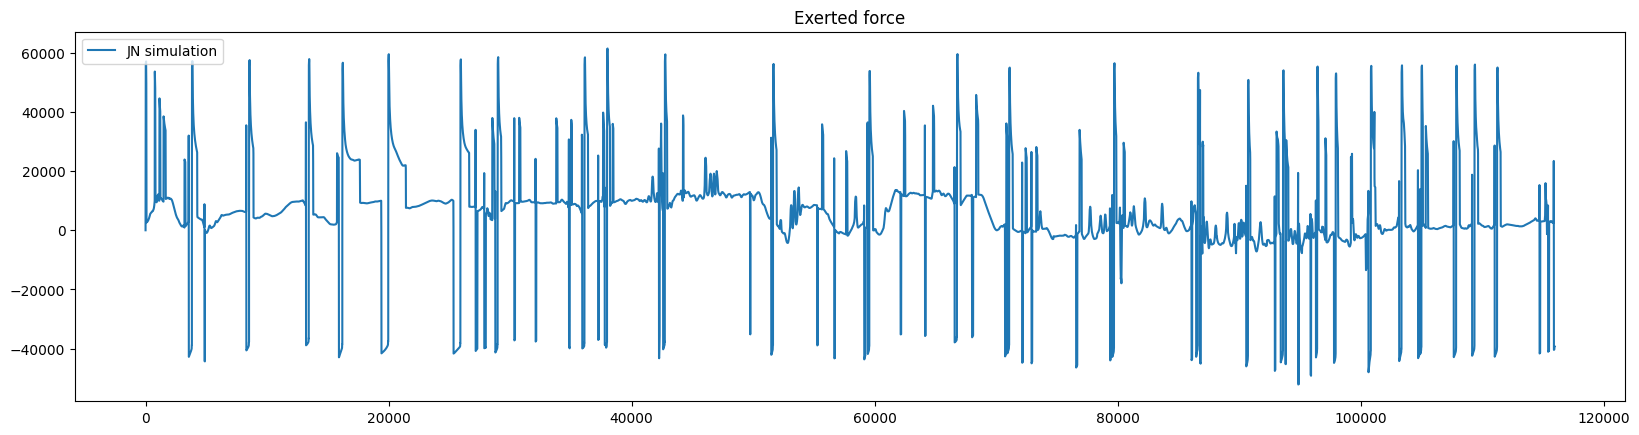

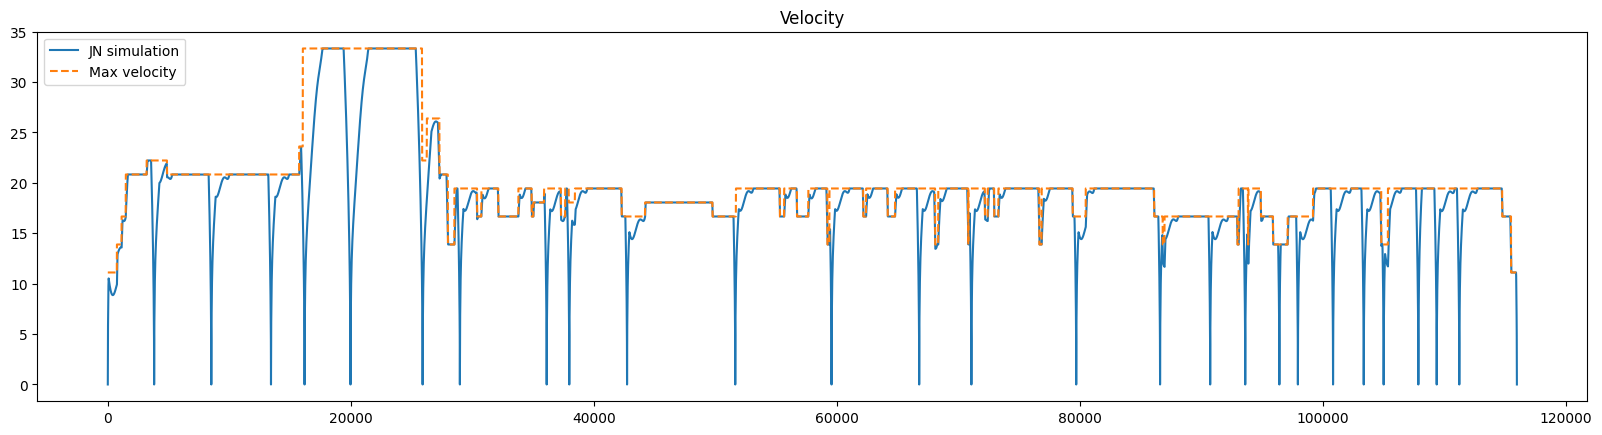

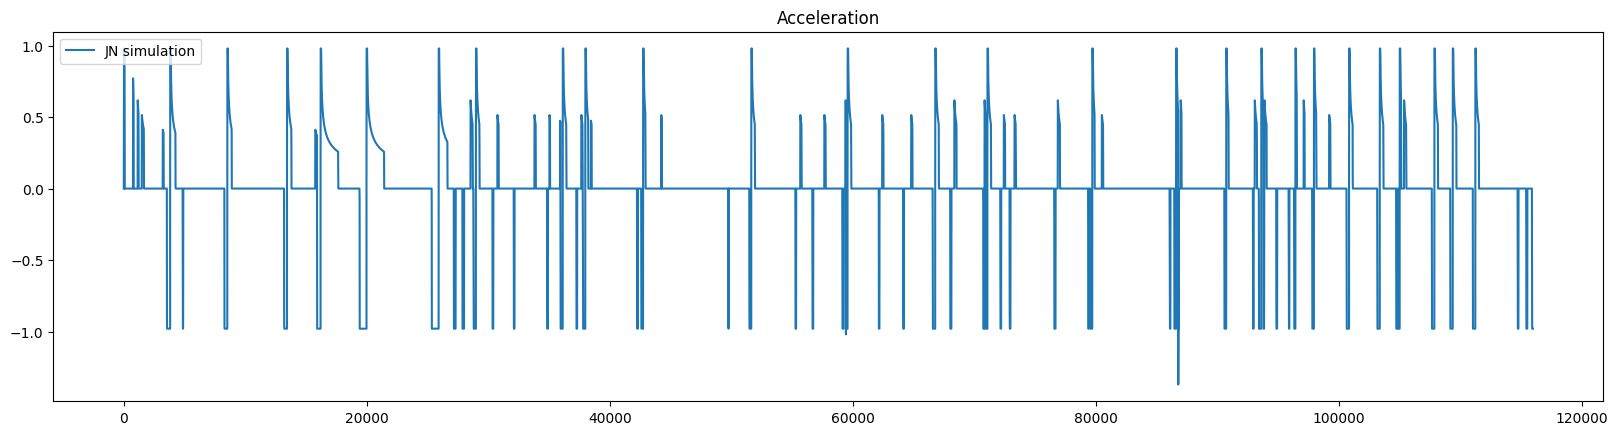

JN simulation final energy: 167.23055275740424
Norwegian simulation final energy: 135.61772263885865
DTW: 83415.36562379566


In [31]:
# Read and process
df_norway = pd.read_csv("../testing-data/norway-sim/West_energy.csv", delimiter=",", header=[0,1])
df_norway.columns = [x[0] for x in df_norway.columns]
df_norway = df_norway.rename(columns={"Unnamed: 0_level_0": "distance"})

# Remove first few stations (Ostrava-Opava)
df_norway = df_norway[df_norway["distance"] >= 36000]
df_norway.reset_index(inplace=True, drop=True)

# Reset variables
for k in df_norway.keys():
    offset_value = df_norway[k].iloc[0]
    df_norway[k] = df_norway[k] - offset_value

compare_data_2sim(
    df_norway,
    "../testing-data/norway-sim/opava-olomouc.geojson",
    116.193, "../testing-data/velocity-data/310.json"
)

### 🚧 Ladění algoritmu

[0, 410, 849, 1398, 1688, 2030, 2597, 2935, 3713, 3903, 4398, 5363, 6100, 6730, 7120, 7968, 8656, 9047, 9337, 9602, 9772, 10045, 10261, 10414, 10726, 10907, 11123, 11641]


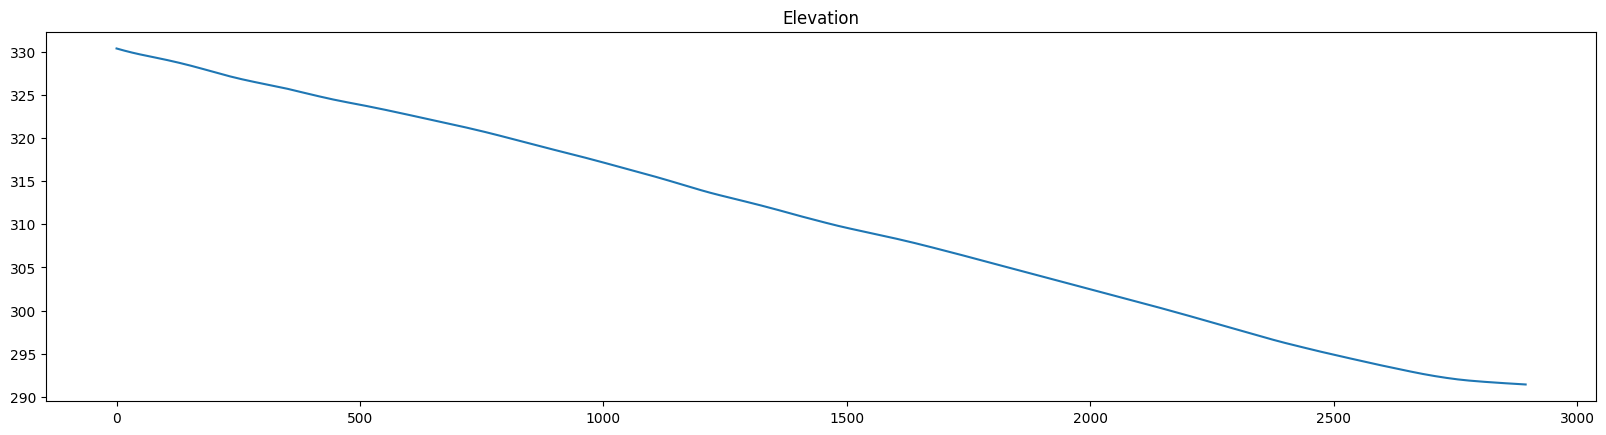

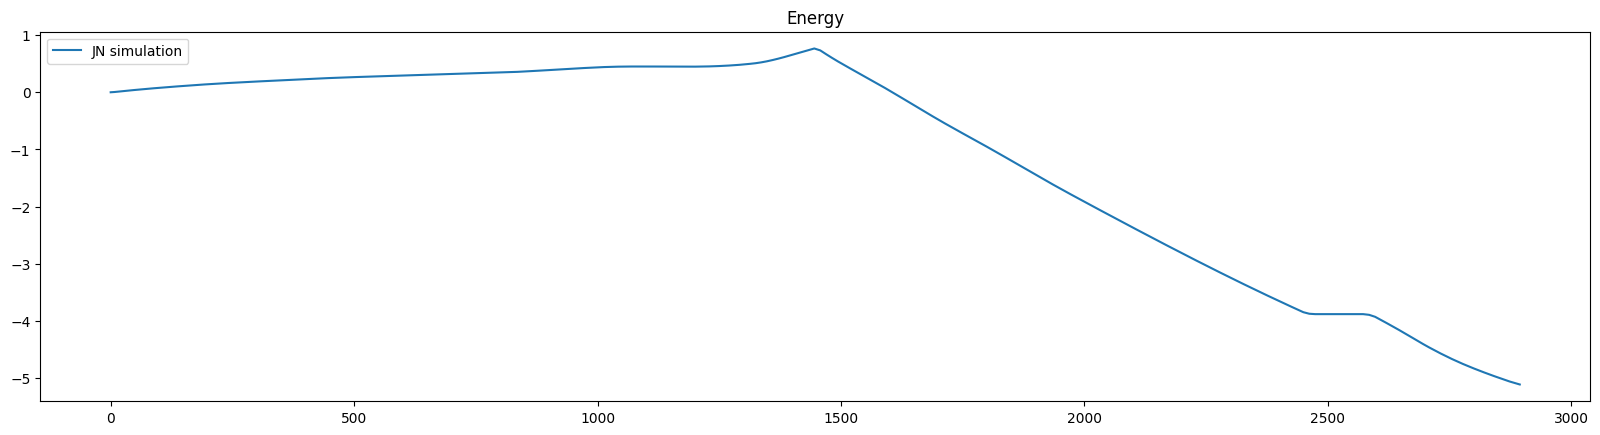

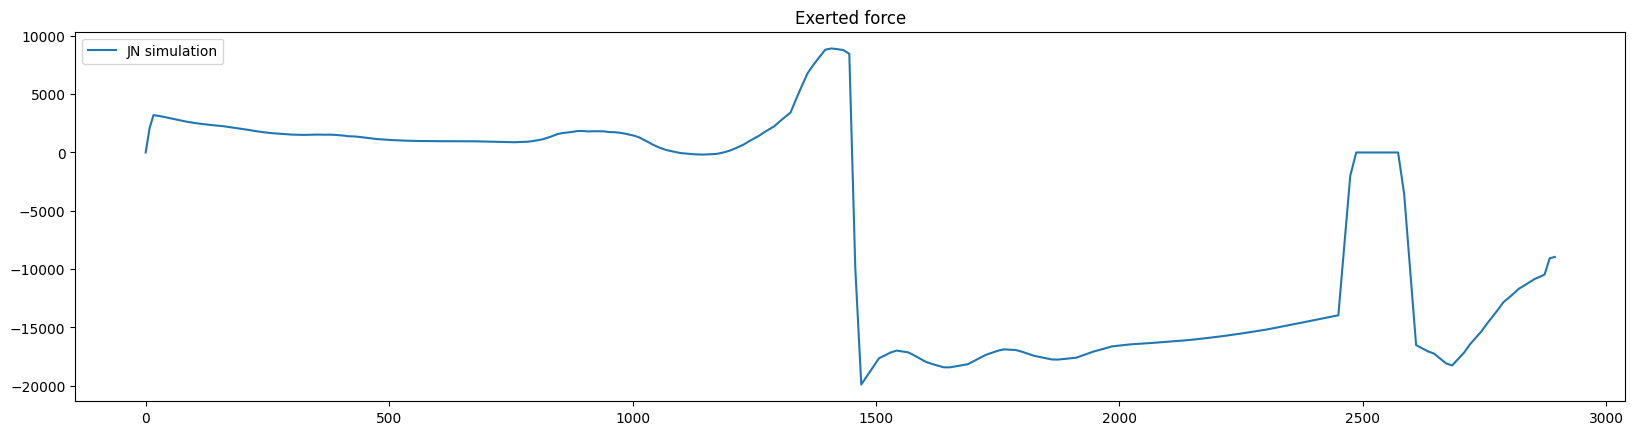

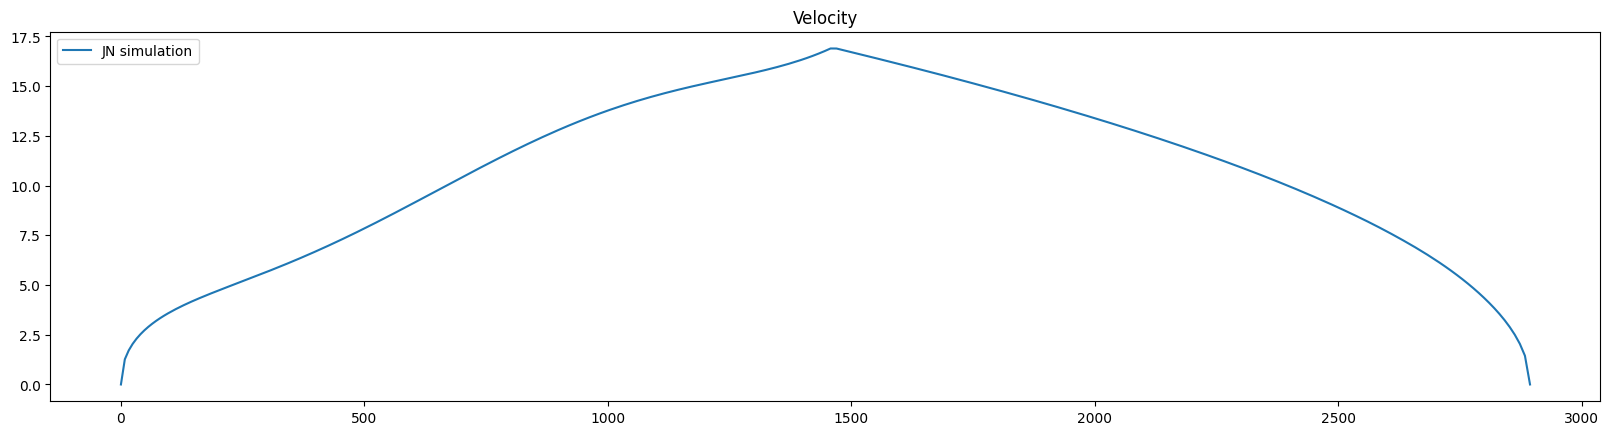

JN simulation final energy: -5.1136327573608815


In [34]:
importlib.reload(tconsumption)

# Calculated data
c = tconsumption.Consumption()
c.variable_params.update({
    "Elevation smoothing": 100,
    "Curve smoothing": 10,
    "Curve A": 999,
    "Curve B": 100,
    "Running a": 2,
    "Running b": 0.054,
    "Running c": 0.00034,
    "Recuperation coefficient": 1,
    "Comfortable acceleration": 0.1
})
c.load_from_file("../testing-data/norway-sim/opava-olomouc.geojson")
# c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"]) # TODO: Add limits

# Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
c.params["power_limit"] = 480*1000
c.params["mass_locomotive"] = 56000
c.params["mass_wagon"] = 0

# Picking a slice
print(c.stations)
from_station = 20
to_station = 21

start_idx = c.stations[from_station]
end_idx = c.stations[to_station]

c.points = c.points[start_idx:end_idx]
c.stations = c.stations[from_station:to_station+1]
c.stations = [x-c.stations[0] for x in c.stations]
c.max_velocities_in_mps = c.max_velocities_in_mps[start_idx:end_idx]
c.series["elevation_values"] = c.series["elevation_values"][start_idx:end_idx]

# Running the simulation
c.run()

# Plotting
render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
render_plot(
    "Energy",
    c.series["dist_values"],
    [energy_calculated],
    ["JN simulation"],
    ["solid"]
)
render_plot(
    "Exerted force",
    c.series["dist_values"],
    [c.series["exerted_force_values"]],
    ["JN simulation"],
    ["solid", "solid"]
)

render_plot(
    "Velocity",
    c.series["dist_values"],
    [c.series["velocity_values"]],
    ["JN simulation", "Norwegian simulation"],
    ["solid", "solid"]
)

print(f"JN simulation final energy: {energy_calculated[-1]}")

# dtw = fastdtw(energy_calculated, HERE)[0]
# print("DTW:", dtw)

### 📈 Hledání funkce omezující "kroutící moment"

In [35]:
def draw_init_velocity_delta(df_measured, geojson_path, filter_window, fit_degree, interest_range=None):
    importlib.reload(tconsumption)

    c = run_simulation(df_measured, geojson_path, compensate=False)

    if interest_range is None:
        interest_range = (0, len(c.series["velocity_values"]))

    # Get deltas
    velocity_deltas = []
    for i in range(len(c.series["velocity_values"])):
        delta = c.series["velocity_values"][i] - df_measured["gps_speed"].iloc[i]
        velocity_deltas.append(delta)
        # if interest_range is None and delta <= 0 and i >= 100:
        #     interest_range = (0, i+1)
        # print(delta)
    print(interest_range)
    # interest_range = (0, len(velocity_deltas)) # debug

    interest_dists = c.series["dist_values"][interest_range[0]:interest_range[1]]
    interest_deltas = velocity_deltas[interest_range[0]:interest_range[1]]
    interest_sim_velocity = c.series["velocity_values"][interest_range[0]:interest_range[1]]
    interest_measured_velocity = df_measured["gps_speed"][interest_range[0]:interest_range[1]]
    interest_max_velocity = c.max_velocities_in_mps[interest_range[0]:interest_range[1]]

    # render_plot(
    #     "Velocity delta (full)",
    #     c.series["dist_values"],
    #     [velocity_deltas],
    #     ["Delta (actual)"],
    #     ["solid"],
    #     show_hline=True
    # )

    render_plot(
        "Velocity (full)",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    render_plot(
        "Velocity (interest)",
        interest_dists,
        [interest_sim_velocity, interest_measured_velocity, interest_max_velocity],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    # Fitting a polynomial
    poly = np.poly1d(np.polyfit(interest_dists, interest_deltas, fit_degree))
    # print("polynomial:", poly)

    render_plot(
        "Velocity delta (interest)",
        interest_dists,
        [interest_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    # Savgol Filter
    filtered_deltas = savgol_filter(interest_deltas, filter_window, 0, mode="nearest")

    # Fitting a polynomial (to Savgol)
    poly = np.poly1d(np.polyfit(interest_dists, filtered_deltas, fit_degree))
    # print("polynomial:", poly)

    render_plot(
        "Velocity delta (interest, filtered)",
        interest_dists,
        [filtered_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    # # Fitting a polynomial (to velocity x velocity)
    # poly = np.poly1d(np.polyfit(interest_sim_velocity, filtered_deltas, fit_degree))
    render_plot(
        "Velocity x velocity",
        interest_sim_velocity,
        [filtered_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    return {
        "deltas": interest_deltas,
        "dists": interest_dists,
        "poly": poly
    }

In [36]:
all_poly_graphs = []

#### Opava západ ➡️ Krnov-Cvilín

(0, 200)


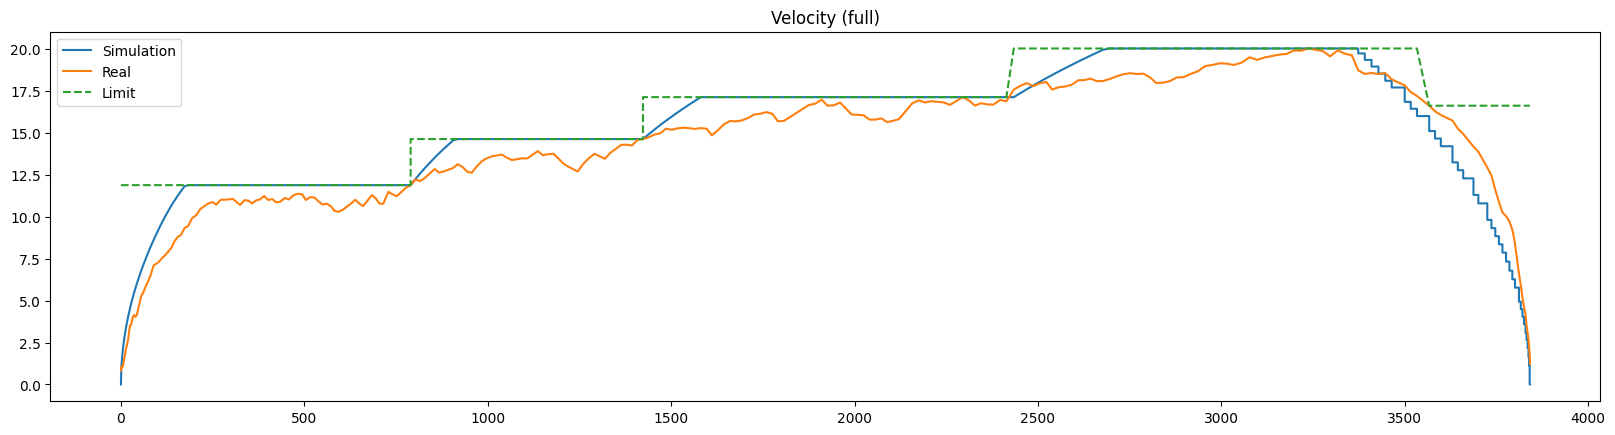

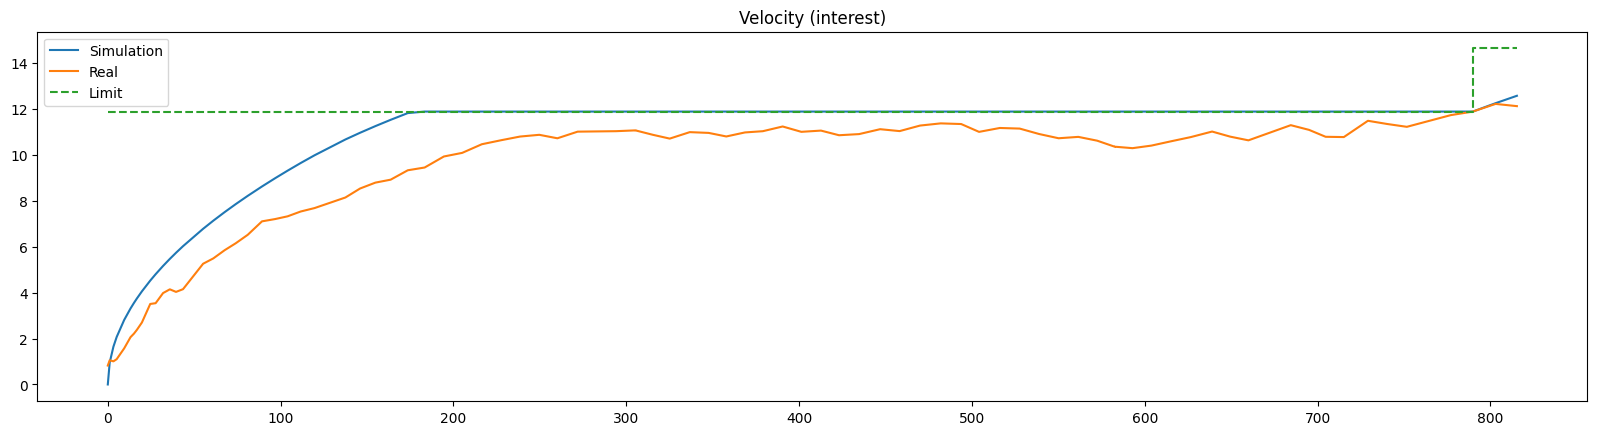

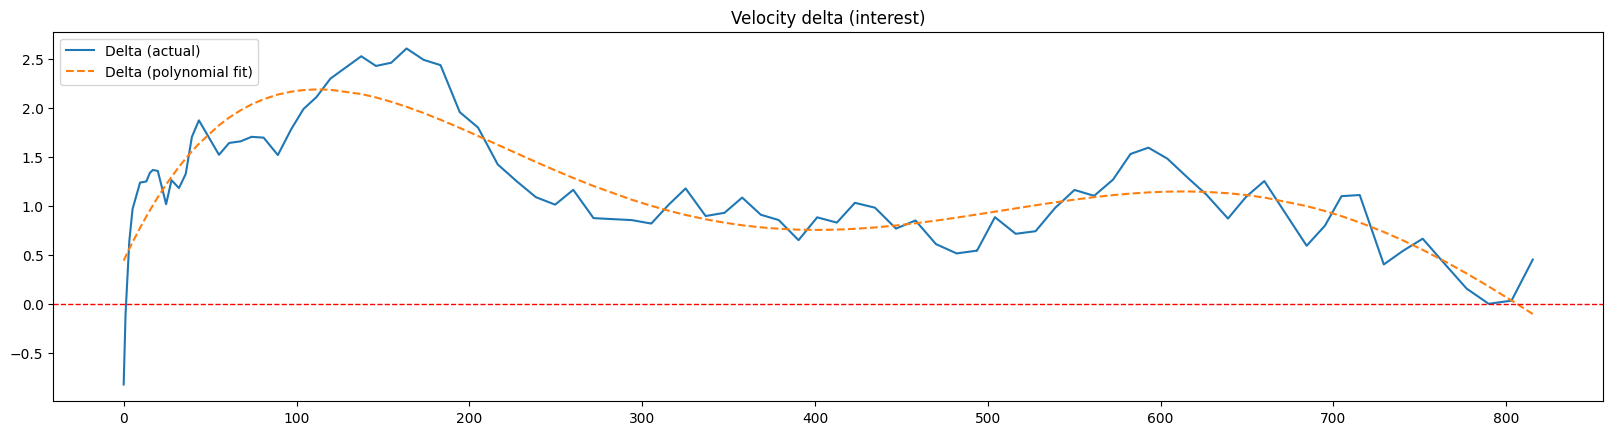

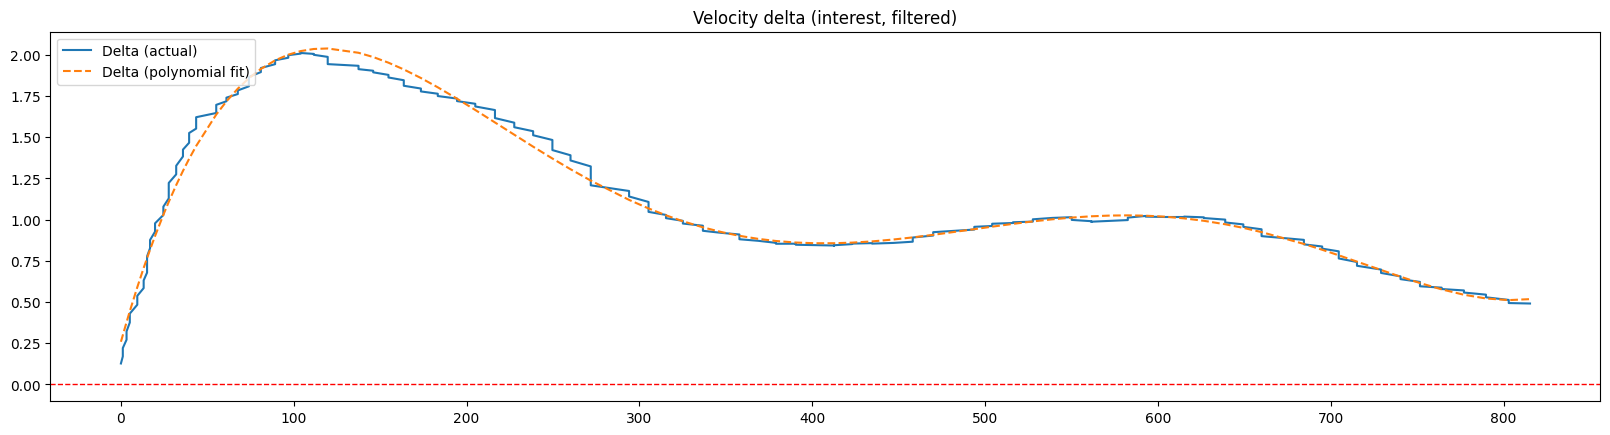

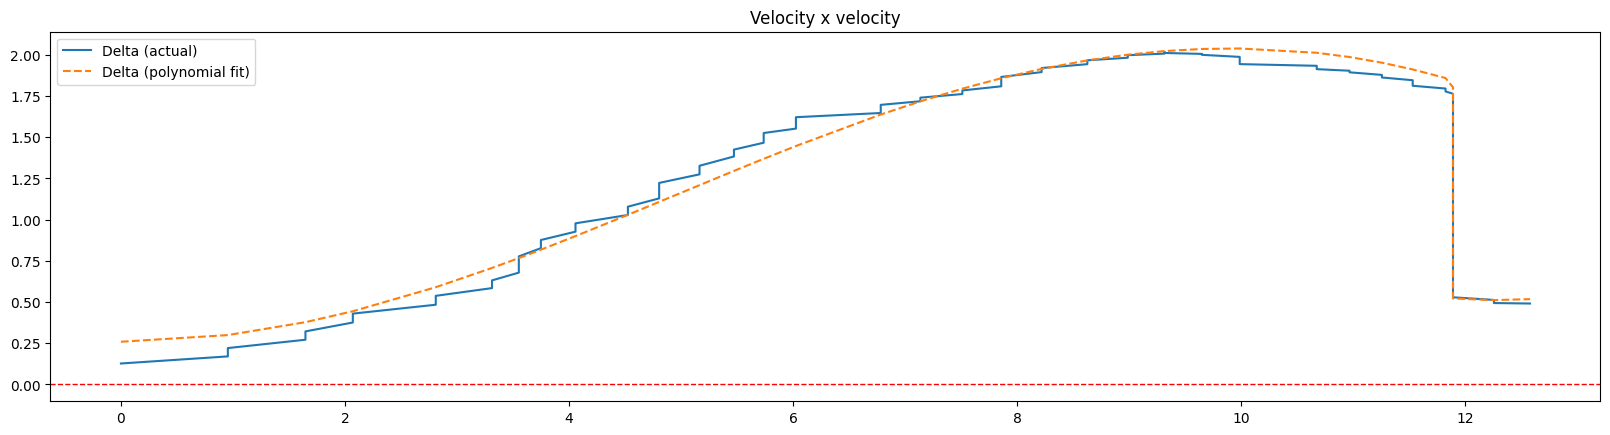

In [37]:
output = draw_init_velocity_delta(
    processed_sections[0]["df"], processed_sections[0]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 200)
)
all_poly_graphs.append(output)

#### Krnov-Cvilín ➡️ Krnov

(0, 238)


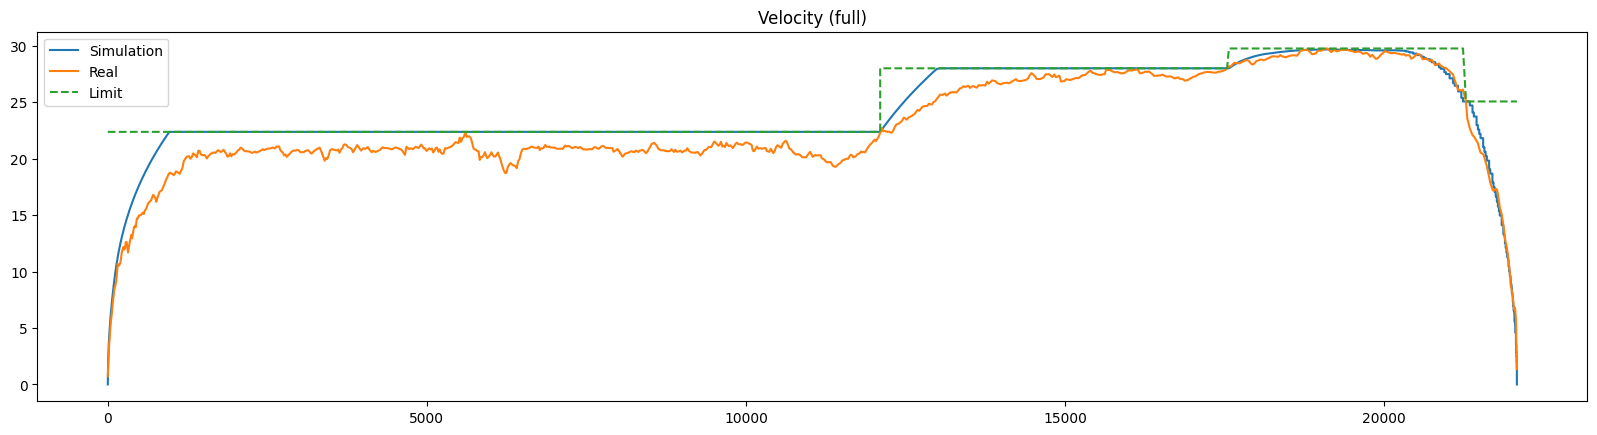

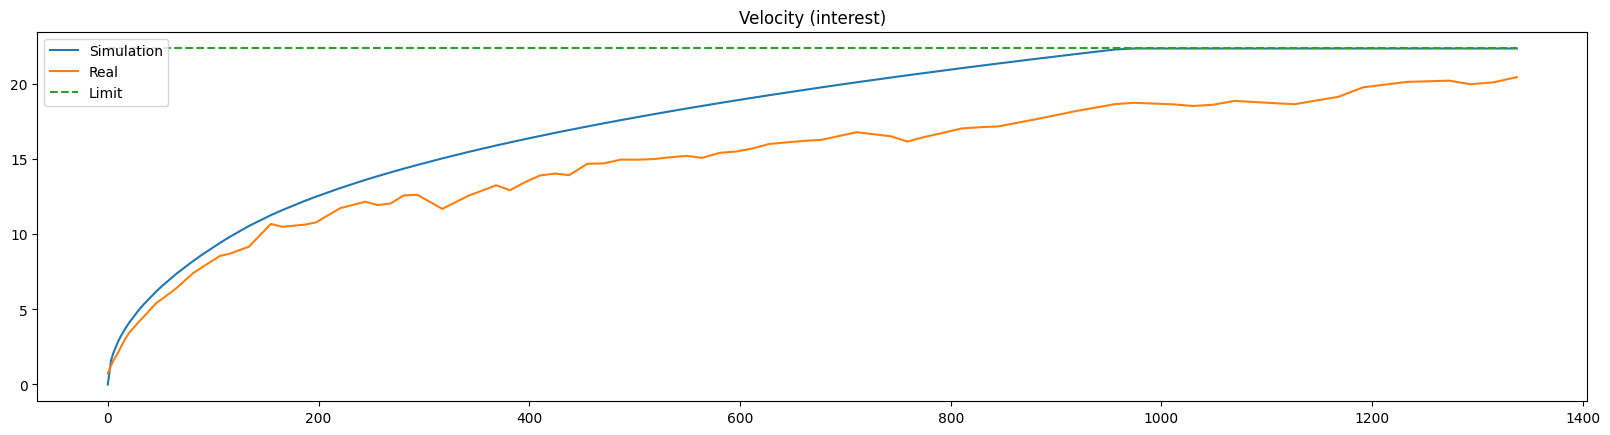

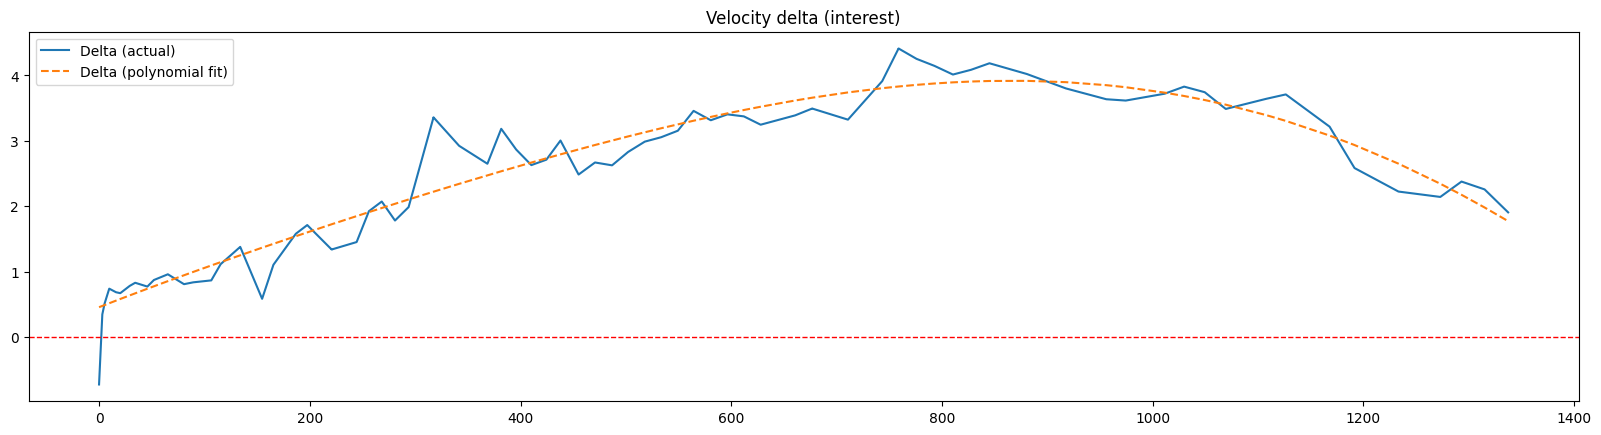

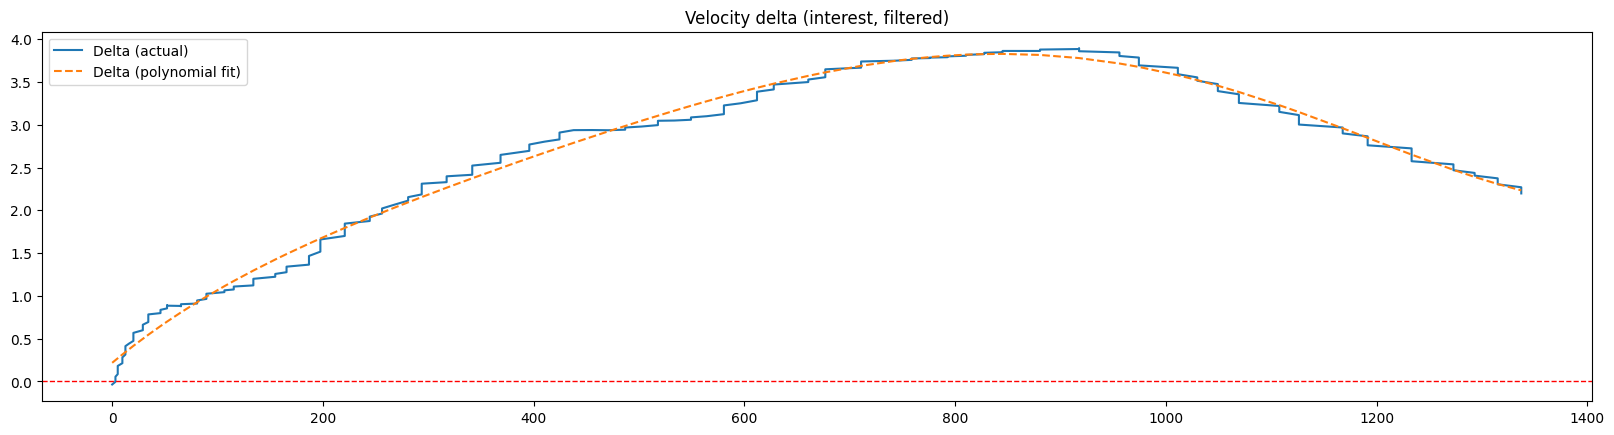

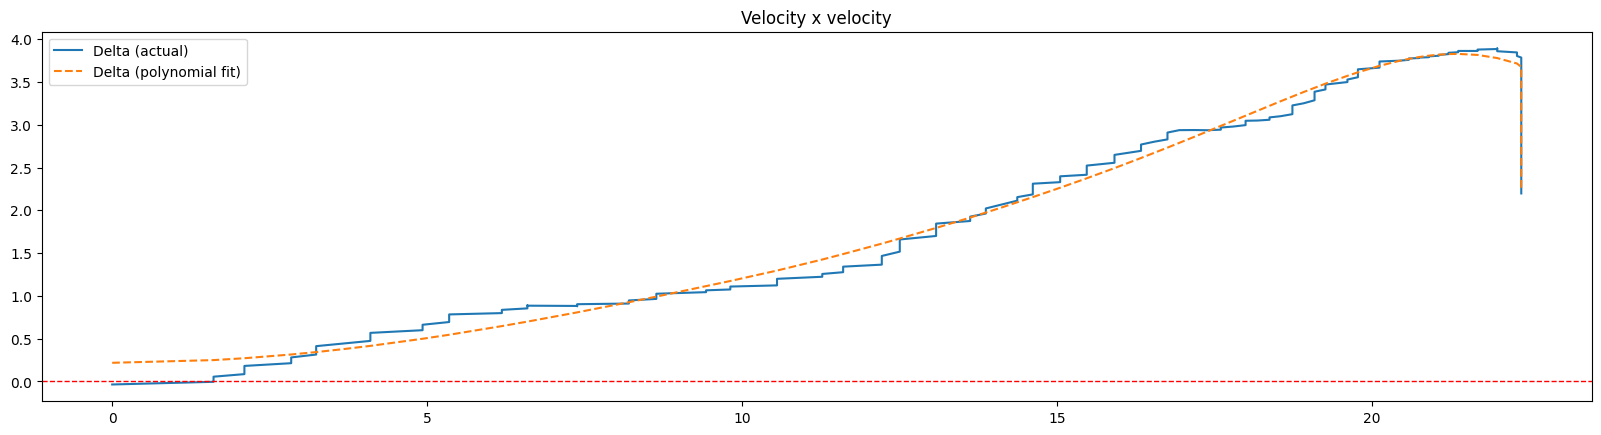

In [38]:
output = draw_init_velocity_delta(
    processed_sections[1]["df"], processed_sections[1]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 238)
)
all_poly_graphs.append(output)

#### Krnov ➡️ Milotice n. Opavou

(0, 255)


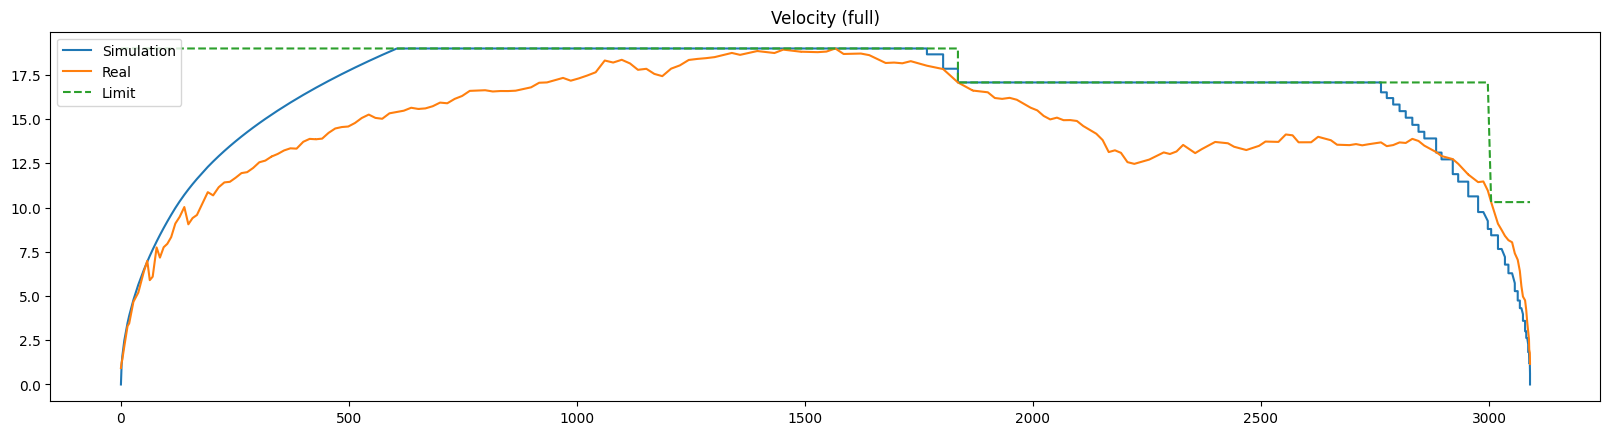

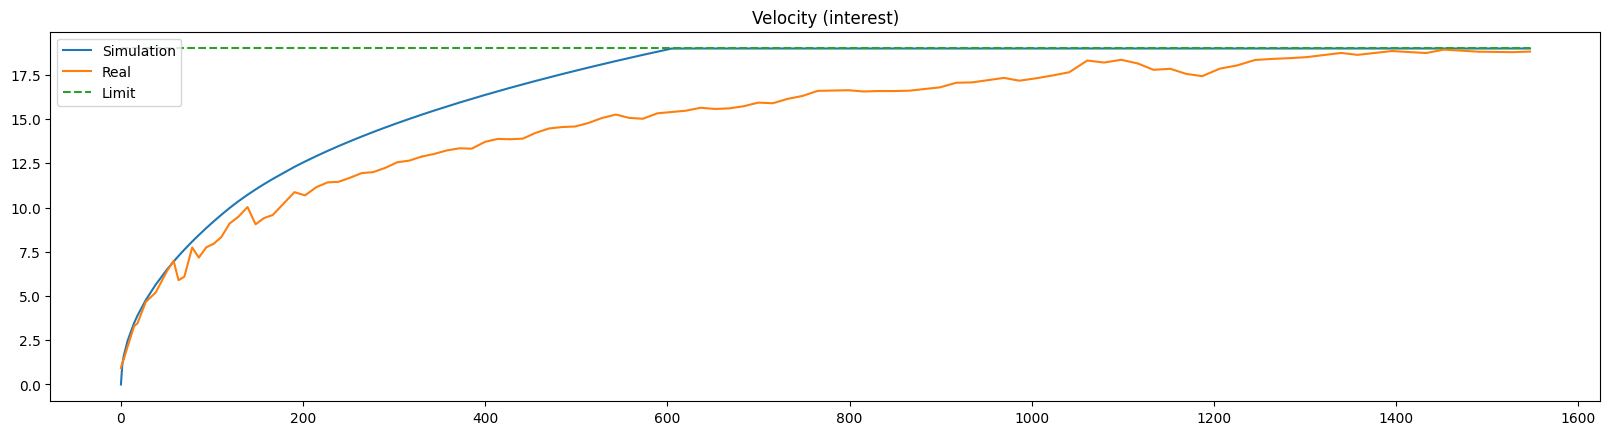

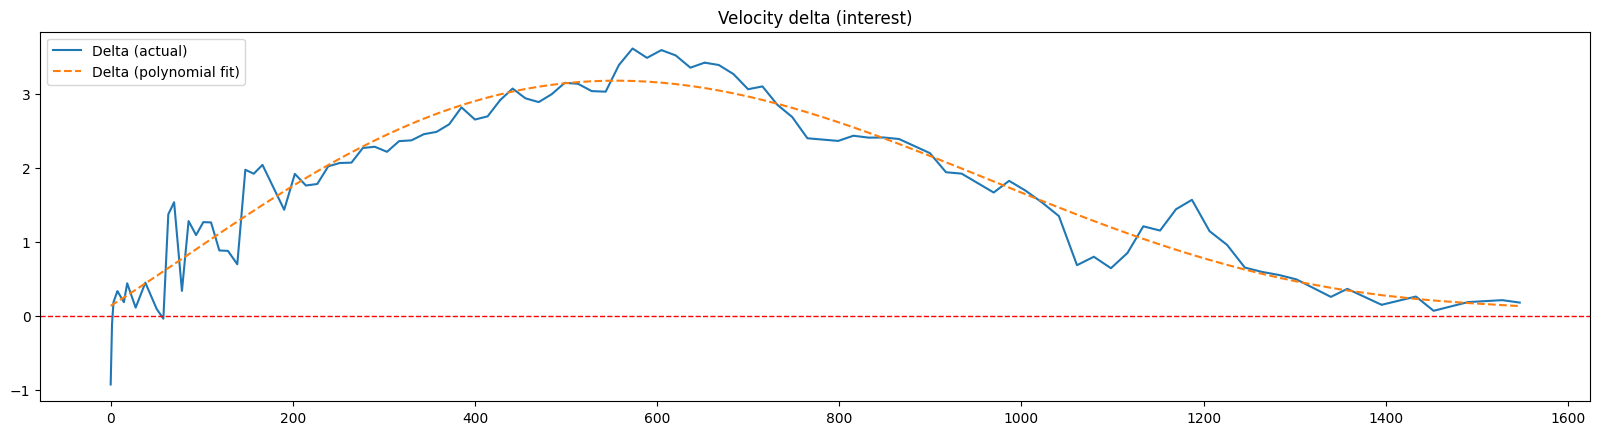

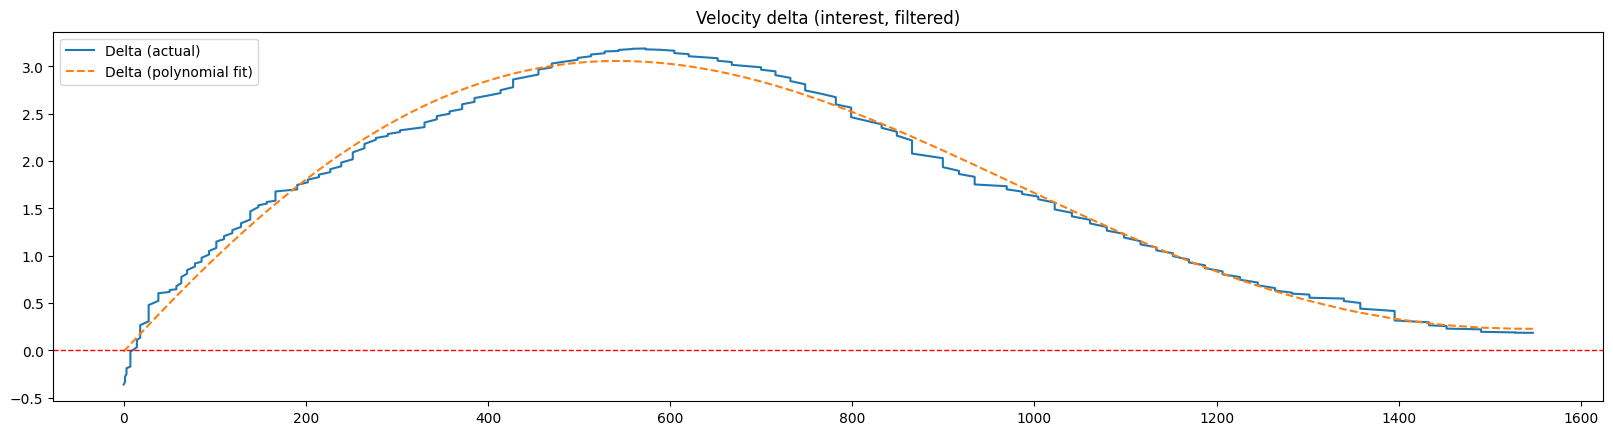

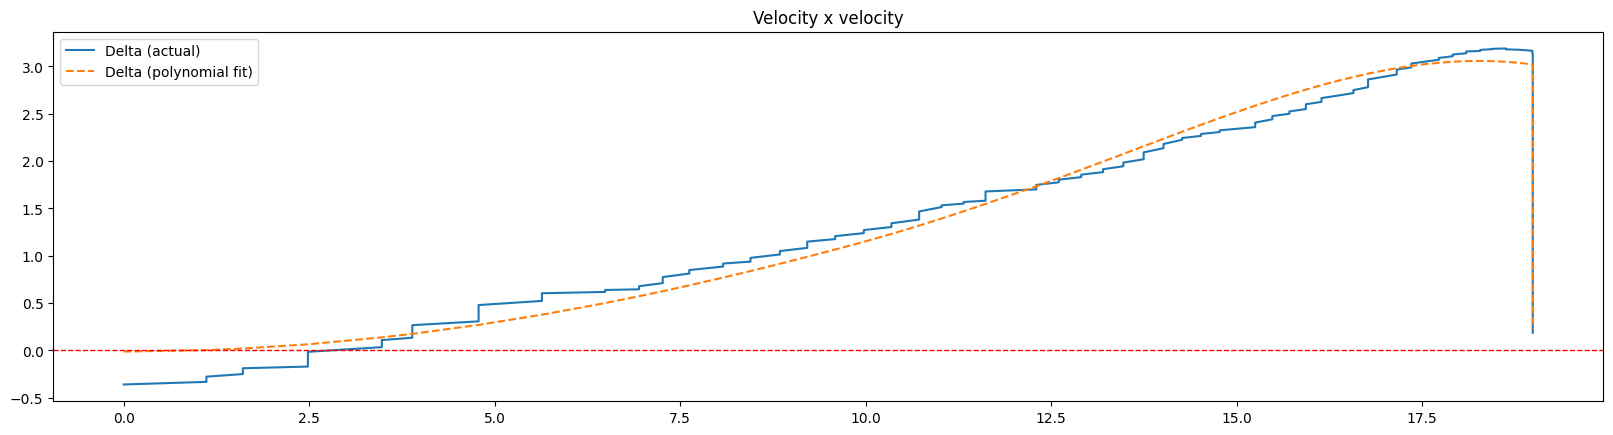

In [39]:
output = draw_init_velocity_delta(
    processed_sections[2]["df"], processed_sections[2]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 255)
)
all_poly_graphs.append(output)

#### Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí

(0, 105)


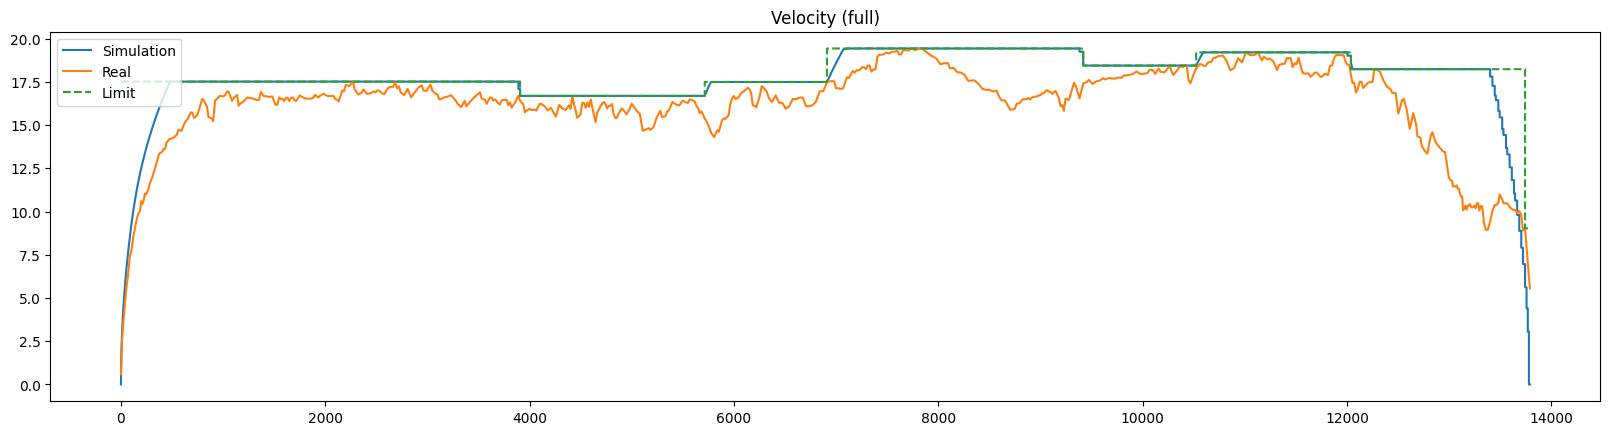

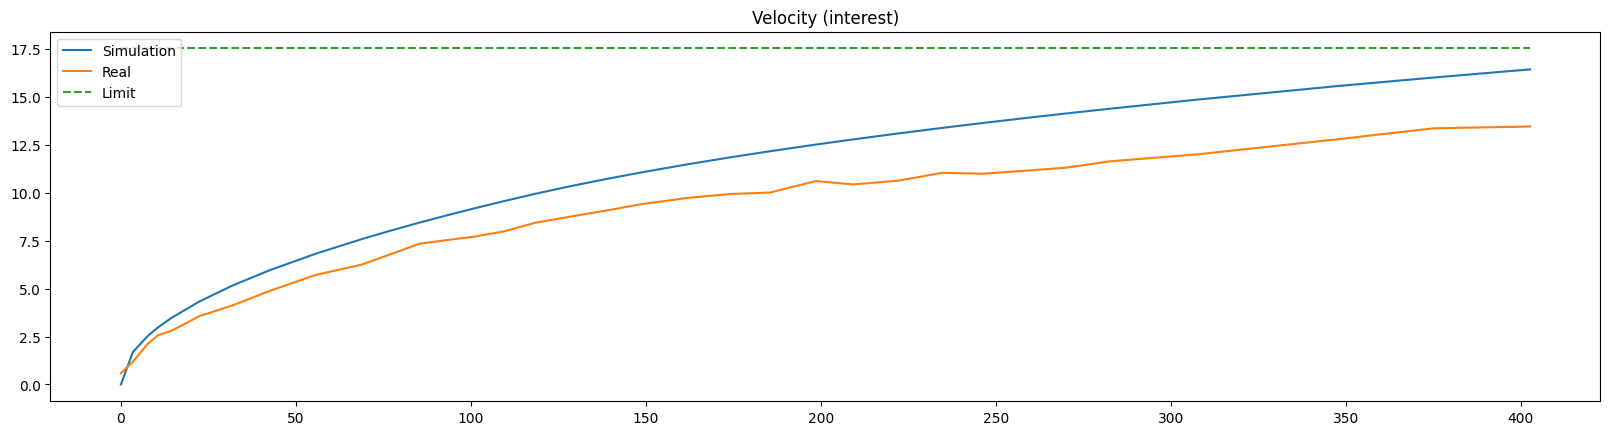

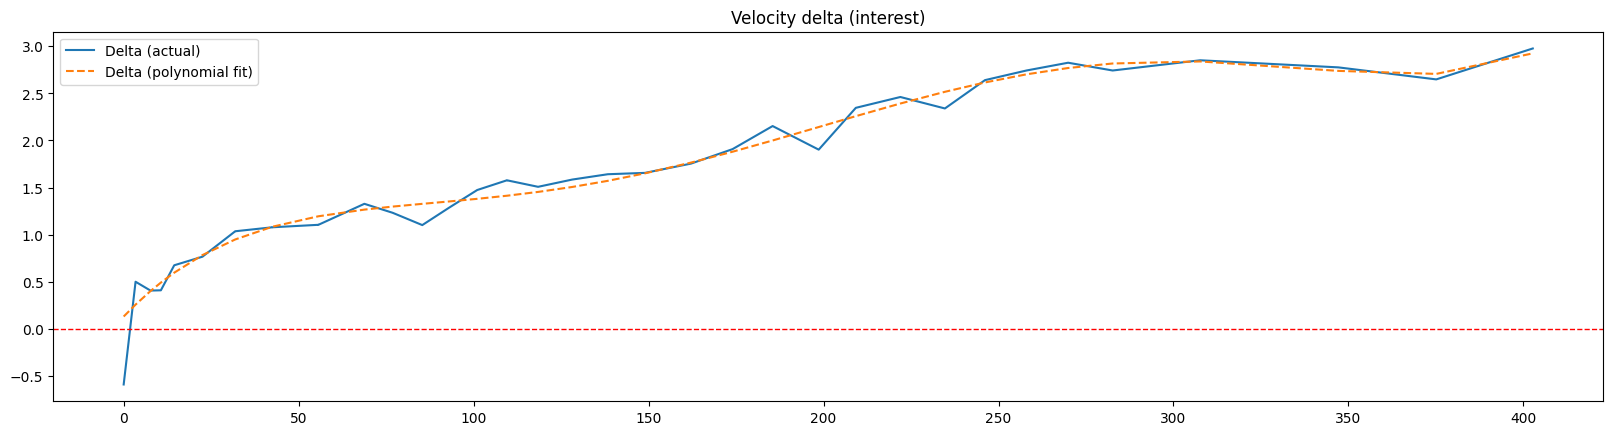

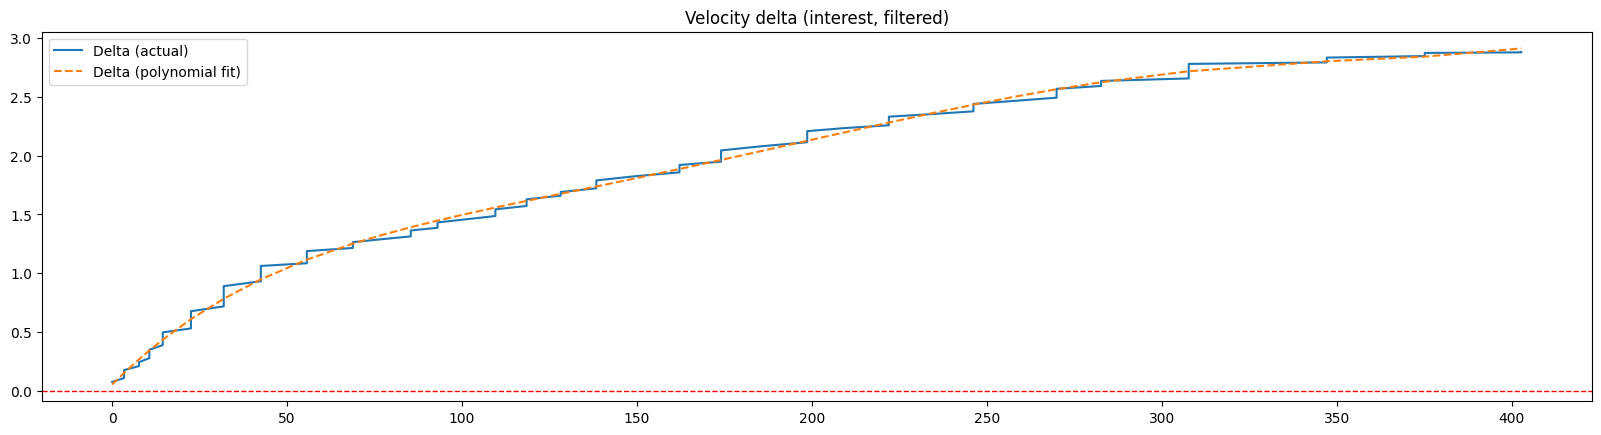

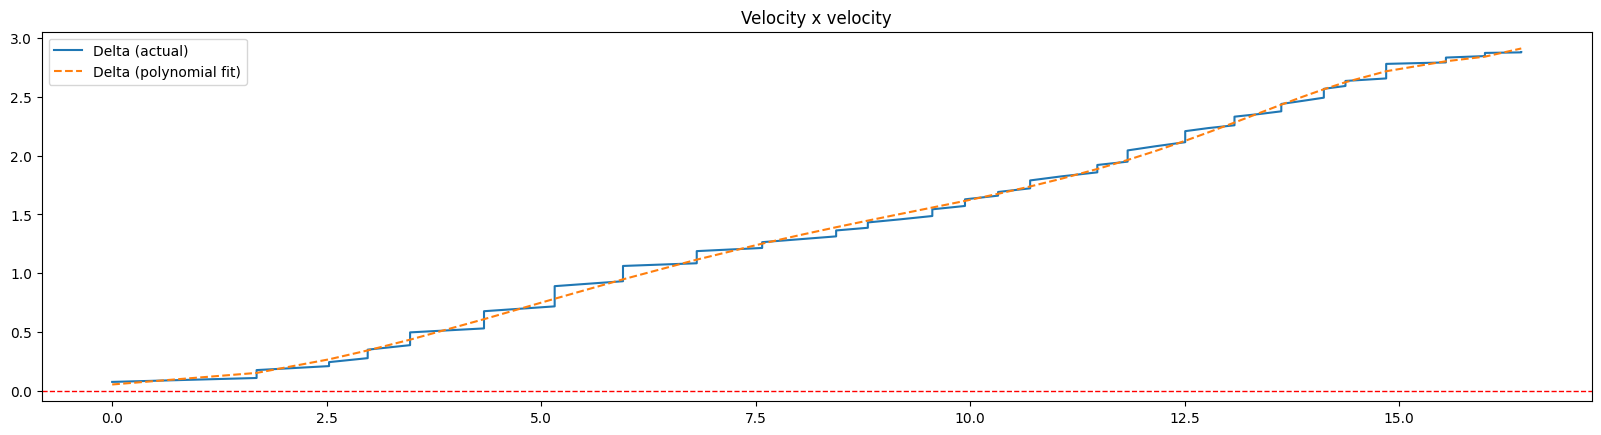

In [40]:
output = draw_init_velocity_delta(
    processed_sections[3]["df"], processed_sections[3]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 105)
)
all_poly_graphs.append(output)

#### Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí

(0, 330)


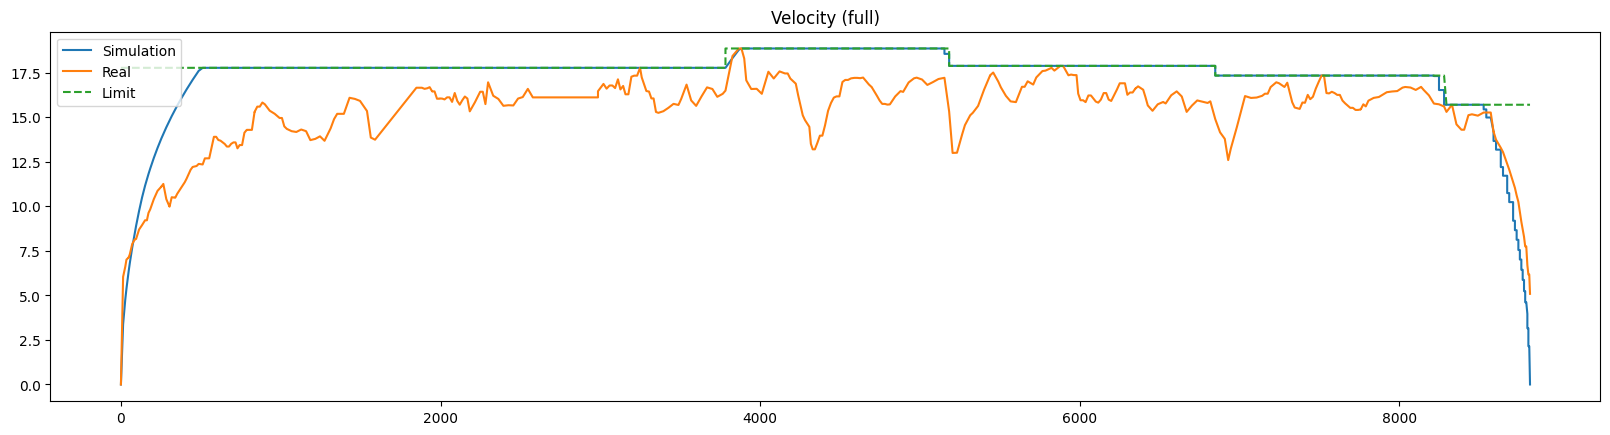

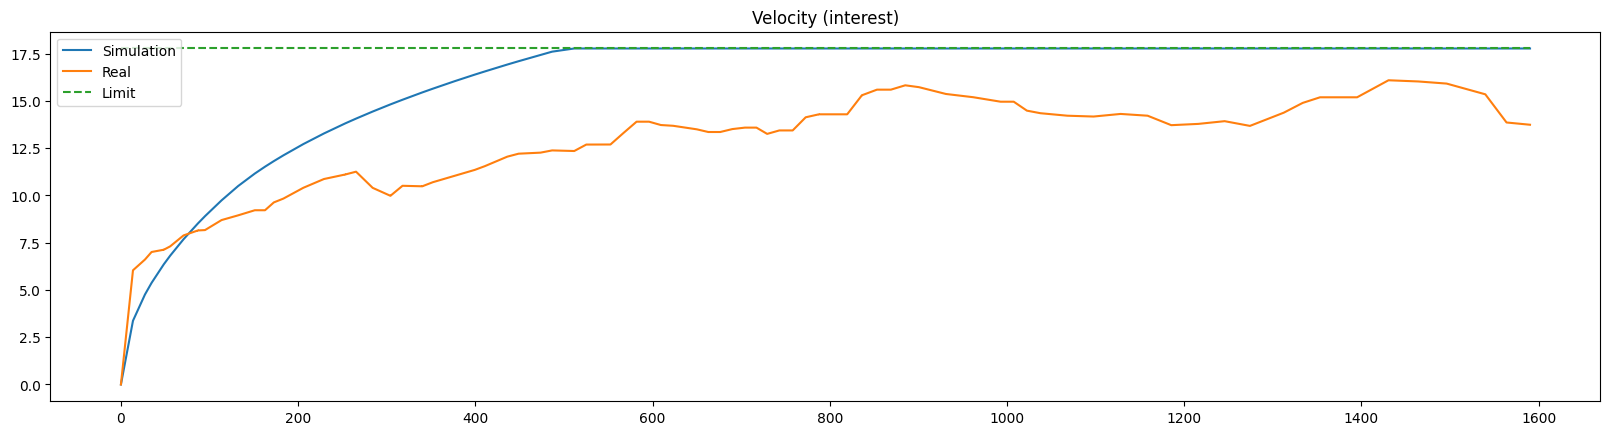

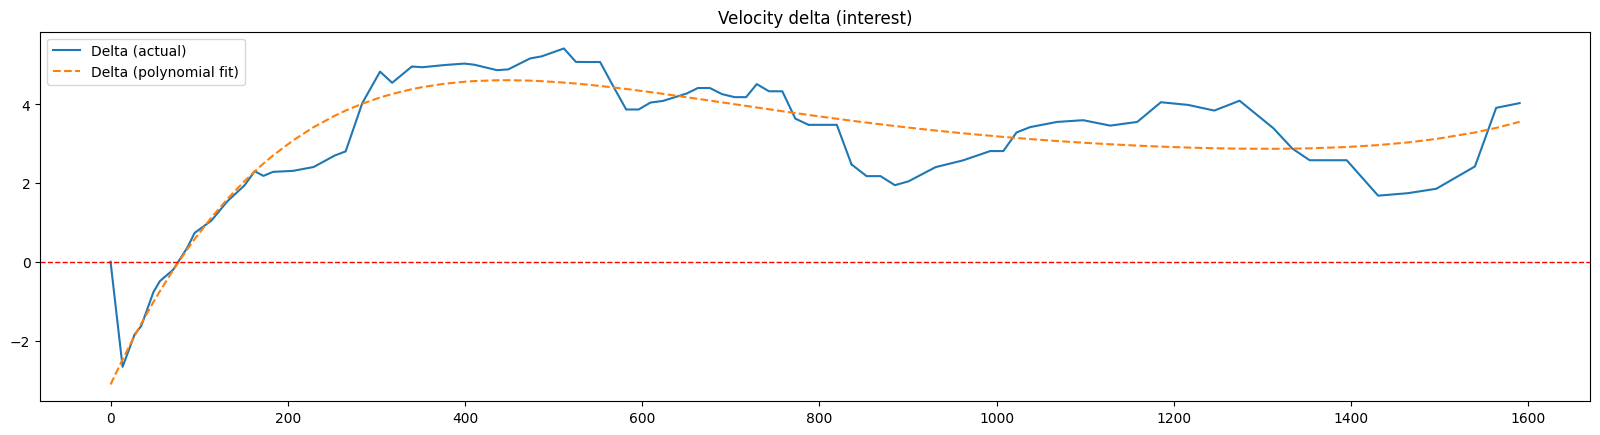

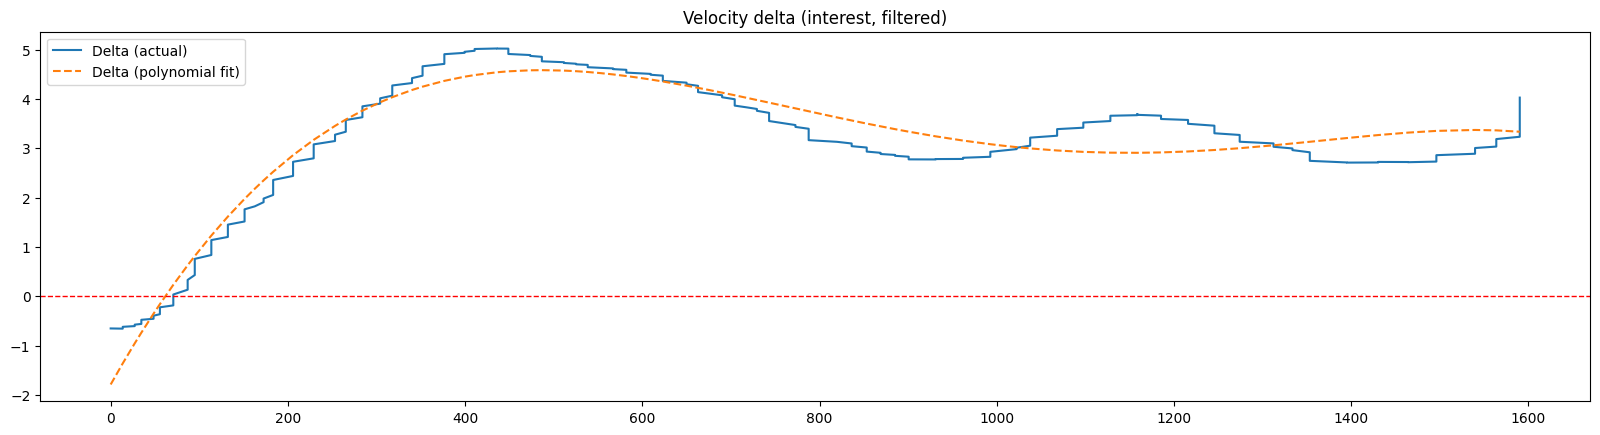

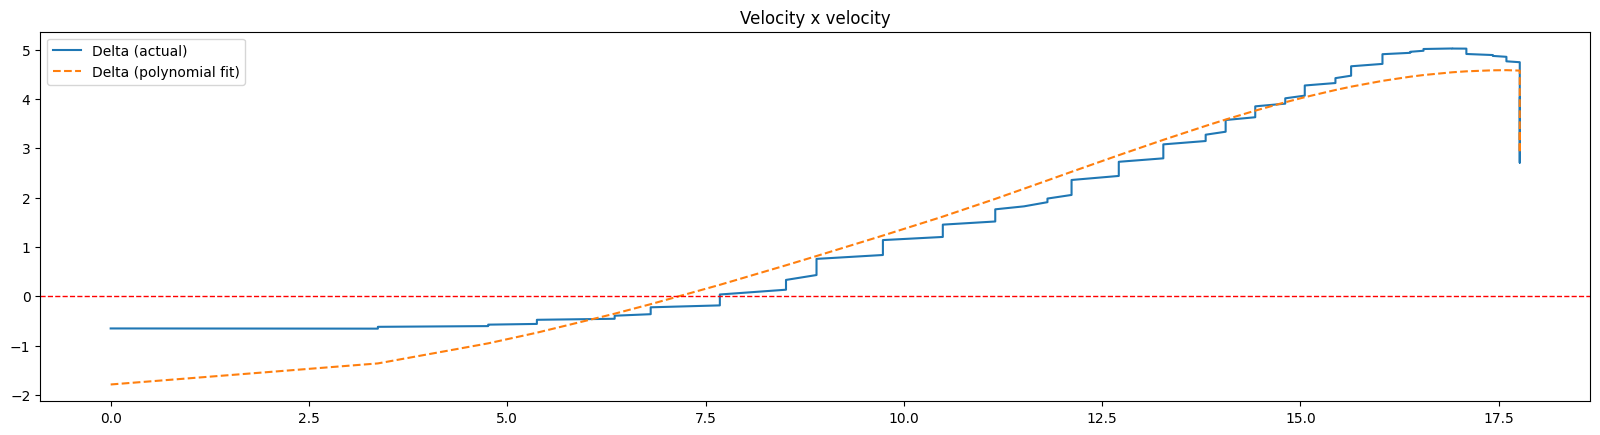

In [41]:
output = draw_init_velocity_delta(
    processed_sections[4]["df"], processed_sections[4]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 330)
)
all_poly_graphs.append(output)

#### Sloučení do jednoho grafu

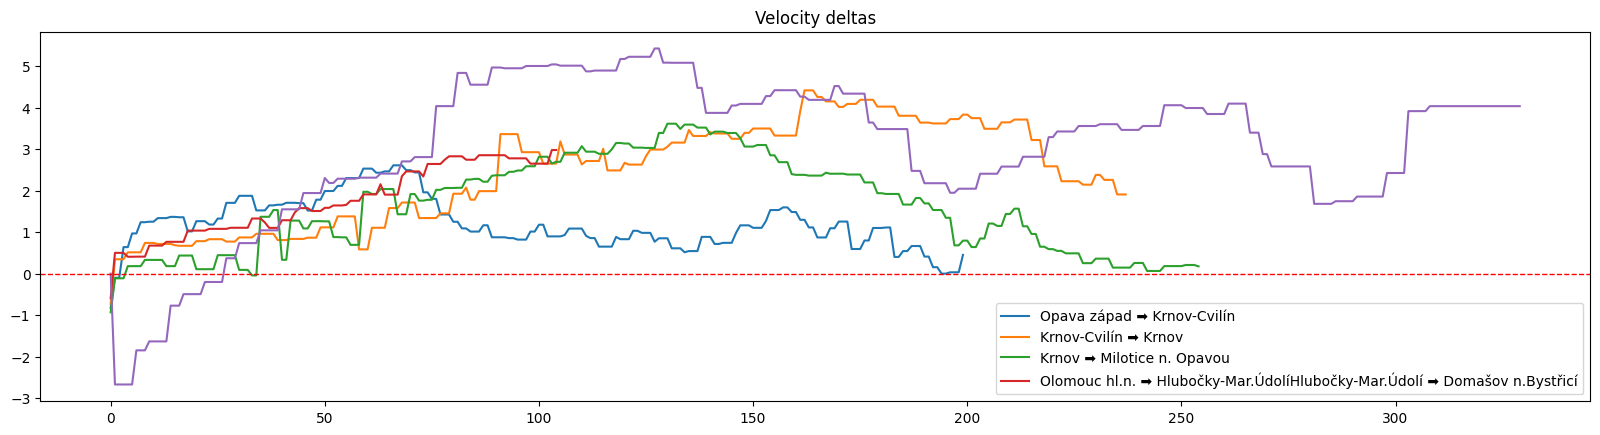

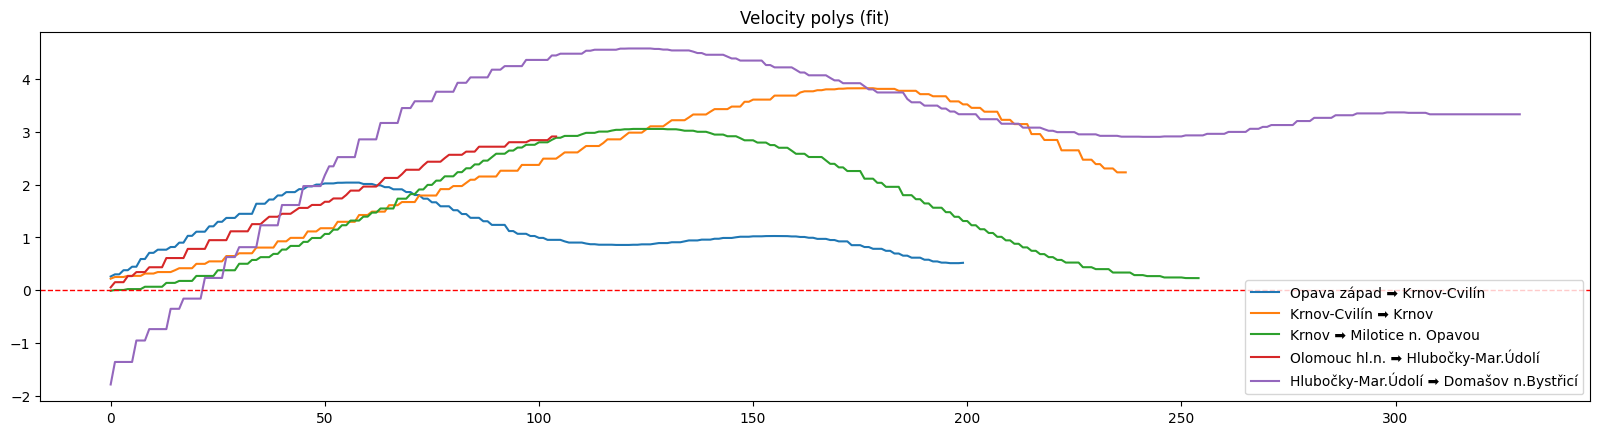

In [42]:
all_velocity_deltas = [x["deltas"] for x in all_poly_graphs]
all_polys = [list(x["poly"](x["dists"])) for x in all_poly_graphs]

max_len = max([len(x) for x in all_velocity_deltas])
for i,x in enumerate(all_velocity_deltas):
    if len(x) < max_len:
        x += [None] * (max_len-len(x))
for i,x in enumerate(all_polys):
    if len(x) < max_len:
        x += [None] * (max_len-len(x))

render_plot(
    "Velocity deltas",
    list(range(0, max_len)),
    all_velocity_deltas,
    [
        "Opava západ ➡️ Krnov-Cvilín",
        "Krnov-Cvilín ➡️ Krnov",
        "Krnov ➡️ Milotice n. Opavou",
        "Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí"
        "Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí"
    ],
    ["solid"]*100,
    show_hline=True,
    legend_loc="lower right"
)

render_plot(
    "Velocity polys (fit)",
    list(range(0, max_len)),
    all_polys,
    [
        "Opava západ ➡️ Krnov-Cvilín",
        "Krnov-Cvilín ➡️ Krnov",
        "Krnov ➡️ Milotice n. Opavou",
        "Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí",
        "Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí"
    ],
    ["solid"]*100,
    show_hline=True,
    legend_loc="lower right"
)

#### Vybraný polynom

polynomial:            5             4             3             2
-3.09e-15 x + 1.335e-11 x - 1.491e-08 x - 4.079e-06 x + 0.0104 x - 0.01215
polynomial as list: [-3.0895442432870143e-15, 1.3353071313836504e-11, -1.4905593183594405e-08, -4.078619365200279e-06, 0.010395418130657492, -0.01215459865105322]
values @ 200: 1.8049157673479652
values: 1000 1000


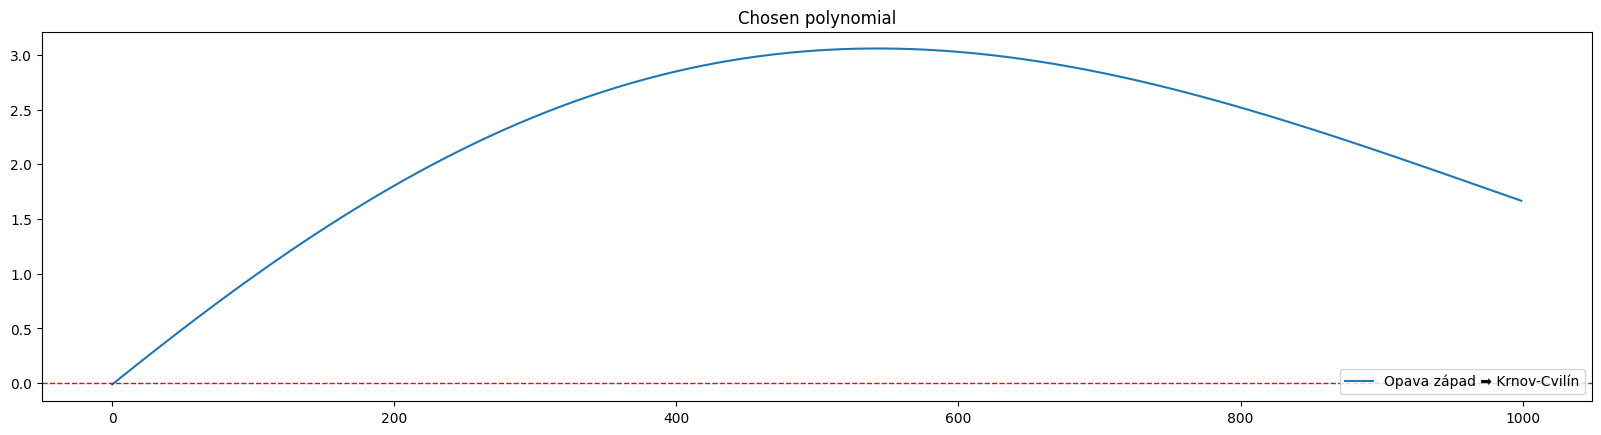

In [43]:
golden_poly = all_poly_graphs[2]["poly"]
print("polynomial:", golden_poly)
print("polynomial as list:", list(golden_poly))
print("values @ 200:", golden_poly(200))

x_len = 1000
x = list(range(0, x_len))
print("values:", len(golden_poly(x)), len(x))
render_plot(
    "Chosen polynomial",
    x,
    [golden_poly(x)],
    ["Opava západ ➡️ Krnov-Cvilín"],
    ["solid"],
    show_hline=True,
    legend_loc="lower right"
)